In [13]:
import sys
import numpy as np
import pandas as pd
import importlib
import os


import McsPy
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from scipy.signal import butter, lfilter, freqz, find_peaks, correlate, gaussian, filtfilt
from scipy import stats
from scipy import signal

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import glob
import time

from neo.core import AnalogSignal
import quantities as pq

from elephant.spectral import welch_psd
from elephant.current_source_density import estimate_csd


%matplotlib notebook

In [14]:
inputdirectory = "/Users/jonas/Documents/DATA/MEA_DATA_Aachen_sample/datasample"

In [15]:
timestr = time.strftime("%d%m%Y")


### Import of all Custom Functions

In [16]:

def get_channel_infos(filedirectory, meafile):
    channel_raw_data = McsPy.McsData.RawData(os.path.join(filedirectory, 
                                                          meafile))
    print(channel_raw_data.recordings)
    print(channel_raw_data.comment)
    print(channel_raw_data.date)
    print(channel_raw_data.clr_date)
    print(channel_raw_data.date_in_clr_ticks)
    print(channel_raw_data.file_guid)
    print(channel_raw_data.mea_name)
    print(channel_raw_data.mea_sn)
    print(channel_raw_data.mea_layout)
    print(channel_raw_data.program_name)
    print(channel_raw_data.program_version)
    analognumber = len(channel_raw_data.recordings[0].analog_streams.keys())
    print('In total '+ str(analognumber) 
          + " analog_streams were identified.\n")
    for i in range(len(channel_raw_data.recordings[0].analog_streams.keys())):
        keylist = []
        stream = channel_raw_data.recordings[0].analog_streams[i]
        for key in stream.channel_infos.keys():
                keylist.append(key)
        channel_id = keylist[0]
        datapoints = channel_raw_data.recordings[0].analog_streams[i].channel_data.shape[1]
        samplingfrequency = stream.channel_infos[channel_id].sampling_frequency
        ticks = stream.channel_infos[channel_id].info['Tick']
        time = stream.get_channel_sample_timestamps(channel_id)
        scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
        time_in_sec = time[0] * scale_factor_for_second
        timelengthrecording_ms = time[0][-1]+ticks
        timelengthrecording_s = (time[0][-1]+ticks)*scale_factor_for_second
        print("analog_stream Nr. " + str(i) + ": ")
        print("datapoints measured = " + str(datapoints))
        print("sampling frequency = " + str(samplingfrequency))
        print("ticks = " + str(ticks))
        print("total recordingtime is: " 
              + str(timelengthrecording_s) + "seconds \n")




def get_MEA_Signal(analog_stream, channel_idx, from_in_s=0, to_in_s=None):
    '''
    Extracts one Channels (channel_idx) Sginal 
    
    :param analog_stream = the analogstream from one recording
    :param channel_idx   = the channel index of the channel where you 
                            extract the values from
    :param from_in_s     = starting point of the range you want to observe 
                            in seconds
    :param to_in_s       = ending point of the range you want to observe. 
                            Default is None (i.e. whole range)
    
    Returns: the signal in uV, time stamps in sec, the sampling frequency
    
    
    '''
    ids = [c.channel_id for c in analog_stream.channel_infos.values()]
    channel_id = ids[channel_idx]
    channel_info = analog_stream.channel_infos[channel_id]
    sampling_frequency = channel_info.sampling_frequency.magnitude

    # get start and end index
    from_idx = max(0, int(from_in_s * sampling_frequency))
    if to_in_s is None:
        to_idx = analog_stream.channel_data.shape[1]
    else:
        to_idx = min(
            analog_stream.channel_data.shape[1], 
            int(to_in_s * sampling_frequency)
            )

    # get the timestamps for each sample
    time = analog_stream.get_channel_sample_timestamps(
        channel_id, from_idx, to_idx
        )

    # scale time to seconds:
    scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
    time_in_sec = time[0] * scale_factor_for_second

    # get the signal
    signal = analog_stream.get_channel_in_range(channel_id, from_idx, to_idx)

    # scale signal to µV:
    scale_factor_for_uV = Q_(1,signal[1]).to(ureg.uV).magnitude
    signal_in_uV = signal[0] * scale_factor_for_uV
    
    return signal_in_uV, time_in_sec, sampling_frequency, scale_factor_for_second


def get_MEA_Channel_labels(np_analog_for_filter):
    '''
    Gives a List of all MEA Channel Labels (e.g. R12) in the order they appear
    within the recording.
    
    :param analogstream_data = an numpy array shape(channels, data)
    
    '''
    labellist = []
    for i in range(0, len(np_analog_for_filter)):
        #channel_idx = i
        ids = [c.channel_id for c in analog_stream_0.channel_infos.values()]
        channel_id = ids[i]
        channel_info = analog_stream_0.channel_infos[channel_id]
        #print(channel_info.info['Label'])
        labellist.append(channel_info.info['Label'])
    return labellist
    

def detect_threshold_crossings(signal, fs, threshold, dead_time):
    """
    Detect threshold crossings in a signal with dead time and return 
    them as an array

    The signal transitions from a sample above the threshold to a sample 
    below the threshold for a detection and
    the last detection has to be more than dead_time apart 
    from the current one.

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold: The threshold for the signal
    :param dead_time: The dead time in seconds.
    """
    dead_time_idx = dead_time * fs
    threshold_crossings = np.diff(
        (signal <= threshold).astype(int) > 0).nonzero()[0]
    distance_sufficient = np.insert(
        np.diff(threshold_crossings) >= dead_time_idx, 0, True
        )
    while not np.all(distance_sufficient):
        # repeatedly remove all threshold crossings that violate the dead_time
        threshold_crossings = threshold_crossings[distance_sufficient]
        distance_sufficient = np.insert(
            np.diff(threshold_crossings) >= dead_time_idx, 0, True
            )
    return threshold_crossings


def get_next_minimum(signal, index, max_samples_to_search):
    """
    Returns the index of the next minimum in the signal after an index

    :param signal: The signal as a 1-dimensional numpy array
    :param index: The scalar index
    :param max_samples_to_search: The number of samples to search for a 
                                    minimum after the index
    """
    search_end_idx = min(index + max_samples_to_search, signal.shape[0])
    min_idx = np.argmin(signal[index:search_end_idx])
    return index + min_idx


def align_to_minimum(signal, fs, threshold_crossings, search_range, first_time_stamp=0):
    """
    Returns the index of the next negative spike peak for all threshold crossings

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold_crossings: The array of indices where the signal 
                                crossed the detection threshold
    :param search_range: The maximum duration in seconds to search for the 
                         minimum after each crossing
    """
    search_end = int(search_range*fs)
    aligned_spikes = [get_next_minimum(signal, t, search_end) for t in threshold_crossings]
    return np.array(aligned_spikes)


def find_triggers(dset_trigger, tick):
    
    for i in range(0,len(dset_trigger)-1):
        trigger_n=i
        Trigger_An=dset_trigger[trigger_n]
        diff_An=np.diff(Trigger_An)
        peaks, _ = find_peaks(diff_An, height = 2000) #MEA60=0.75
        peaks_off, _ = find_peaks(-diff_An, height = 2000) #""
        if len(peaks)>=0:
            break
    
    if trigger_n ==0:
        odd_peaks= peaks
        odd_peaks_off= peaks_off
    else:
        odd_peaks=peaks
        odd_peaks_off=peaks_off
    #x=np.arange(len(Trigger_An))*tick
    #plt.plot(x, Trigger_An)
    return odd_peaks, odd_peaks_off, diff_An

def spike_on_off(trigger_on, trigger_off, spikedic, tick):
    """
    Takes the dictionary with all spikes and sorts them into either a dictionary for
    spikes while trigger on (=ONdic) or off (=OFFdic)
    
    :param trigger_on =basically created through the find_triggers function 
                        and marks points were stimulation is turned on
    :param trigger_off =see trigger_on but for stimulation off
    :spikedic = dictionary of spikes for each electrode
    :tick
    """
    on=[]
    off=[]
    ONdic ={}
    OFFdic={}
    Trigger_An=[]
    Trigger_Aus=[]
    
    if len(trigger_off)==0:
        Trigger_An=[]
    elif trigger_off[len(trigger_off)-1]>trigger_on[len(trigger_on)-1]:
        Trigger_An=trigger_on*tick
    else:
        Trigger_An=[]
        for n in range(0,len(trigger_on)-1):
            Trigger_An.append(trigger_on[n]*tick)   
        Trigger_An=np.array(Trigger_An)

            
    if len(trigger_on)==0:
        Trigger_Aus=[]
    elif trigger_off[0]>trigger_on[0]:
        Trigger_Aus=trigger_off*tick
    else:
        Trigger_Aus=[]
        for n in range(1,len(trigger_off)):
            Trigger_Aus.append(trigger_off[n]*tick)
        Trigger_Aus=np.array(Trigger_Aus)
    
    Trigger_Aus2=np.insert(Trigger_Aus,0,0)
    
    for key in spikedic:
        ON = []
        OFF = []
        for i in spikedic[key]: #i mit 40 multiplizieren, da Trigger an und aus mit Tick multipliziert sind
            if len(Trigger_An)==0:
                OFF.append(i)
            if any(Trigger_An[foo] < i*tick < Trigger_Aus[foo]  for foo in np.arange(len(Trigger_Aus)-1)):
                ON.append(i)
            elif any(Trigger_Aus2[foo]  < i*tick < Trigger_An[foo]  for foo in np.arange(len(Trigger_An))):
                OFF.append(i)
        ONdic[key]=np.asarray(ON)
        OFFdic[key]=np.asarray(OFF)
    
    return ONdic, OFFdic


def extract_waveforms(signal, fs, spikes_idx, pre, post):
    """
    Extract spike waveforms as signal cutouts around each spike index as a spikes x samples numpy array

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param spikes_idx: The sample index of all spikes as a 1-dim numpy array
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    """
    cutouts = []
    pre_idx = int(pre * fs)
    post_idx = int(post * fs)
    for index in spikes_idx:
        if index-pre_idx >= 0 and index+post_idx <= signal.shape[0]:
            cutout = signal[int((index-pre_idx)):int((index+post_idx))]
            cutouts.append(cutout)
    if len(cutouts)>0:
        return np.stack(cutouts)
    
    
def plot_waveforms(cutouts, fs, pre, post, n=100, color='k', show=True):
    """
    Plot an overlay of spike cutouts

    :param cutouts: A spikes x samples array of cutouts
    :param fs: The sampling frequency in Hz
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    :param n: The number of cutouts to plot, or None to plot all. Default: 100
    :param color: The line color as a pyplot line/marker style. Default: 'k'=black
    :param show: Set this to False to disable showing the plot. Default: True
    """
    if n is None:
        n = cutouts.shape[0]
    n = min(n, cutouts.shape[0])
    time_in_us = np.arange(-pre*1000, post*1000, 1e3/fs)
    if show:
        _ = plt.figure(figsize=(12,6))

    for i in range(n):
        _ = plt.plot(time_in_us, cutouts[i,]*1e6, color, linewidth=1, alpha=0.3)
        _ = plt.xlabel('Time (%s)' % ureg.ms)
        _ = plt.ylabel('Voltage (%s)' % ureg.uV)
        _ = plt.title('Cutouts')

    if show:
        plt.show()

        
def butter_lowpass_filter(data, cutoff, fs, order):

    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
    
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y    
    

In [17]:
# set filter cuts in Hz
lowcut = 150
highcut = 4500

# Length of cutouts around shapes
pre = 0.001 # 1 ms
post= 0.002 # 2 ms


# get filelist
os.chdir(inputdirectory)
filelist= glob.glob("*.h5")


resting_spikedic={}
spikedic={}
spikedic_MAD={}
artefactsdic_MAD={}
cutouts_dic ={} 
keylist = []

In [18]:
# choose the file for filtering
filelist

['2021-05-17T11-28-41__cortex_div11_aCSF_ID046_30µMNE_spont_1__.h5']

In [19]:
filename = filelist[0]

In [20]:
filedatebase = filename.split('T')[0]
filenamebase = filename.split('__')[1]
filebase = filedatebase + '_' + filenamebase
print('Working on file: ' +filename)
channel_raw_data = McsPy.McsData.RawData(filename)
get_channel_infos(inputdirectory, filename)

Working on file: 2021-05-17T11-28-41__cortex_div11_aCSF_ID046_30µMNE_spont_1__.h5
Recording_0 <HDF5 group "/Data/Recording_0" (2 members)>
{0: <Recording label=, AnalogStreams=3, EventStreams=1, duration_time=120400000 microsecond>}

2021-05-17 11:28:41.983040
Montag, 17. Mai 2021
637568477219830367
93cc2871-fddc-4f8a-a10c-710223cf8328
256MEA

MEA_256MEA_MEA2100_252_6
Multi Channel Experimenter
2.15.0.20098
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (252, 3010000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (252,), type "|V108">
Stream_1 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_1" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (1, 3010000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape

In [21]:
# import of the analogstream with the recording data
analog_stream_0 = channel_raw_data.recordings[0].analog_streams[0]
stream = analog_stream_0
for key in stream.channel_infos.keys():
    keylist.append(key)

Recording_0 <HDF5 group "/Data/Recording_0" (2 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (252, 3010000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (252,), type "|V108">
Stream_1 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_1" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (1, 3010000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (1,), type "|V108">
Stream_2 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_2" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (1, 3010000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (1,), type "|V108">


In [22]:
# we assign all basic info of that recording to parameters

channel_id = keylist[0]
tick = stream.channel_infos[channel_id].info['Tick']
time = stream.get_channel_sample_timestamps(channel_id)
first_recording_timepoint = time[0][0]
scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
time_in_sec = time[0]*scale_factor_for_second
timelengthrecording_ms = time[0][-1]+tick
timelengthrecording_s = (time[0][-1]+tick)*scale_factor_for_second
fs = int(stream.channel_infos[channel_id].sampling_frequency.magnitude)

In [23]:
# import the actual data 

analog_stream_0_data = analog_stream_0.channel_data
np_analog_stream_0_data = np.transpose(
    channel_raw_data.recordings[0].analog_streams[0].channel_data
    )
    

In [24]:
# the data is now transposed
np_analog_for_filter = np.transpose(np_analog_stream_0_data)
np_analog_stream_1_data = np.transpose(
    channel_raw_data.recordings[0].analog_streams[0].channel_data
    )
np_analog_stream_1_data_transpose = np.transpose(np_analog_stream_1_data)

In [25]:
np_analog_stream_1_data_transpose.shape

(252, 3010000)

In [26]:
# choose the correct channel you want to plot
labellist = get_MEA_Channel_labels(np_analog_for_filter)

# make a dictionary so we can reverse search
label_number_dic = {}
for i in range(0, len(labellist)):
    channel_label = labellist[i]
    label_number_dic[channel_label] = i

## Calculate the mean lowpassfiltered signal of the whole recording


In [27]:
labellist

['G13',
 'G12',
 'F16',
 'F15',
 'F14',
 'F13',
 'F12',
 'E16',
 'E15',
 'E14',
 'E13',
 'G11',
 'D16',
 'D15',
 'D14',
 'H9',
 'F11',
 'C16',
 'C15',
 'D13',
 'B16',
 'B15',
 'C14',
 'A15',
 'A14',
 'B14',
 'G10',
 'E12',
 'B13',
 'C13',
 'F10',
 'A13',
 'C12',
 'D12',
 'A12',
 'B12',
 'D11',
 'E11',
 'B11',
 'C11',
 'E10',
 'A11',
 'C10',
 'D10',
 'A10',
 'B10',
 'D9',
 'E9',
 'B9',
 'C9',
 'F9',
 'A9',
 'G8',
 'G9',
 'A8',
 'F8',
 'C8',
 'B8',
 'E8',
 'D8',
 'B7',
 'A7',
 'D7',
 'C7',
 'A6',
 'E7',
 'C6',
 'B6',
 'E6',
 'D6',
 'B5',
 'A5',
 'D5',
 'C5',
 'A4',
 'F7',
 'C4',
 'B4',
 'F6',
 'H8',
 'B3',
 'A3',
 'D4',
 'A2',
 'B2',
 'B1',
 'C3',
 'C2',
 'C1',
 'E5',
 'G7',
 'D3',
 'D2',
 'D1',
 'G6',
 'E4',
 'E3',
 'E2',
 'E1',
 'F5',
 'F4',
 'F3',
 'F2',
 'F1',
 'G5',
 'G4',
 'G3',
 'G2',
 'G1',
 'H5',
 'H4',
 'H3',
 'H2',
 'H1',
 'H6',
 'H7',
 'J7',
 'J6',
 'J1',
 'J2',
 'J3',
 'J4',
 'J5',
 'K1',
 'K2',
 'K3',
 'K4',
 'K5',
 'L1',
 'L2',
 'L3',
 'L4',
 'L5',
 'M1',
 'M2',
 'M3',
 'M

### Give Desired Channel

In [28]:
desired_channel = 'J13'

In [29]:
channel_idx = label_number_dic[desired_channel]
channellabel = labellist[channel_idx]

In [30]:
signal_in_uV, time_in_sec, sampling_frequency, scale_factor_for_second = get_MEA_Signal(analog_stream_0, channel_idx)
bandpassfilteredsignal = butter_bandpass_filter(
    signal_in_uV, lowcut, highcut, sampling_frequency
    )

In [31]:
channellabel

'J13'

In [32]:
np.shape(signal_in_uV)

(3010000,)

### for whole dictionary with all bandpass and lowpass filtered signals



<IPython.core.display.Javascript object>


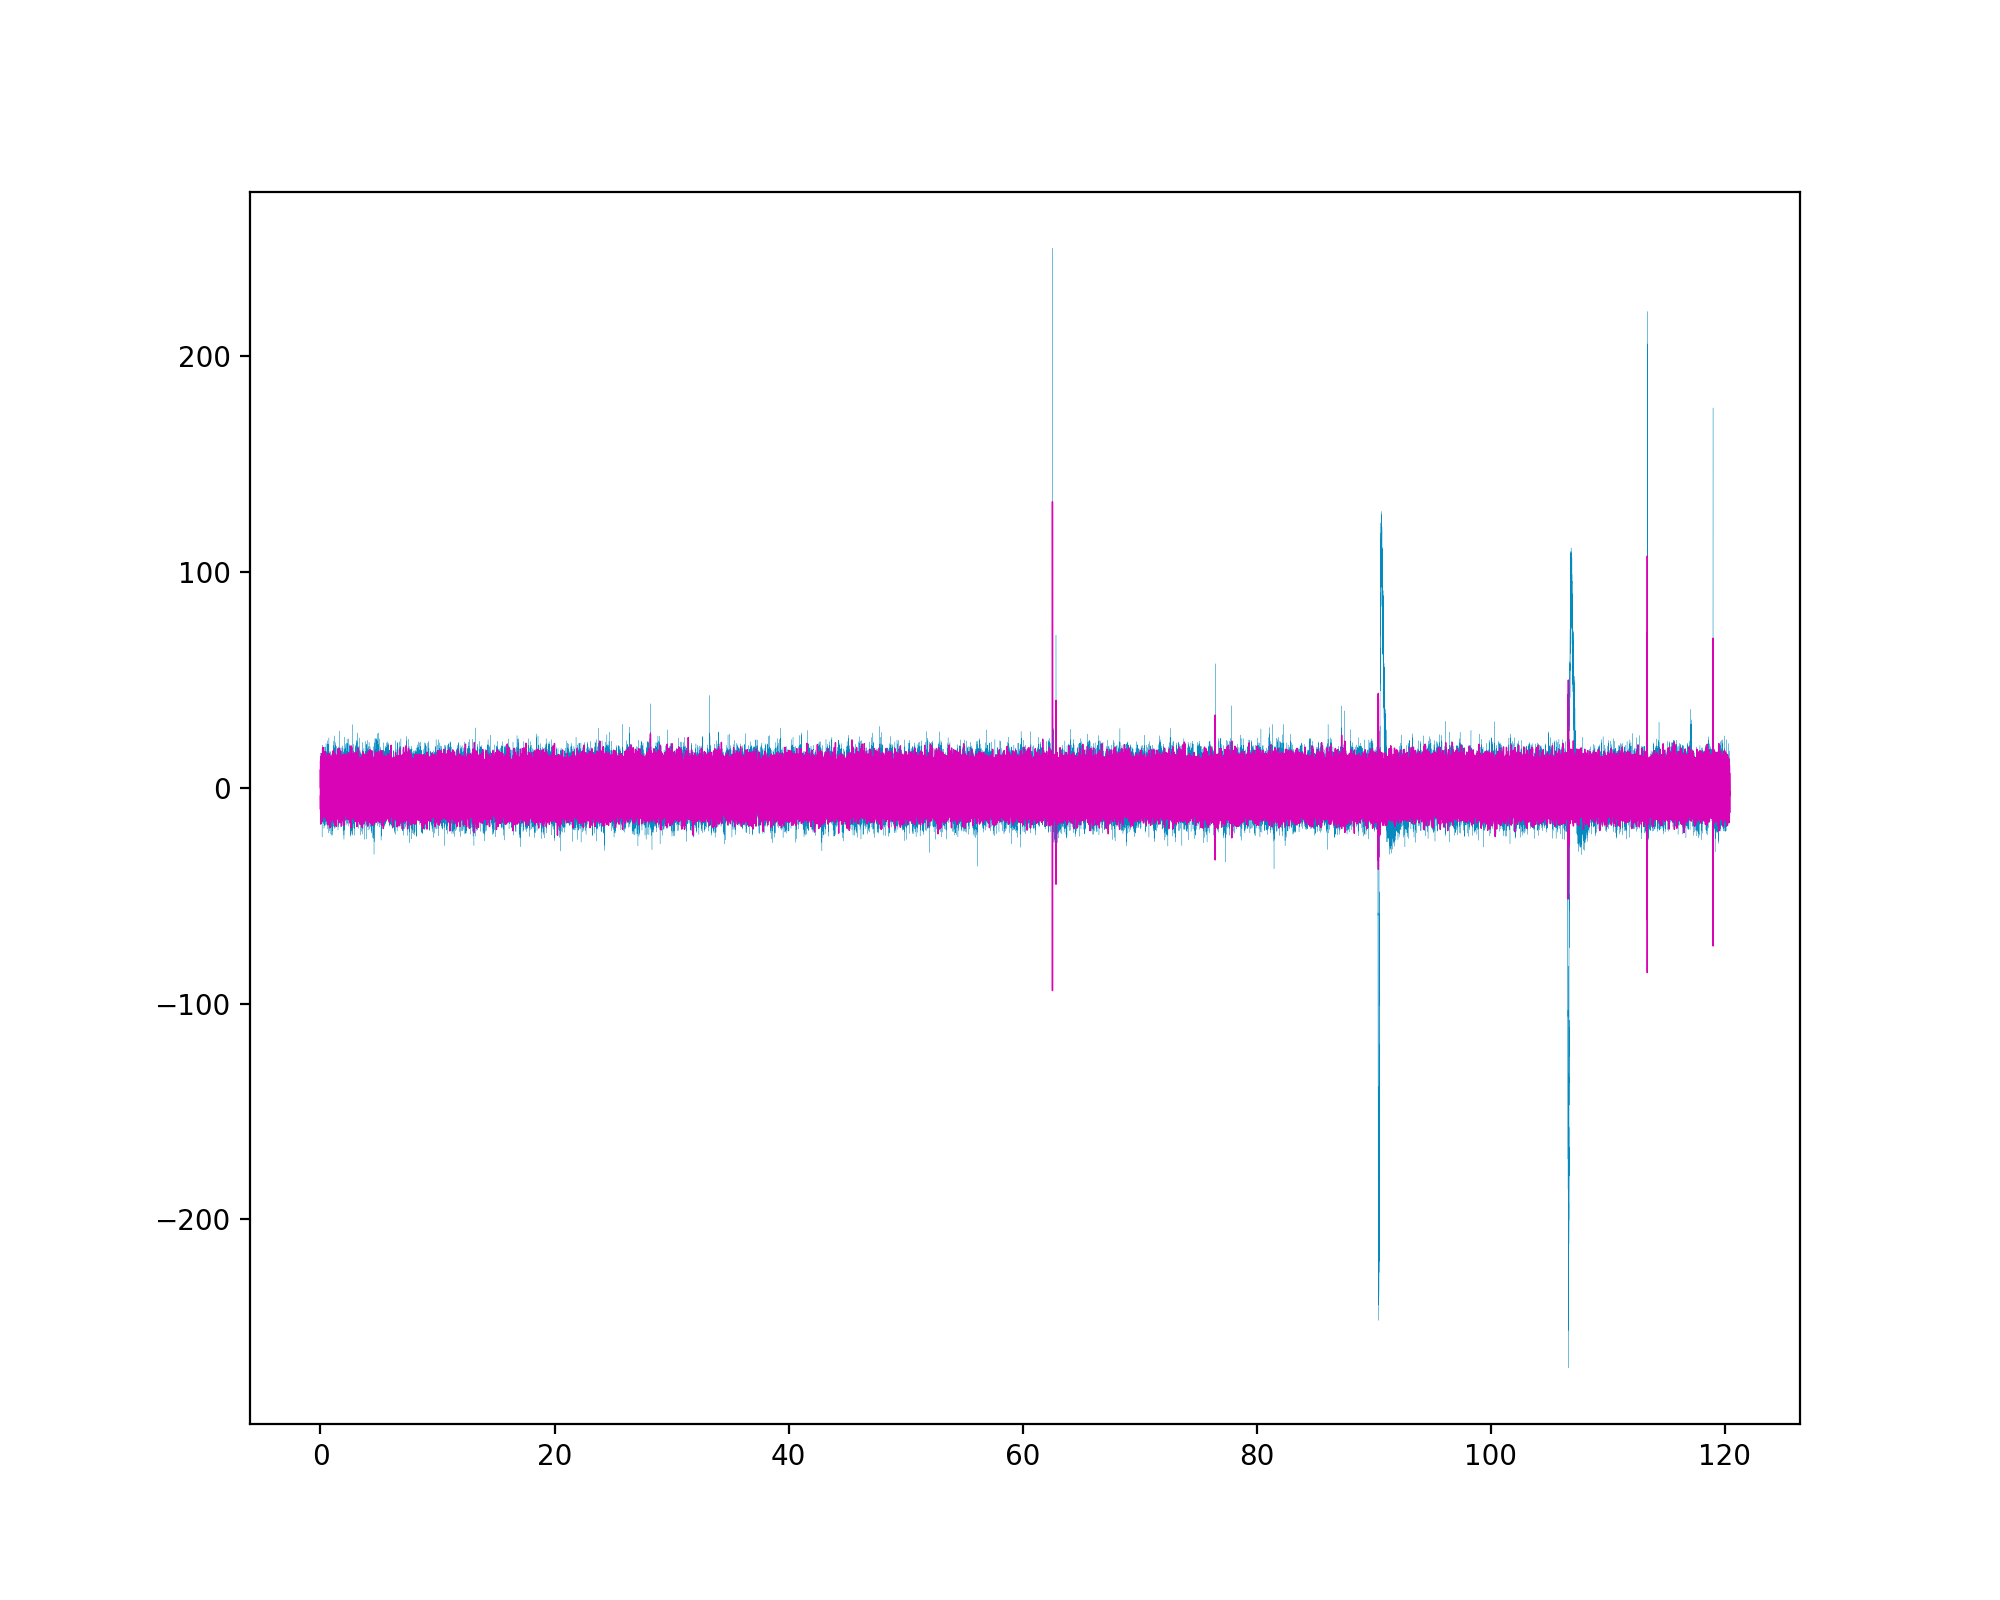

In [33]:
# plot the signal and the filter

fig, ax = plt.subplots(1, 1, figsize = (10,8))

ax.plot(time_in_sec, signal_in_uV, c = '#048ABF',  linewidth = 0.1)
ax.plot(time_in_sec, bandpassfilteredsignal, c = '#D904B5', linewidth = 0.5)

In [34]:
# Filter requirements.
T = timelengthrecording_s         # Sample Period
fs = fs      # sample rate, Hz
cutoff = 50      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

In [35]:
nyq

12500.0

In [36]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [37]:
butter_lowpass_filtered_signal = butter_lowpass_filter(signal_in_uV, cutoff, fs, order)

In [38]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

<IPython.core.display.Javascript object>


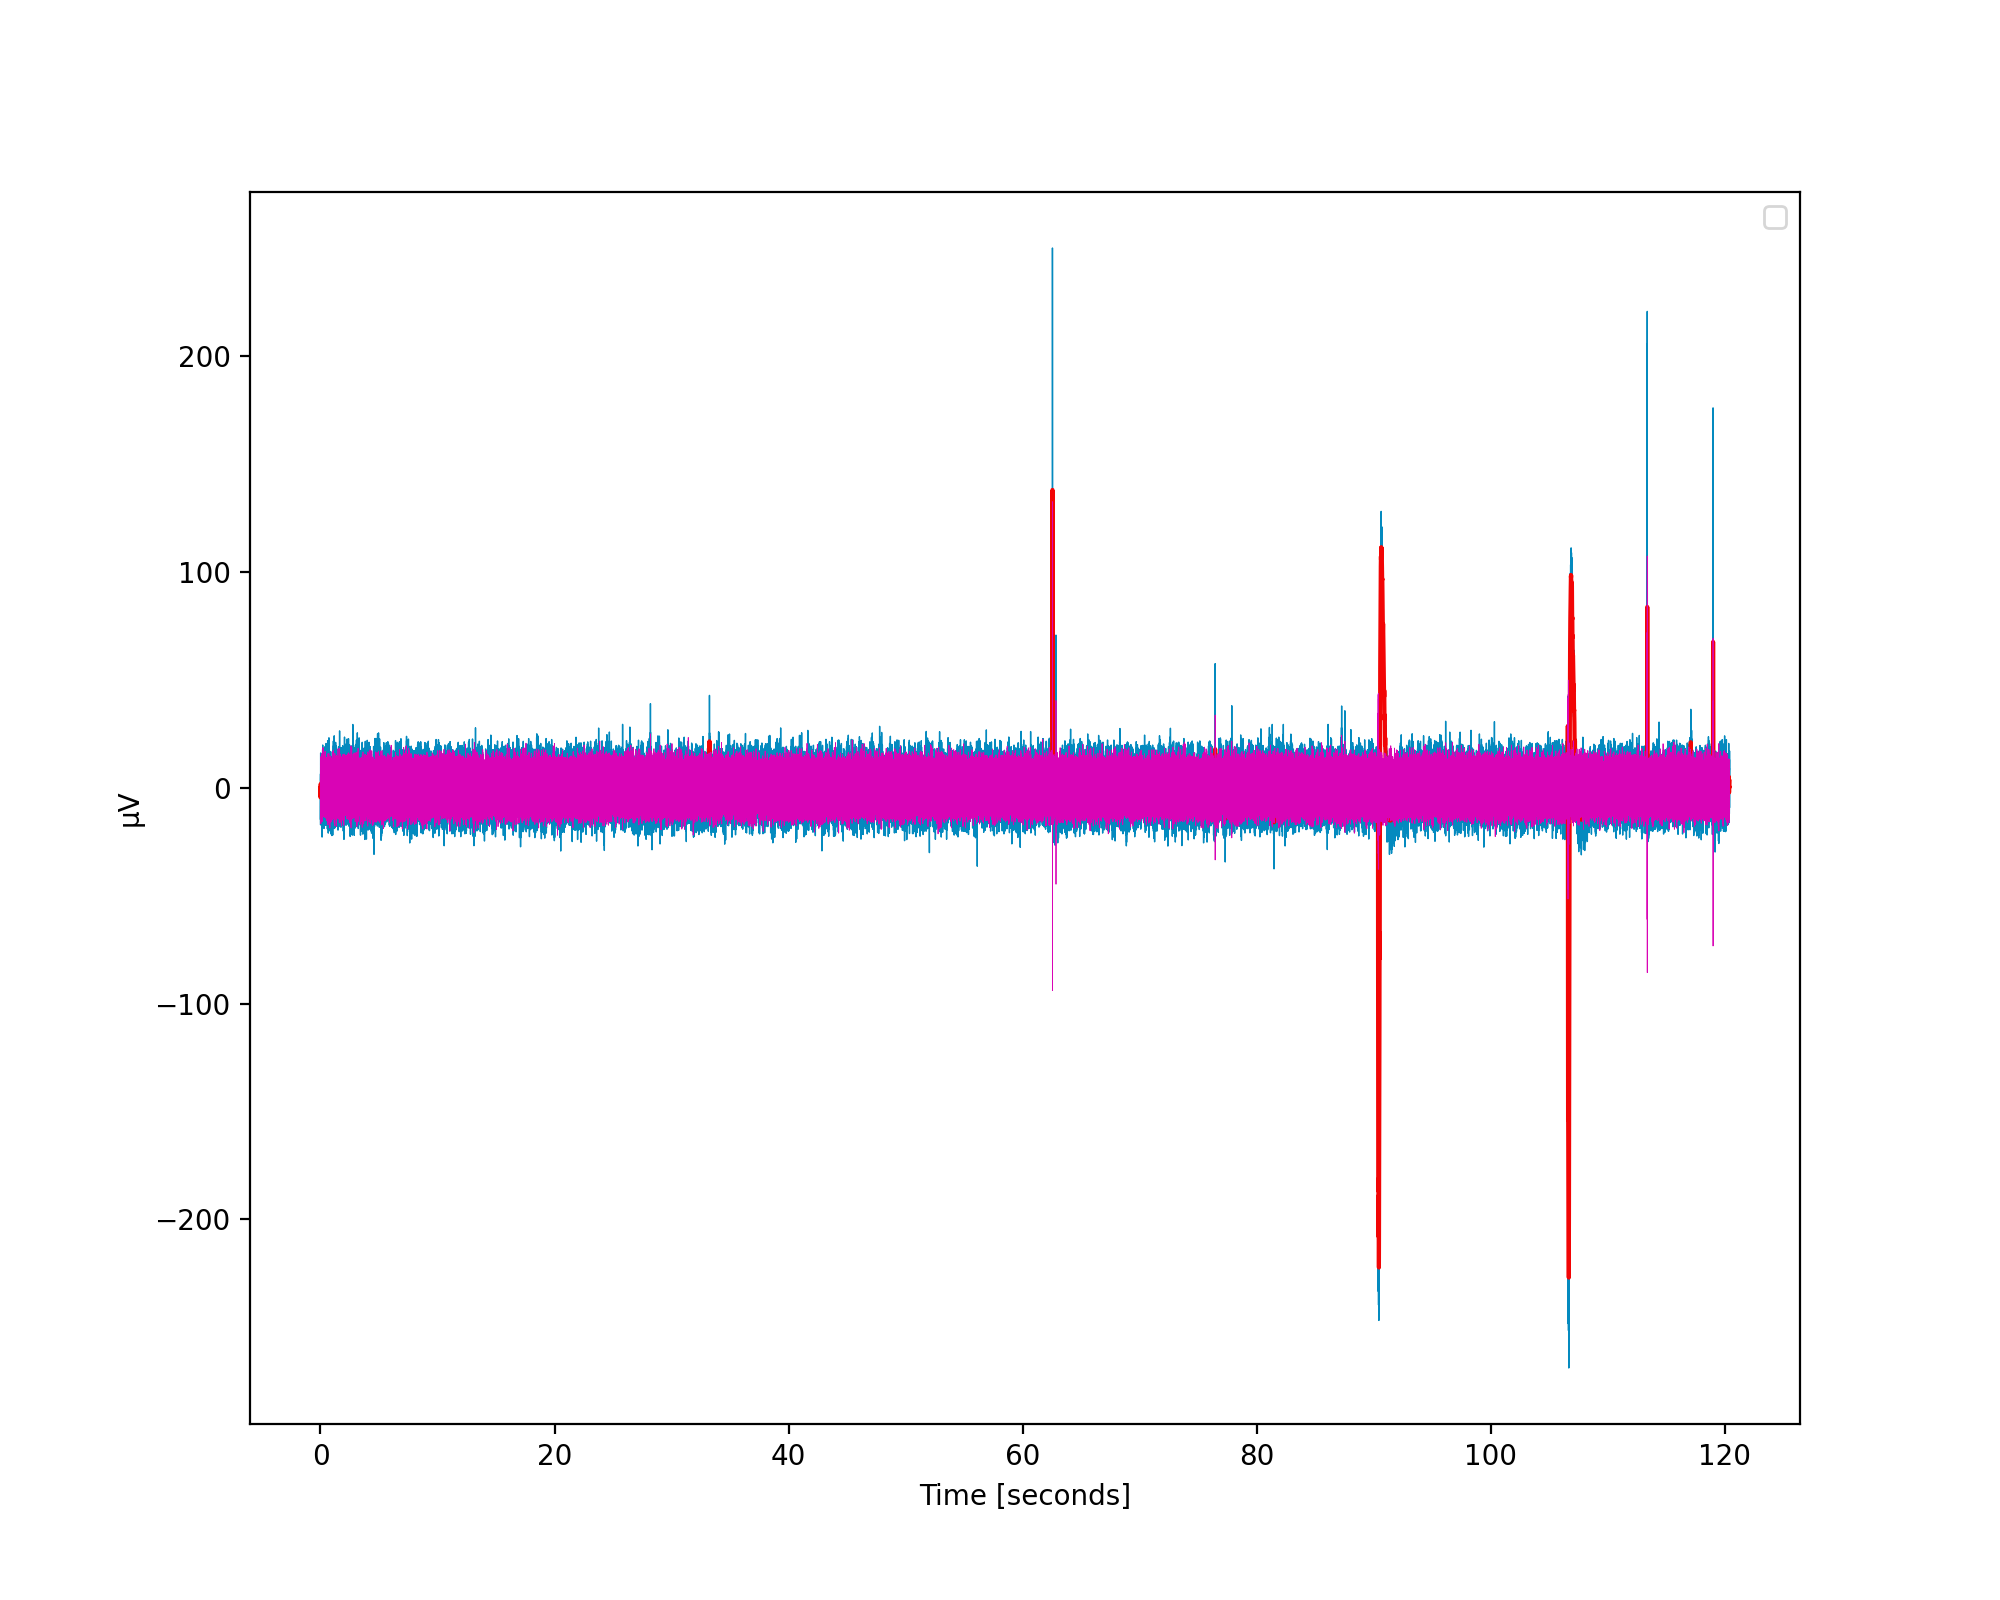

No handles with labels found to put in legend.


In [39]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))

ax.plot(time_in_sec, signal_in_uV, c = '#048ABF',  linewidth = 0.5)
ax.plot(time_in_sec, butter_lowpass_filtered_signal, c = '#F20505', linewidth = 1.5)
ax.plot(time_in_sec, bandpassfilteredsignal, c = '#D904B5', linewidth = 0.3)
ax.set_xlabel('Time [seconds]')
ax.set_ylabel('µV')
ax.legend()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to r

<IPython.core.display.Javascript object>


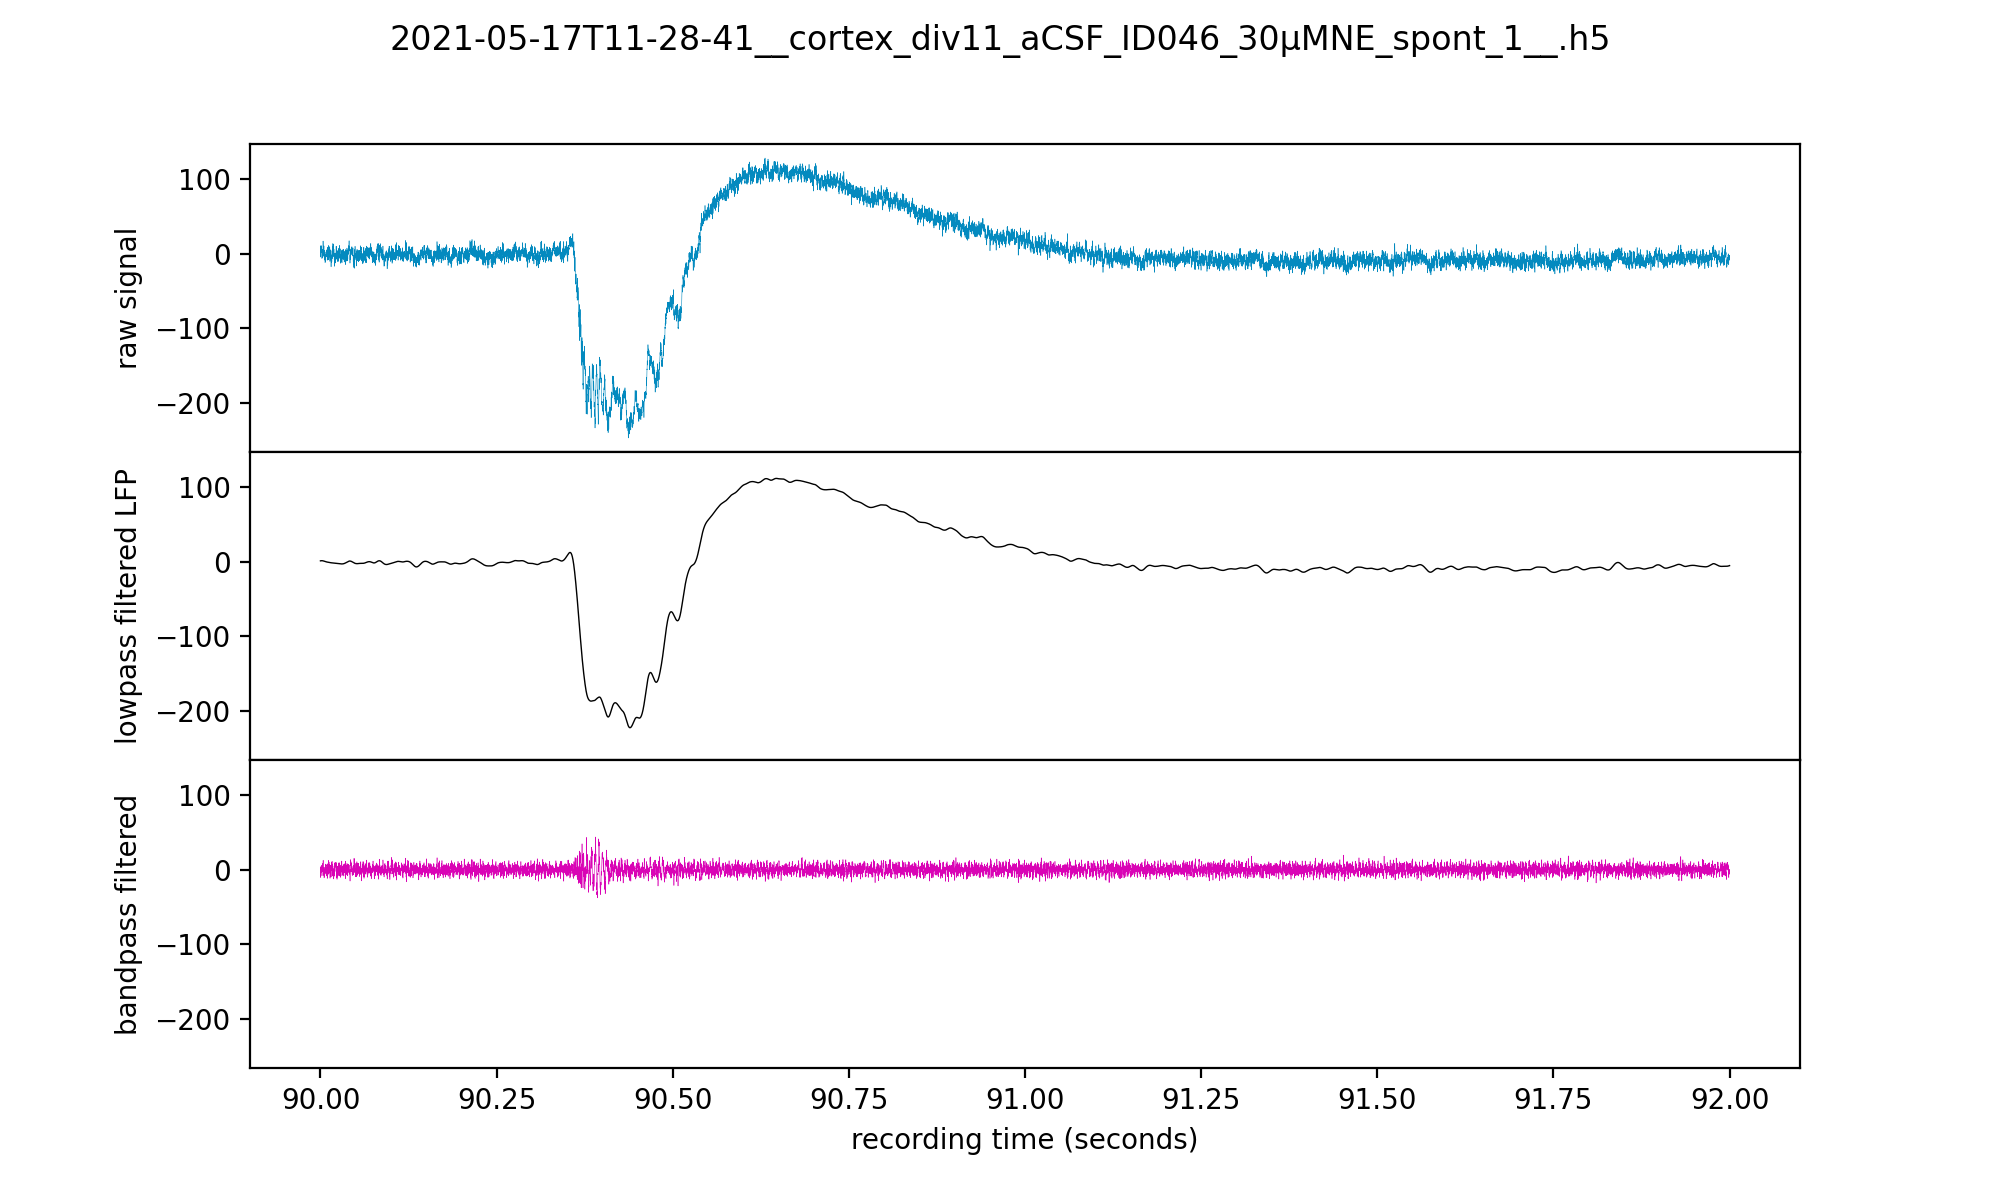

Text(0.5, 0.98, '2021-05-17T11-28-41__cortex_div11_aCSF_ID046_30µMNE_spont_1__.h5')

In [40]:
desired_time_interval = (90, 92)

start = np.int(desired_time_interval[0]/(scale_factor_for_second*tick))
stop = np.int(desired_time_interval[1]/(scale_factor_for_second*tick))



fig = plt.figure(figsize = (10,6))
gs = fig.add_gridspec(3, hspace = 0, height_ratios=[1,1,1])
axs = gs.subplots(sharex=True, sharey=True)
axs[0].plot(time_in_sec[start:stop], signal_in_uV[start:stop], c = '#048ABF',  linewidth = 0.2)
axs[0].set_ylabel('raw signal')
axs[1].plot(time_in_sec[start:stop], butter_lowpass_filtered_signal[start:stop], c = 'black', linewidth = 0.5)
axs[1].set_ylabel('lowpass filtered LFP')
axs[2].plot(time_in_sec[start:stop], bandpassfilteredsignal[start:stop], c = '#D904B5', linewidth = 0.2)
axs[2].set_ylabel('bandpass filtered')
axs[2].set_xlabel('recording time (seconds)')
fig.suptitle(filename)

#for ax in axs:
#    for i in bursts_seconds:
#        axs[1].axvspan(i[0], i[1], facecolor = '#5B89A6', alpha = 0.3)
#fig.savefig(filename+ '__raster_firingrate_plot_solo.png', dpi=300)
#fig.savefig(filename+ '__raster_firingrate_plot_solo.eps', dpi=300)
#fig.savefig(filename+ '__raster_firingrate_plot_solo.pdf', dpi=300)
#fig.savefig(filename+ '__raster_firingrate_plot_solo.svg', dpi=300)

In [41]:
butter_lowpass_filtered_signal

array([0.98652365, 0.93249989, 0.87849902, ..., 2.8929427 , 2.89325918,
       2.89351989])

In [42]:
channellabel

'J13'

In [43]:
noise_mad = np.median(np.absolute(bandpassfilteredsignal)) / 0.6745
threshold = -5* noise_mad
artefact_threshold = -8* noise_mad
crossings = detect_threshold_crossings(
    bandpassfilteredsignal, sampling_frequency, 
    threshold, dead_time=0.003
    )
spikes=align_to_minimum(
    bandpassfilteredsignal, fs, crossings, search_range=0.003, 
    first_time_stamp=first_recording_timepoint
    )

In [44]:
spikedic_MAD[channellabel] = spikes

In [45]:
len(spikedic_MAD['J13'])

24

<IPython.core.display.Javascript object>


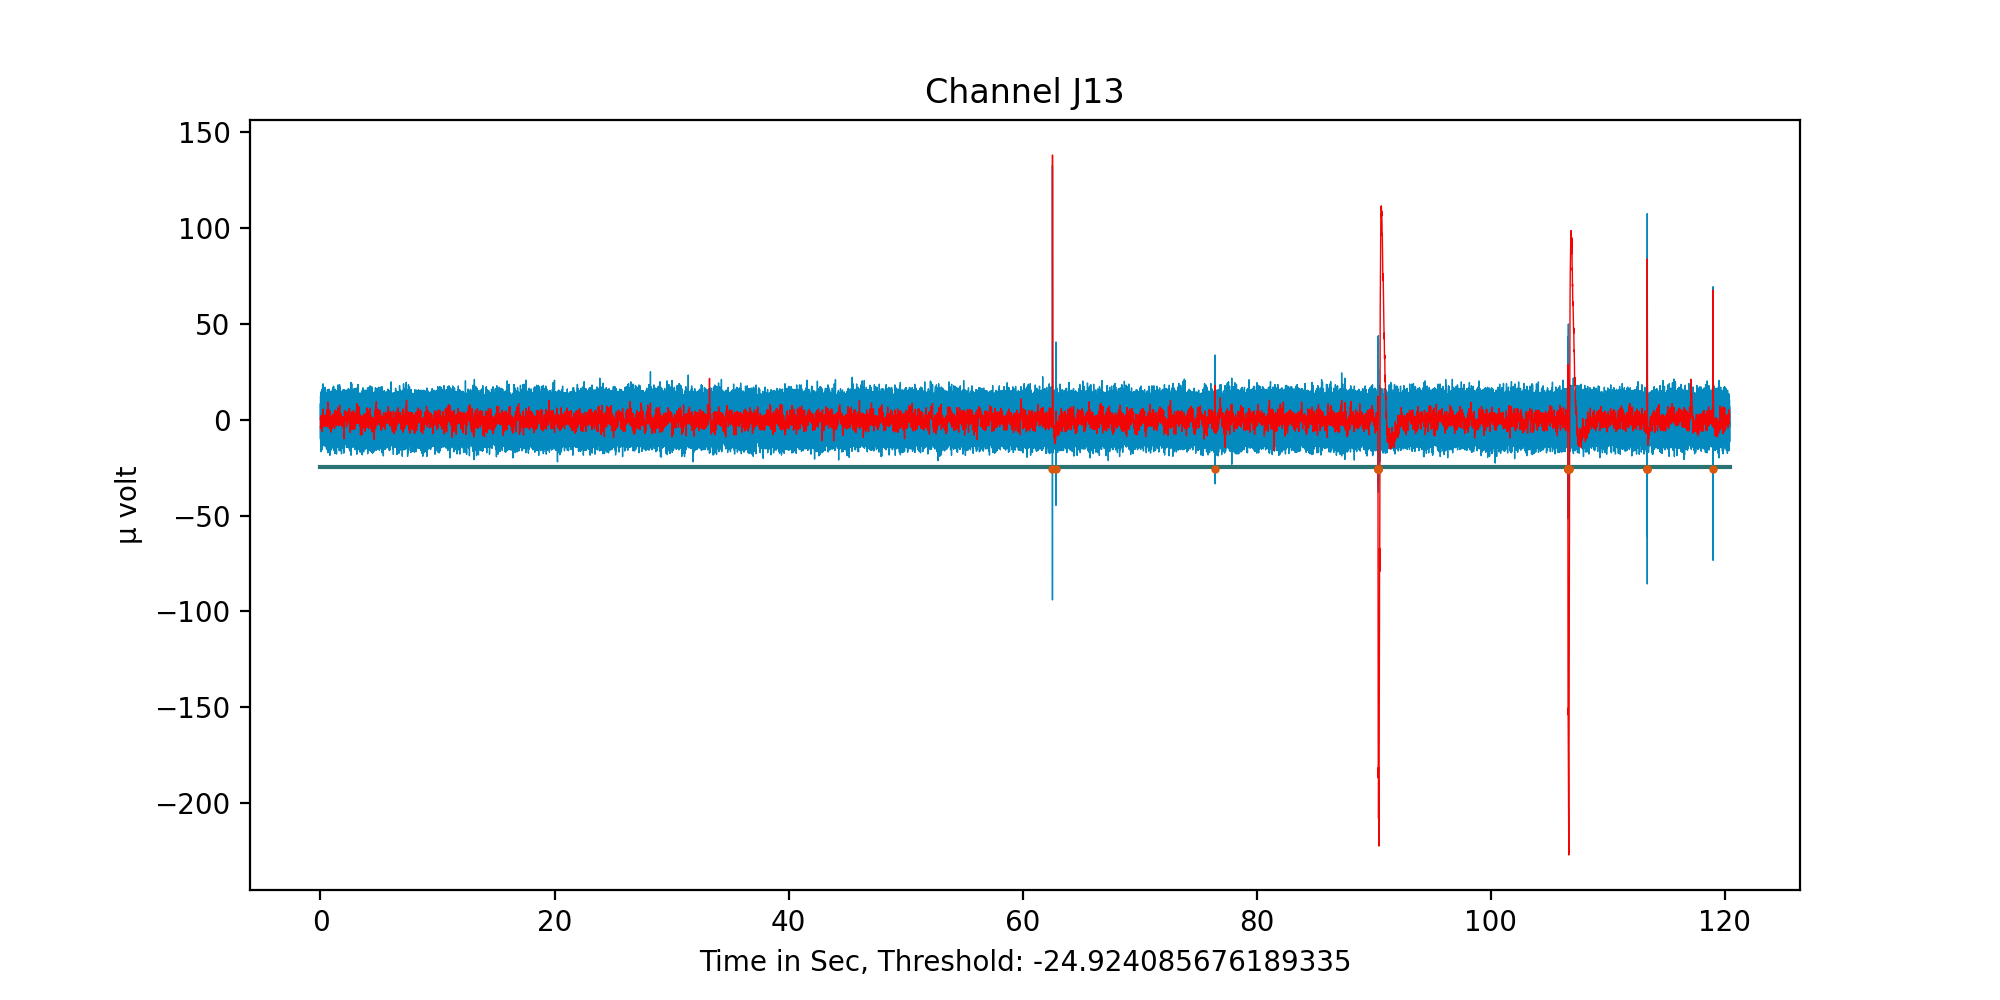

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plt.plot(time_in_sec, bandpassfilteredsignal, c="#048ABF", linewidth = 0.5)
ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [threshold, threshold], c="#297373")
ax = plt.plot(time_in_sec, butter_lowpass_filtered_signal, c='#F20505', linewidth=0.5)
ax = plt.plot(spikes*tick*scale_factor_for_second, [threshold-1]*(spikes*tick*scale_factor_for_second).shape[0], 'ro', ms=2, c="#D9580D")
ax = plt.title('Channel %s' %channellabel)
ax = plt.xlabel('Time in Sec, Threshold: %s' %threshold)
ax = plt.ylabel('µ volt')

#fig.savefig(filebase+'_signal_'+channellabel+'_Spikes_and_LFP.eps', bb)

In [47]:
len(butter_lowpass_filtered_signal)

3010000

In [48]:
# we want to find where the lfp passes a mean threshold

lfp_mean = np.mean(butter_lowpass_filtered_signal)
lfp_std = np.std(butter_lowpass_filtered_signal)

In [49]:
lfp_mean, lfp_std

(-0.03165638718790345, 10.969643540433028)

In [50]:
def lfp_crossing_detection(lowpass_filtered_signal, lfp_threshold):

    # dicts will have tuples with a start and stop of the lfp crossing
    lfp_up_crossing = []
    lfp_down_crossing = []
    
    # lfp crosses below threshold
    for i in range(0, len(lowpass_filtered_signal)-1):
        start = 0
        stop = 0
        if (lowpass_filtered_signal[i] < -lfp_threshold) and (lowpass_filtered_signal[i-1] >= -lfp_threshold):
            start = i
            while lowpass_filtered_signal[i] < -lfp_threshold:
                stop = i
                i += 1
            lfp_down_crossing.append((start*scale_factor_for_second*tick, stop*scale_factor_for_second*tick))
            
    # lfp crosses above threshold
    
    for i in range(0, len(lowpass_filtered_signal)-1):
        start = 0
        stop = 0
        if (lowpass_filtered_signal[i] > lfp_threshold) and (lowpass_filtered_signal[i-1] <= lfp_threshold):
            start = i
            while lowpass_filtered_signal[i] > lfp_threshold:
                stop = i
                i += 1
            lfp_up_crossing.append((start*scale_factor_for_second*tick, stop*scale_factor_for_second*tick))
            
            
    return lfp_down_crossing, lfp_up_crossing
            
            
    

In [51]:
lfp_threshold = 4*lfp_std

In [52]:
down_cross, up_cross = lfp_crossing_detection(butter_lowpass_filtered_signal, lfp_threshold)

In [53]:
down_cross

[(90.36388, 90.5154), (106.59039999999999, 106.71835999999999)]

In [54]:
up_cross

[(62.541639999999994, 62.56215999999999),
 (90.5438, 90.8806),
 (90.89044, 90.89808),
 (106.75735999999999, 107.09643999999999),
 (113.3614, 113.37671999999999),
 (118.98939999999999, 118.9996)]

<IPython.core.display.Javascript object>


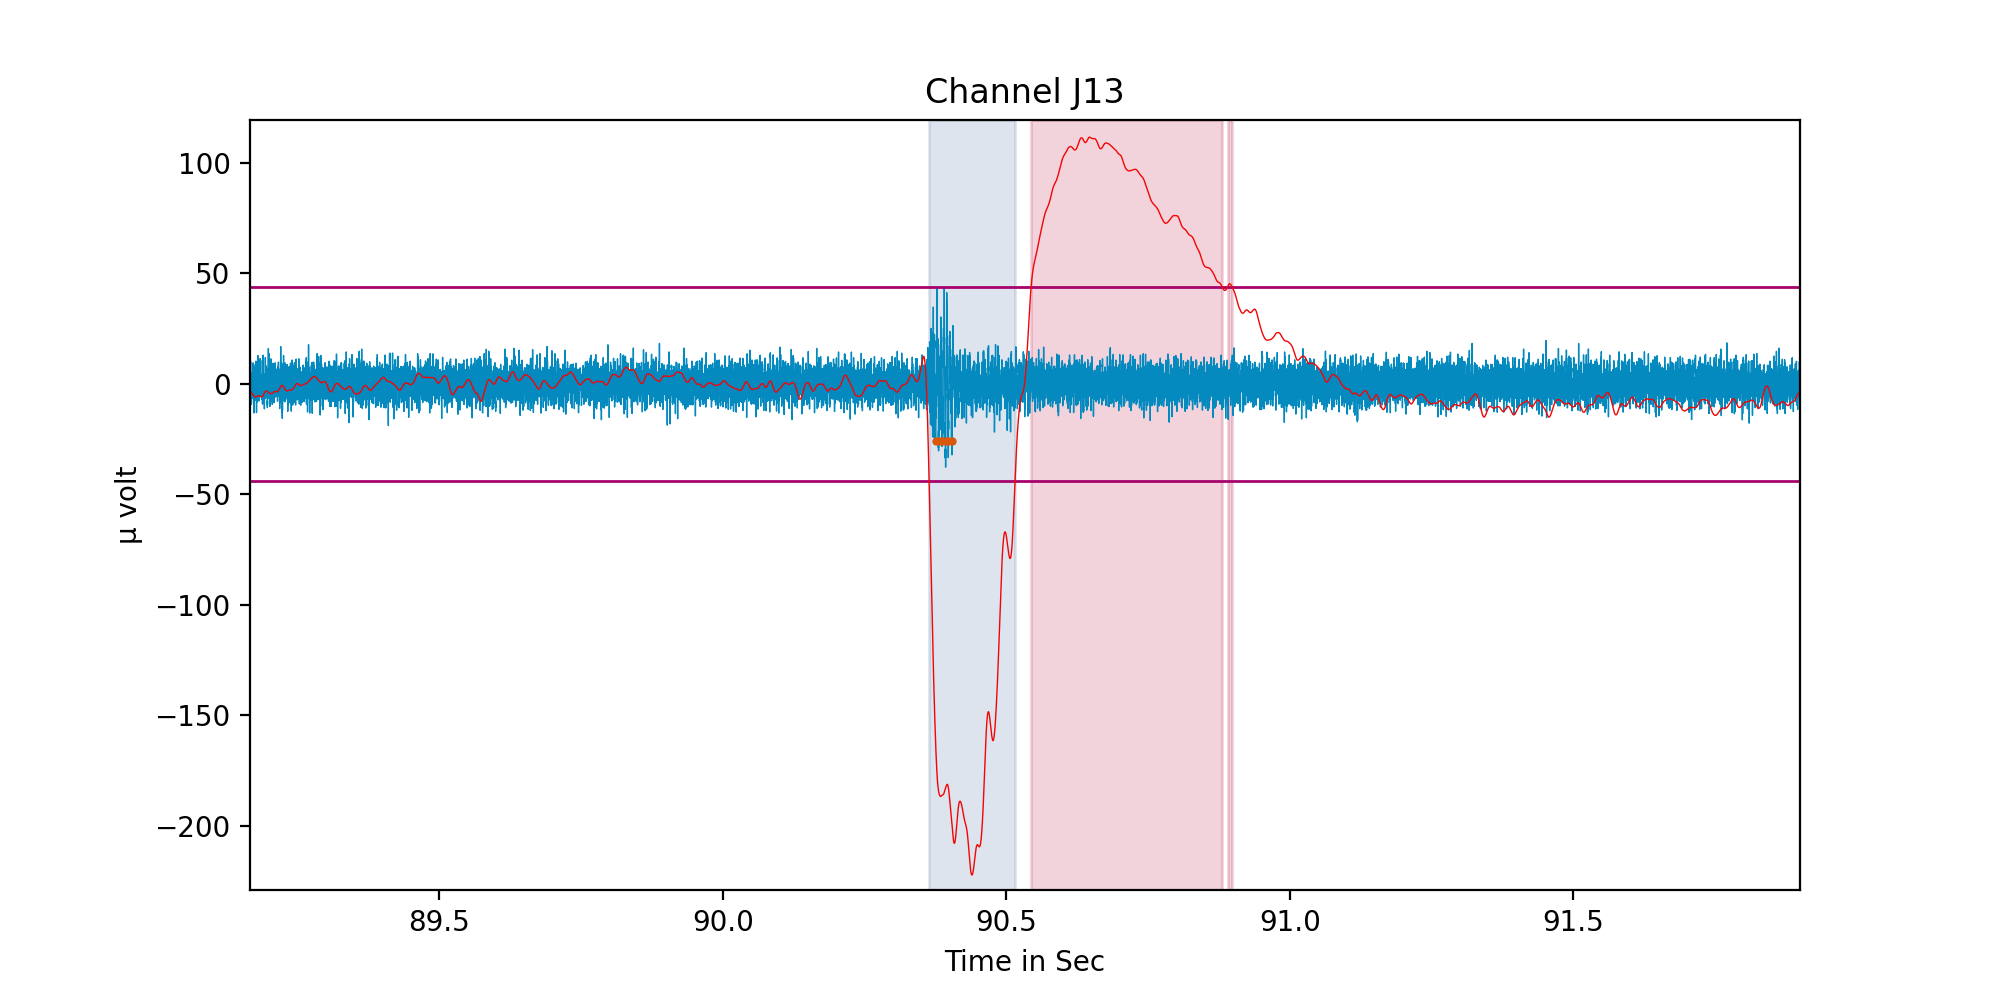

In [55]:
# plot the lfps

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plt.plot(time_in_sec, bandpassfilteredsignal, c="#048ABF", linewidth = 0.5)
#ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [lfp_mean, lfp_mean], c="#297373", lw=1)
ax = plt.plot(spikes*tick*scale_factor_for_second, [threshold-1]*(spikes*tick*scale_factor_for_second).shape[0], 'ro', ms=2, c="#D9580D")
ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [lfp_threshold, lfp_threshold], c="#A6036D", lw=1)
ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [-lfp_threshold, -lfp_threshold], c="#A6036D", lw=1)
ax = plt.plot(time_in_sec, butter_lowpass_filtered_signal, c='#F20505', linewidth=0.5)
for i in down_cross:
    ax = plt.axvspan(i[0], i[1], color='#5D7CA6', alpha=0.2)
for i in up_cross:
    ax = plt.axvspan(i[0], i[1], color='#BF214B', alpha=0.2)

ax = plt.title('Channel %s' %channellabel)
ax = plt.xlabel('Time in Sec')
ax = plt.ylabel('µ volt')

## Filtering for simultaneous events (GPT 4 supped)


In [56]:
def find_simultaneous_events(channel_events, min_overlap_channels=2, time_tolerance=0.01):
    """
    channel_events: A list of lists, where each inner list contains the events (start, stop) for a single channel.
    min_overlap_channels: Minimum number of channels that must have simultaneous events.
    time_tolerance: Maximum time difference between event starts (in seconds) to consider them simultaneous.
    """

    simultaneous_events = []

    # Compare all pairs of channels
    for i, events_a in enumerate(channel_events[:-1]):
        for j, events_b in enumerate(channel_events[i + 1:]):
            for event_a in events_a:
                for event_b in events_b:
                    # Check if events are simultaneous
                    if abs(event_a[0] - event_b[0]) <= time_tolerance:
                        # Check if the event pair is already in the list
                        existing_event = [e for e in simultaneous_events if e[0] == event_a and e[1] == event_b]
                        if existing_event:
                            existing_event[0][2] += 1  # Increment the overlap counter
                        else:
                            simultaneous_events.append([event_a, event_b, 2])  # Initialize the overlap counter

    # Keep only events with at least min_overlap_channels simultaneous occurrences
    simultaneous_events = [event for event in simultaneous_events if event[2] >= min_overlap_channels]

    return simultaneous_events


In [57]:
def calculate_baseline_std(lfp_data, percentile=5):
    """
    Calculate the standard deviation of the baseline LFP signal.
    :param lfp_data: numpy array containing the LFP data for a single channel
    :param percentile: percentile value to estimate the baseline (default: 5)
    :return: standard deviation of the baseline signal
    """
    baseline = np.percentile(lfp_data, percentile)
    baseline_std = np.std(lfp_data[lfp_data <= baseline])
    return baseline_std


In [58]:
def detect_events(lfp_data, baseline_std, threshold_multiplier=3):
    """
    Detect events in the LFP data based on a threshold.
    :param lfp_data: numpy array containing the LFP data for a single channel
    :param baseline_std: standard deviation of the baseline signal
    :param threshold_multiplier: multiplier for the baseline standard deviation (default: 3)
    :return: list of event start and end indices
    """
    threshold = threshold_multiplier * baseline_std
    events = []
    event_start = None

    for i, value in enumerate(lfp_data):
        if abs(value) >= threshold:
            if event_start is None:
                event_start = i
        else:
            if event_start is not None:
                event_end = i
                events.append((event_start, event_end))
                event_start = None

    # If an event is ongoing at the end of the data, add it to the list
    if event_start is not None:
        events.append((event_start, len(lfp_data) - 1))

    return events


In [59]:
# Calculate the baseline standard deviation
baseline_std = calculate_baseline_std(butter_lowpass_filtered_signal)

# Detect events
events = detect_events(butter_lowpass_filtered_signal, baseline_std)


In [60]:
events

[(1563628, 1563845),
 (2259228, 2262221),
 (2265101, 2267440),
 (2664865, 2667666)]

<IPython.core.display.Javascript object>


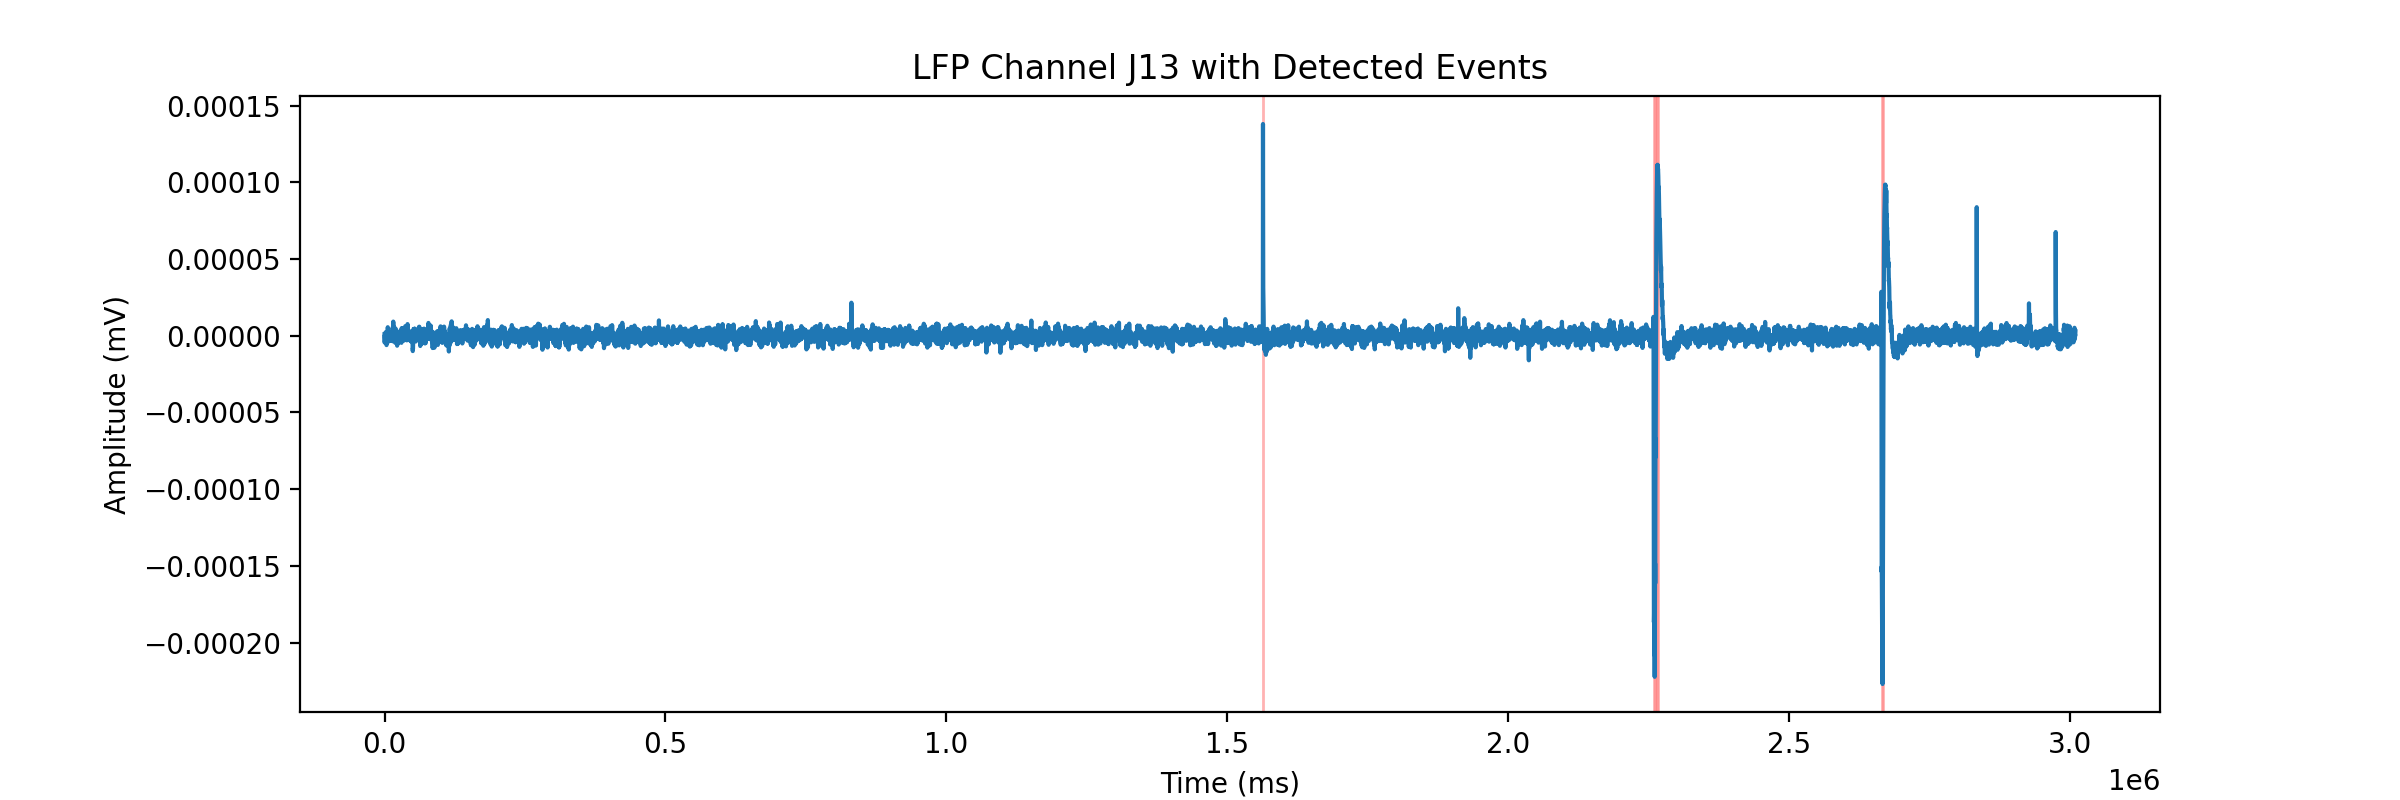

In [61]:
def plot_lfp_with_events(channel_data, events, fs, channel_number):
    plt.figure(figsize=(12, 4))
    plt.plot(channel_data / 1e6)
    
    for event in events:
        plt.axvspan(event[0], event[1], color='red', alpha=0.3)
    
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (mV)')
    plt.title(f'LFP Channel {channel_number} with Detected Events')
    plt.show()

# Plot the LFP data with detected events
plot_lfp_with_events(channel_data=butter_lowpass_filtered_signal, events=events, fs=fs, channel_number=channellabel)


In [62]:
fs

25000

In [ ]:
all_channel_lowpass_signal_list = []
number = 0
lowpass_dic = {}
signal_in_uV_dic = {}
for i in labellist:
    number += 1
    print(str(number), ' of 252')
    channellabel = i
    channel_idx=label_number_dic[i]
    signal_in_uV, time_in_sec, sampling_frequency, scale_factor_for_second = get_MEA_Signal(analog_stream=analog_stream_0,
                                                                                            channel_idx=channel_idx)
    butter_lowpass_filtered_signal = butter_lowpass_filter(signal_in_uV, cutoff, fs, order)
    lowpass_dic[i] = butter_lowpass_filtered_signal
    signal_in_uV_dic[i] = signal_in_uV
    all_channel_lowpass_signal_list.append(butter_lowpass_filtered_signal)

# Convert the list of arrays into a numpy array
array_of_arrays = np.stack(all_channel_lowpass_signal_list)

# Calculate the element-wise mean along axis 0 (rows)
mean_lfp_all_channels = np.mean(array_of_arrays, axis=0)
mean_abs_lfp_all_channels = np.mean(np.abs(array_of_arrays, axis = 0), axis=0)

1  of 252
2  of 252
3  of 252
4  of 252
5  of 252
6  of 252
7  of 252
8  of 252
9  of 252
10  of 252
11  of 252
12  of 252
13  of 252
14  of 252
15  of 252
16  of 252
17  of 252
18  of 252
19  of 252
20  of 252
21  of 252
22  of 252
23  of 252
24  of 252
25  of 252
26  of 252
27  of 252
28  of 252
29  of 252
30  of 252
31  of 252
32  of 252
33  of 252
34  of 252
35  of 252
36  of 252
37  of 252
38  of 252
39  of 252
40  of 252
41  of 252
42  of 252
43  of 252
44  of 252
45  of 252
46  of 252
47  of 252
48  of 252
49  of 252
50  of 252
51  of 252
52  of 252
53  of 252
54  of 252
55  of 252
56  of 252
57  of 252
58  of 252
59  of 252
60  of 252
61  of 252
62  of 252
63  of 252
64  of 252
65  of 252
66  of 252
67  of 252
68  of 252
69  of 252
70  of 252
71  of 252
72  of 252
73  of 252
74  of 252
75  of 252
76  of 252
77  of 252
78  of 252
79  of 252
80  of 252
81  of 252
82  of 252
83  of 252
84  of 252
85  of 252
86  of 252
87  of 252
88  of 252
89  of 252
90  of 252
91  of 252
92  of 2

In [1]:
mean_abs_lfp_all_channels = np.mean(array_of_arrays,
                                    axis=0)

NameError: name 'np' is not defined

In [ ]:
all_channel_signal_list = []
for key in signal_in_uV_dic:
    all_channel_signal_list.append(signal_in_uV_dic[key])
    

In [ ]:
array_of_arrays_normal_signal = np.stack(all_channel_signal_list)
mean_signal_all_channels = np.mean(array_of_arrays_normal_signal, axis=0)

<IPython.core.display.Javascript object>


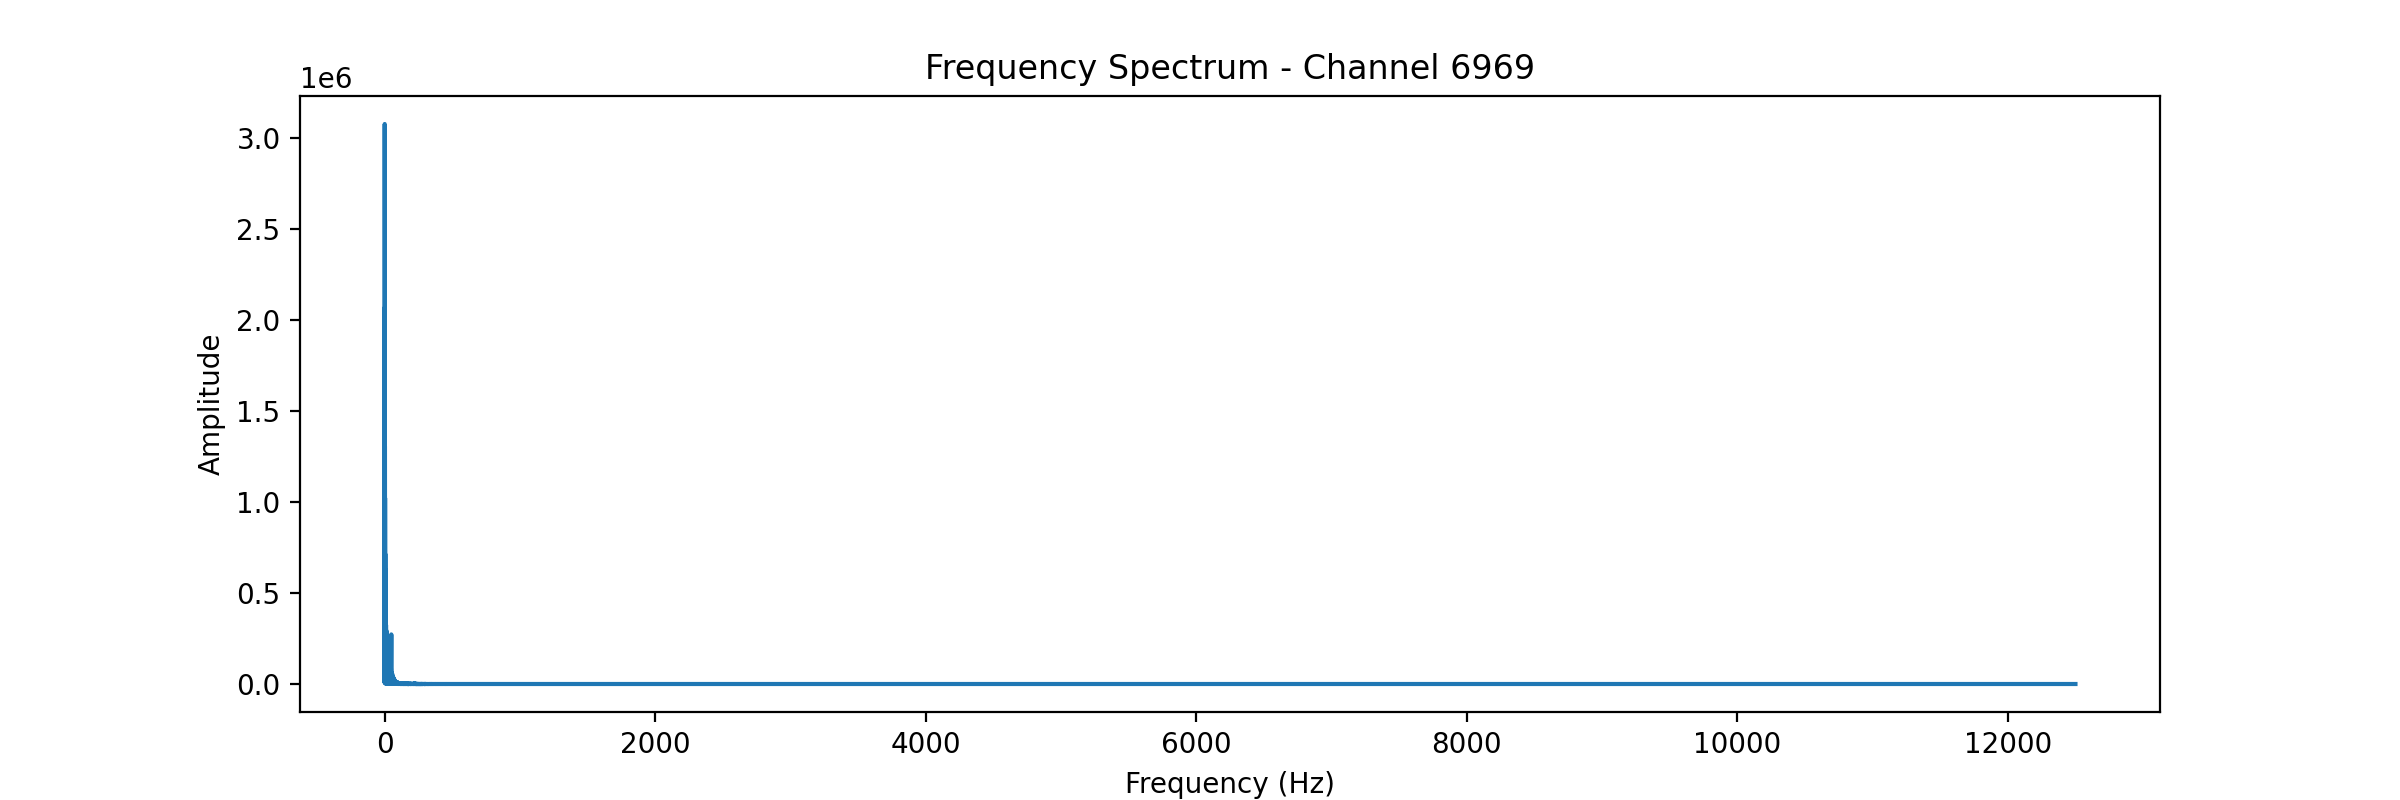

In [56]:
import numpy as np
import matplotlib.pyplot as plt

def plot_frequency_spectrum(lfp_data, fs, channel_number):
    # Calculate the FFT
    fft_data = np.fft.fft(lfp_data)
    freqs = np.fft.fftfreq(lfp_data.size, d=1/fs)
    
    # Keep only positive frequencies
    positive_freqs = freqs > 0
    fft_data = fft_data[positive_freqs]
    freqs = freqs[positive_freqs]
    
    # Plot the frequency spectrum
    plt.figure(figsize=(12, 4))
    plt.plot(freqs, np.abs(fft_data))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.title(f'Frequency Spectrum - Channel {channel_number}')
    plt.show()


# Plot the frequency spectrum
plot_frequency_spectrum(lfp_data=lowpass_dic['J13'], fs=fs, channel_number = 6969)


<IPython.core.display.Javascript object>


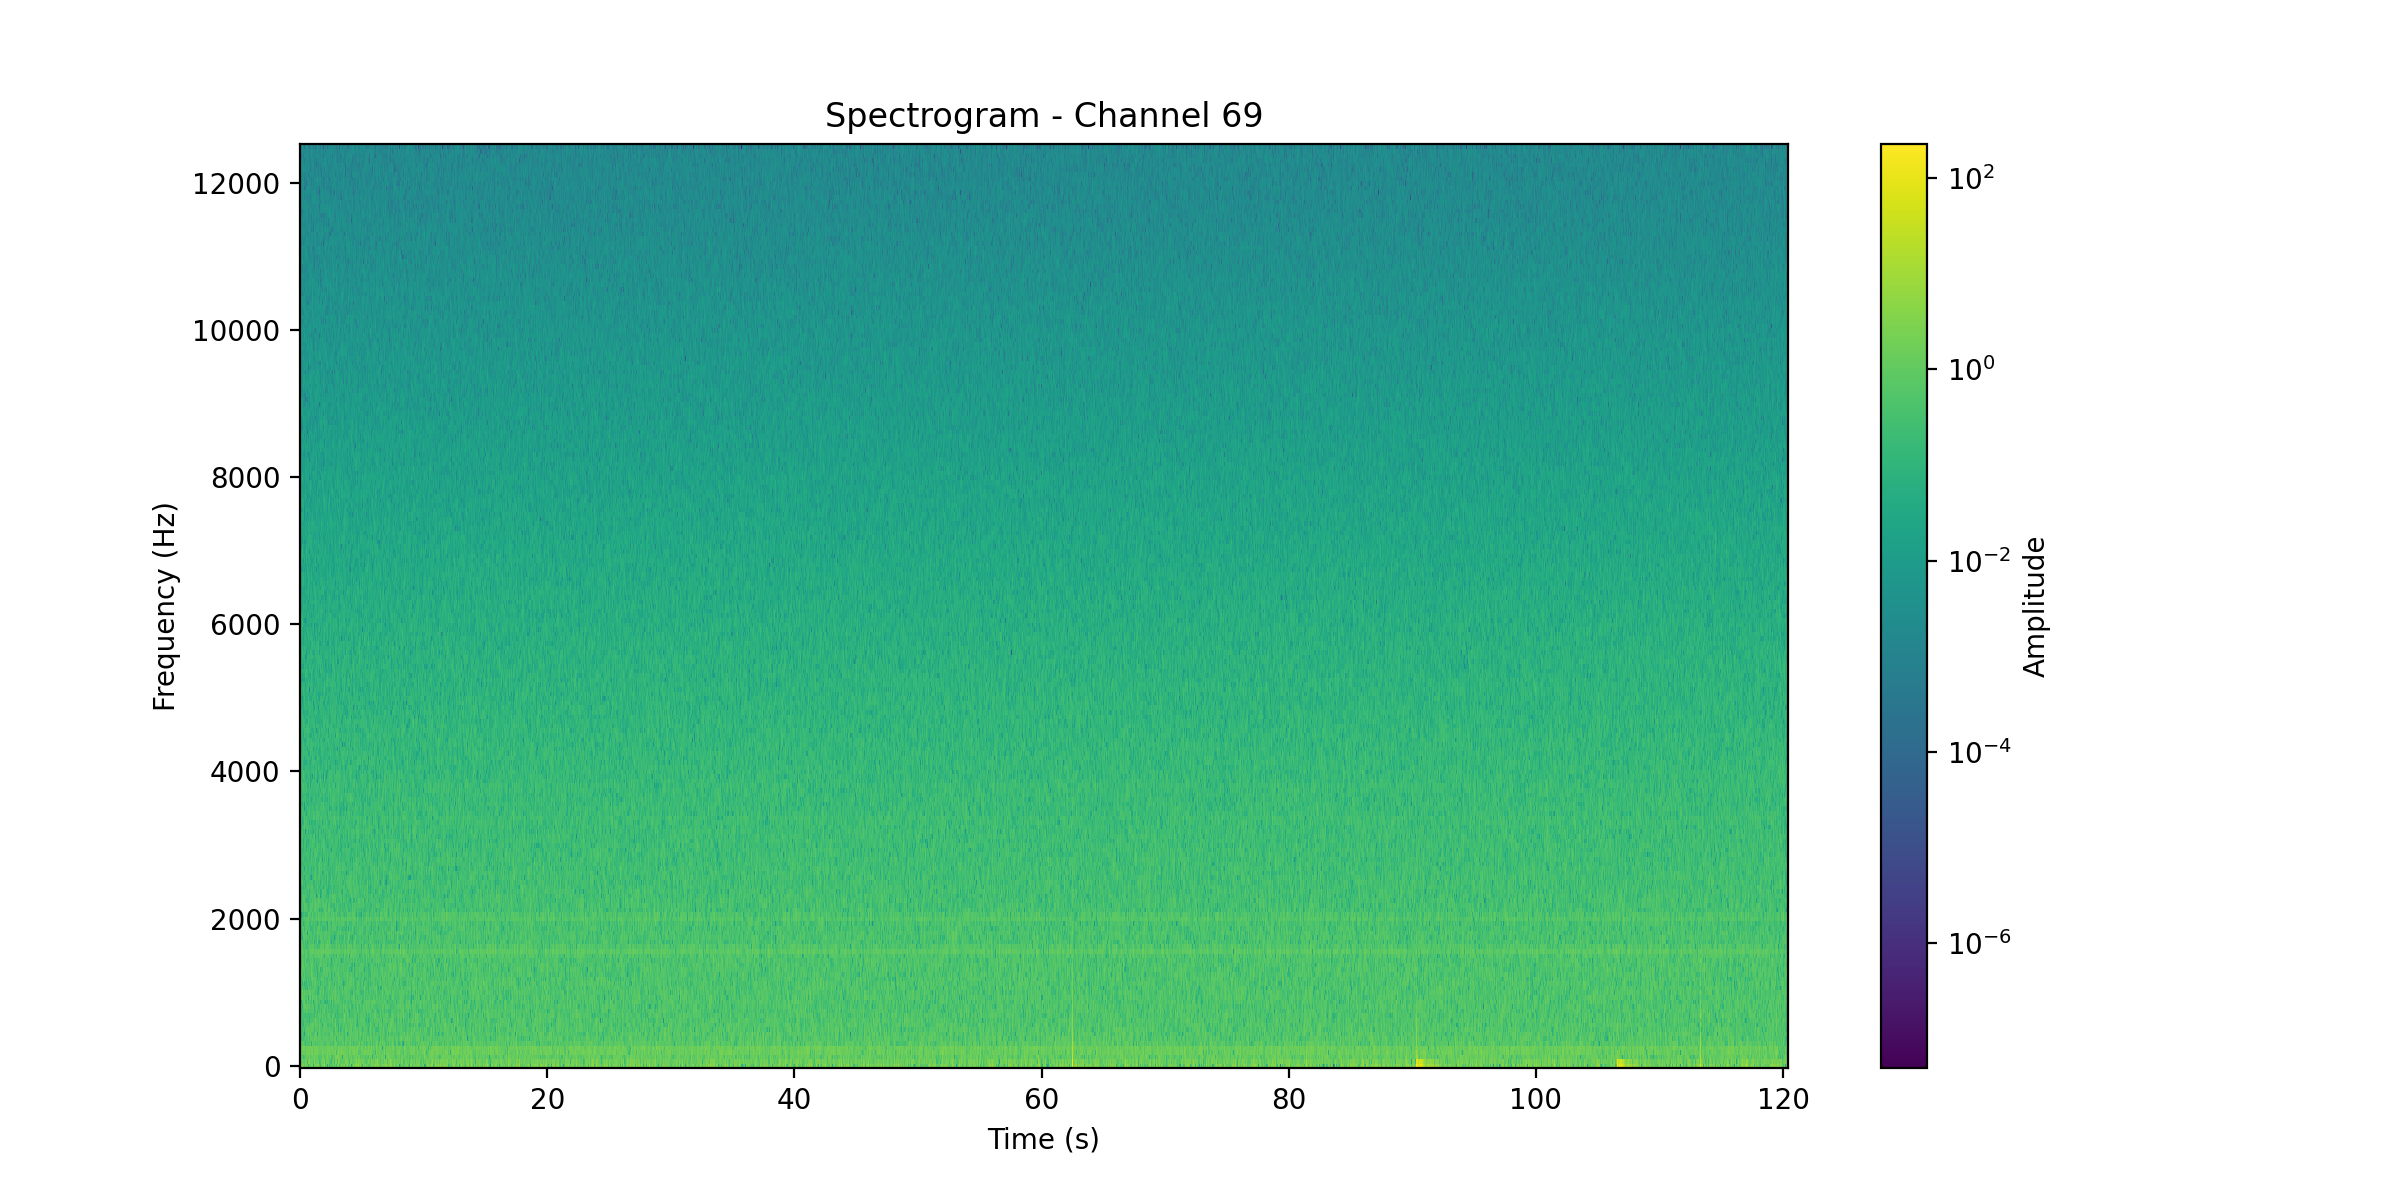

In [59]:
import scipy.signal as signal
import matplotlib.colors as colors

def plot_spectrogram(lfp_data, fs, channel_number):
    # Calculate the STFT
    f, t, Zxx = signal.stft(lfp_data, fs, nperseg=400, noverlap=300)
    
    log_norm = colors.LogNorm(vmin=np.min(np.abs(Zxx)), vmax=np.max(np.abs(Zxx)))
    
    # Plot the spectrogram
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(t, f, np.abs(Zxx), shading='auto', cmap='viridis', norm=log_norm)
   # plt.specgram
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.ylim([0, 300])  # Limit the frequency range to 0-300 Hz
    plt.title(f'Spectrogram - Channel {channel_number}')
    plt.colorbar(label='Amplitude')
    plt.show()

# Plot the spectrogram
plot_spectrogram(signal_in_uV_dic['J13'], fs, channel_number=69)


In [60]:
plt.specgram(signal_in_uV_dic['J13'], Fs=fs)

(array([[1.77535964e-01, 9.14166046e-02, 1.34641518e-02, ...,
         3.46769106e-04, 1.58160259e-03, 5.87167345e-02],
        [1.37146779e-01, 6.68382159e-02, 2.21003845e-02, ...,
         2.89439802e-03, 1.76760677e-02, 7.45370240e-02],
        [3.91991991e-02, 4.41302053e-02, 3.57240970e-02, ...,
         1.78781017e-02, 8.70688185e-02, 2.18681456e-02],
        ...,
        [1.85855466e-07, 1.06891655e-07, 1.81303513e-07, ...,
         1.81673982e-07, 9.67146684e-08, 6.49989210e-08],
        [1.41524214e-07, 8.97334625e-08, 3.52055769e-08, ...,
         1.98795937e-07, 1.59054219e-08, 1.03302241e-08],
        [6.33699780e-09, 1.36538011e-07, 4.26356903e-10, ...,
         4.77182910e-08, 1.12684323e-08, 9.94722406e-10]]),
 array([    0.     ,    97.65625,   195.3125 ,   292.96875,   390.625  ,
          488.28125,   585.9375 ,   683.59375,   781.25   ,   878.90625,
          976.5625 ,  1074.21875,  1171.875  ,  1269.53125,  1367.1875 ,
         1464.84375,  1562.5    ,  1660.15625,

In [79]:
plt.subplot(211)

 

plt.plot(signal_in_uV_dic['J13'])

plt.xlabel('Sample')

plt.ylabel('Amplitude')

 

plt.subplot(212)

plt.specgram(signal_in_uV_dic['J13'], Fs=fs)
plt.xlabel('Time')

plt.ylabel('Frequency')

 

plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


In [77]:
lfp_mean = np.mean(mean_abs_lfp_all_channels)
lfp_std = np.std(mean_abs_lfp_all_channels) 
lfp_threshold = lfp_std * 3

In [78]:
down_cross, up_cross = lfp_crossing_detection(mean_abs_lfp_all_channels, lfp_threshold)

In [ ]:
# plot the lfps

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#ax = plt.plot(time_in_sec, bandpassfilteredsignal, c="#048ABF", linewidth = 0.5)
#ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [lfp_mean, lfp_mean], c="#297373", lw=1)
#ax = plt.plot(spikes*tick*scale_factor_for_second, [threshold-1]*(spikes*tick*scale_factor_for_second).shape[0], 'ro', ms=2, c="#D9580D")
ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [lfp_threshold, lfp_threshold], c="#A6036D", lw=1)
ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [-lfp_threshold, -lfp_threshold], c="#A6036D", lw=1)
ax = plt.plot(time_in_sec, mean_abs_lfp_all_channels, c='#F20505', linewidth=0.5)
for i in down_cross:
    ax = plt.axvspan(i[0], i[1], color='#5D7CA6', alpha=0.2)
for i in up_cross:
    ax = plt.axvspan(i[0], i[1], color='#BF214B', alpha=0.2)

ax = plt.title('Mean_LFP_all_channels')
ax = plt.xlabel('Time in Sec')
ax = plt.ylabel('µ volt')

In [80]:
up_cross

[(0.0, 0.00028),
 (7.355119999999999, 7.3605599999999995),
 (28.194319999999998, 28.20064),
 (33.235, 33.25284),
 (62.538079999999994, 62.589839999999995),
 (76.44368, 76.4568),
 (77.86488, 77.872),
 (82.27395999999999, 82.28048),
 (87.25372, 87.26092),
 (87.52856, 87.53383999999998),
 (90.51932, 90.75128),
 (90.76392, 90.76704),
 (106.72688, 106.95703999999999),
 (113.35499999999999, 113.38552),
 (117.08336, 117.13768),
 (118.98448, 119.02071999999998)]

In [81]:
down_cross

[(62.8306, 62.83468),
 (90.3758, 90.48704),
 (106.58932, 106.68464),
 (113.40268, 113.46368)]

In [66]:
def get_mean_lfp_dictionary(dictionary_lowpass_filtered, start, stop, scale_factor_for_second, tick):

    start_index = int(start/(scale_factor_for_second*tick))
    stop_index = int(stop/(scale_factor_for_second*tick))
    
    lowpass_mean_dic = {}
    for key in dictionary_lowpass_filtered:
        cutted_array = dictionary_lowpass_filtered[key][start_index:int((stop_index+1))]
        lowpass_mean_dic[key] = np.mean(cutted_array)
    
    return lowpass_mean_dic
    

In [67]:
lmd = get_mean_lfp_dictionary(dictionary_lowpass_filtered=lowpass_dic, start = 90.5,
                             stop = 91,
                                scale_factor_for_second=scale_factor_for_second, tick=tick)

In [255]:
lmd

{'G13': 17.396564636755173,
 'G12': 7.811826569563696,
 'F16': 8.806776433433637,
 'F15': 36.616900755450416,
 'F14': 9.732517148682037,
 'F13': 5.882379984845707,
 'F12': 3.9040122734980556,
 'E16': 4.057632372920084,
 'E15': 8.054306438036527,
 'E14': 3.3183834191516817,
 'E13': 2.4883682398413076,
 'G11': 5.385773196575702,
 'D16': 1.261024269437213,
 'D15': 2.715654466824406,
 'D14': 1.5598718193029741,
 'H9': 11.777882460546781,
 'F11': 2.4080030354624262,
 'C16': 2.731598221801744,
 'C15': 0.11802602418412843,
 'D13': -0.04026975083355309,
 'B16': 0.051988810193548195,
 'B15': -0.7136904517544141,
 'C14': 0.5672823819405987,
 'A15': 0.5952061285674044,
 'A14': 0.472158860353834,
 'B14': 0.16037301773969934,
 'G10': 4.0317654132193645,
 'E12': 1.5896424867767394,
 'B13': -2.2081806422536165,
 'C13': 1.8673974923408645,
 'F10': 0.755668526385139,
 'A13': -0.01588131411050673,
 'C12': -0.20762298538645763,
 'D12': 1.2407837956674512,
 'A12': 0.3284611575218747,
 'B12': -1.5913576612

In [256]:
# next we plot this on a mea array:

mea_array=np.empty((16,16,))
mea_array[:]=np.nan
columnlist =['A','B','C','D','E','F','G','H','J','K','L','M','N','O','P','R']
df = pd.DataFrame(data=mea_array,columns=columnlist)
df.index+=1

df1 = pd.DataFrame(data=mea_array,columns=columnlist)
df1.index+=1

df2 = pd.DataFrame(data=mea_array,columns=columnlist)
df2.index+=1

df3 = pd.DataFrame(data=mea_array,columns=columnlist)
df3.index+=1

In [69]:
# function to fill the dataframe with the 

def get_dict_values(df, dic):
    
    for i in df.columns:
        for j in range(0, 16):
            keystring = i+str(df.index[j])
            #print(keystring)
            if keystring in dic.keys():
                df.loc[df.index[j],i]=dic[keystring]
            
                
    
    return df

In [70]:
a = get_dict_values(df=df, dic=lmd)

In [71]:
a

A          B          C          D          E          F  \
1         NaN   1.610669  -2.303538   9.680652  12.222259  10.879288   
2    3.246629   4.235342   4.740275  15.904503  -2.633350   2.748420   
3    6.084268  -1.205657  -1.808726  15.061604   9.045021   6.875083   
4    4.298966  -0.537933   7.155985   7.891068   3.568534   9.942934   
5    8.134782  14.819057   4.911742  12.916105   9.644754   2.283542   
6    0.610317  15.957412  17.586575   8.167093  15.806298   5.684699   
7    3.022275   5.397271   0.388782   0.310194  11.514160   8.854782   
8    7.616385  -4.179587  -1.628515   2.600022   9.826061   6.749190   
9    9.872955   6.990831   7.582421  19.834880   6.795577  10.300299   
10   5.067139  14.144232   8.168055   1.410321   2.577735  11.072828   
11   4.995887   1.320761  11.942696  12.020996   6.174957   5.197062   
12   2.045089   3.757669   6.099308  41.881686  -0.246781   9.018263   
13   5.186619  -0.980464  10.193011   3.355879  28.002931   1.565228   
14   2.660966   7.371179  11.706692  12.212509   2.643403   1.318519   
15  25.086780   4.455614  10.916790   4.743634   3.418732  11.377180   
16        NaN   7.104520   5.964806   5.107661   9.792282   4.903378   

            G          H          J          K          L          M  \
1    6.769869   7.894412   8.042677  13.265413   7.146442  13.563586   
2    0.018074   9.941099   5.689009   2.756227   5.668797  11.302944   
3    6.690400   0.328287  16.384169  13.790591  10.611305  17.200709   
4    9.330726  -9.897296  10.873666   6.052669  15.035931   9.816999   
5    1.401969  12.749463   5.834777  26.103700   4.986854   2.244281   
6   16.033248   3.825524   3.864810   7.157544   7.508851  18.914754   
7   -1.449692   6.274137   6.205923  12.383272   9.829479   3.551959   
8    6.639007   1.465644   5.410784  11.242168   7.995521   4.120467   
9   -0.929625   6.924519   6.472547  -1.831347  14.929639   6.882721   
10  17.855380  11.916666  11.344772   4.381039   9.700360  12.310611   
11  14.519795  15.184420   9.859050  10.407040   6.661274   9.785400   
12   6.645034  11.293382   0.667821   9.615917  10.192321   6.682871   
13   0.700161   1.874117   0.986524   9.952075  -0.710120   7.003496   
14   6.646082  -1.099749  13.544548  12.293537  14.058637   4.605452   
15  58.521409  19.967322   8.459775  26.454056   8.681508   3.468635   
16   9.651363   8.212270   9.224212   6.049762  -4.384606   2.470776   

            N          O          P          R  
1   10.280984   6.522694   1.316729        NaN  
2    7.869748   2.456081   4.772251   9.906655  
3    9.027521   2.397769  14.531086   8.629843  
4    8.617646   8.529319   1.314878   9.472677  
5    5.285676   4.999832  15.363233   4.670956  
6   11.710509  10.185068  13.632521   5.270598  
7   10.707045  20.782358   8.261655   4.055740  
8    3.168597  19.999017  10.284303  10.039609  
9    7.749959   5.446385   1.894664   4.213280  
10  -1.800258  10.010731  11.239993   2.144750  
11   7.127402   5.273462   4.206286   6.039735  
12  -2.254048  15.252617  20.143801   7.615169  
13  13.371756   9.254960   3.050896  16.745247  
14   4.060876   0.715781  14.081517  19.833231  
15  13.707823  17.910593  10.006325  -1.419303  
16   1.200798   9.591871   2.523659        NaN

<IPython.core.display.Javascript object>


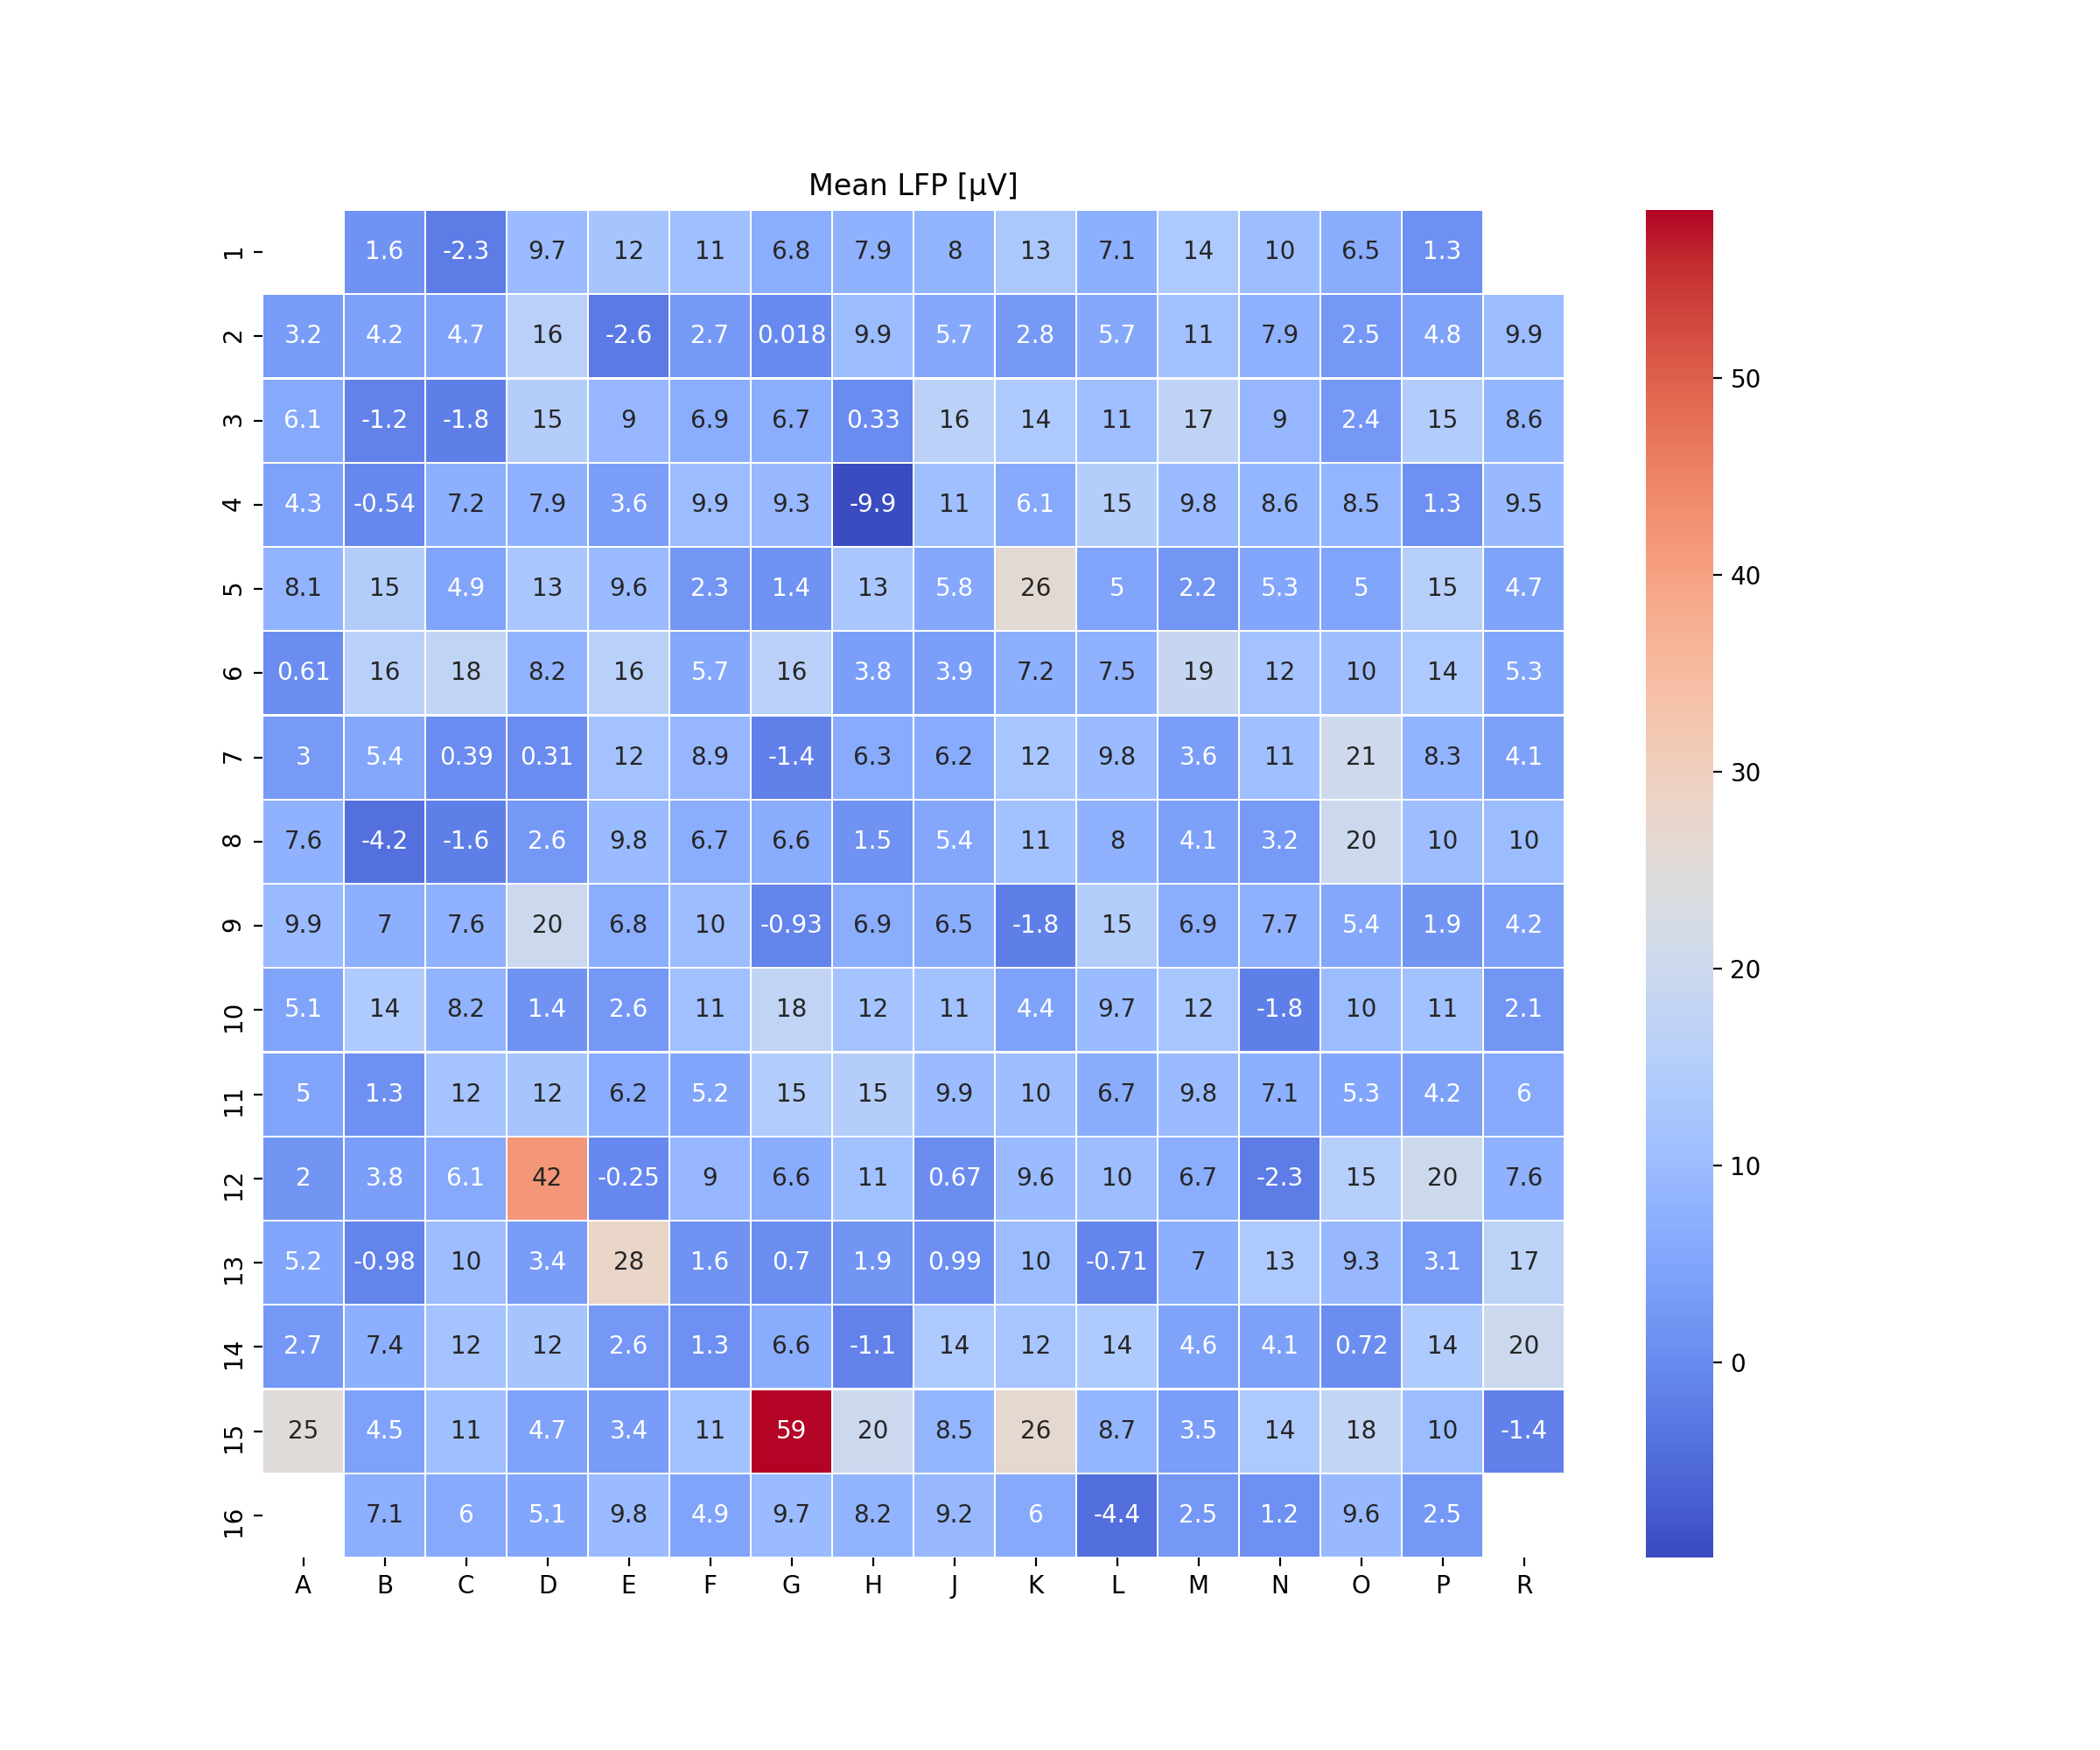

Text(0.5, 1.0, 'Mean LFP [µV]')

In [72]:
f, ax = plt.subplots(1, 1, figsize = (12,10))

sns.heatmap(a, annot=True, linewidths=.5, ax=ax, cmap="coolwarm")
ax.set_title('Mean LFP [µV]')

#f.savefig(filename+'_LFP_heatmap.pdf', dpi = 300)
#f.savefig(filename+'_LFP_heatmap.eps', dpi = 300)

<IPython.core.display.Javascript object>


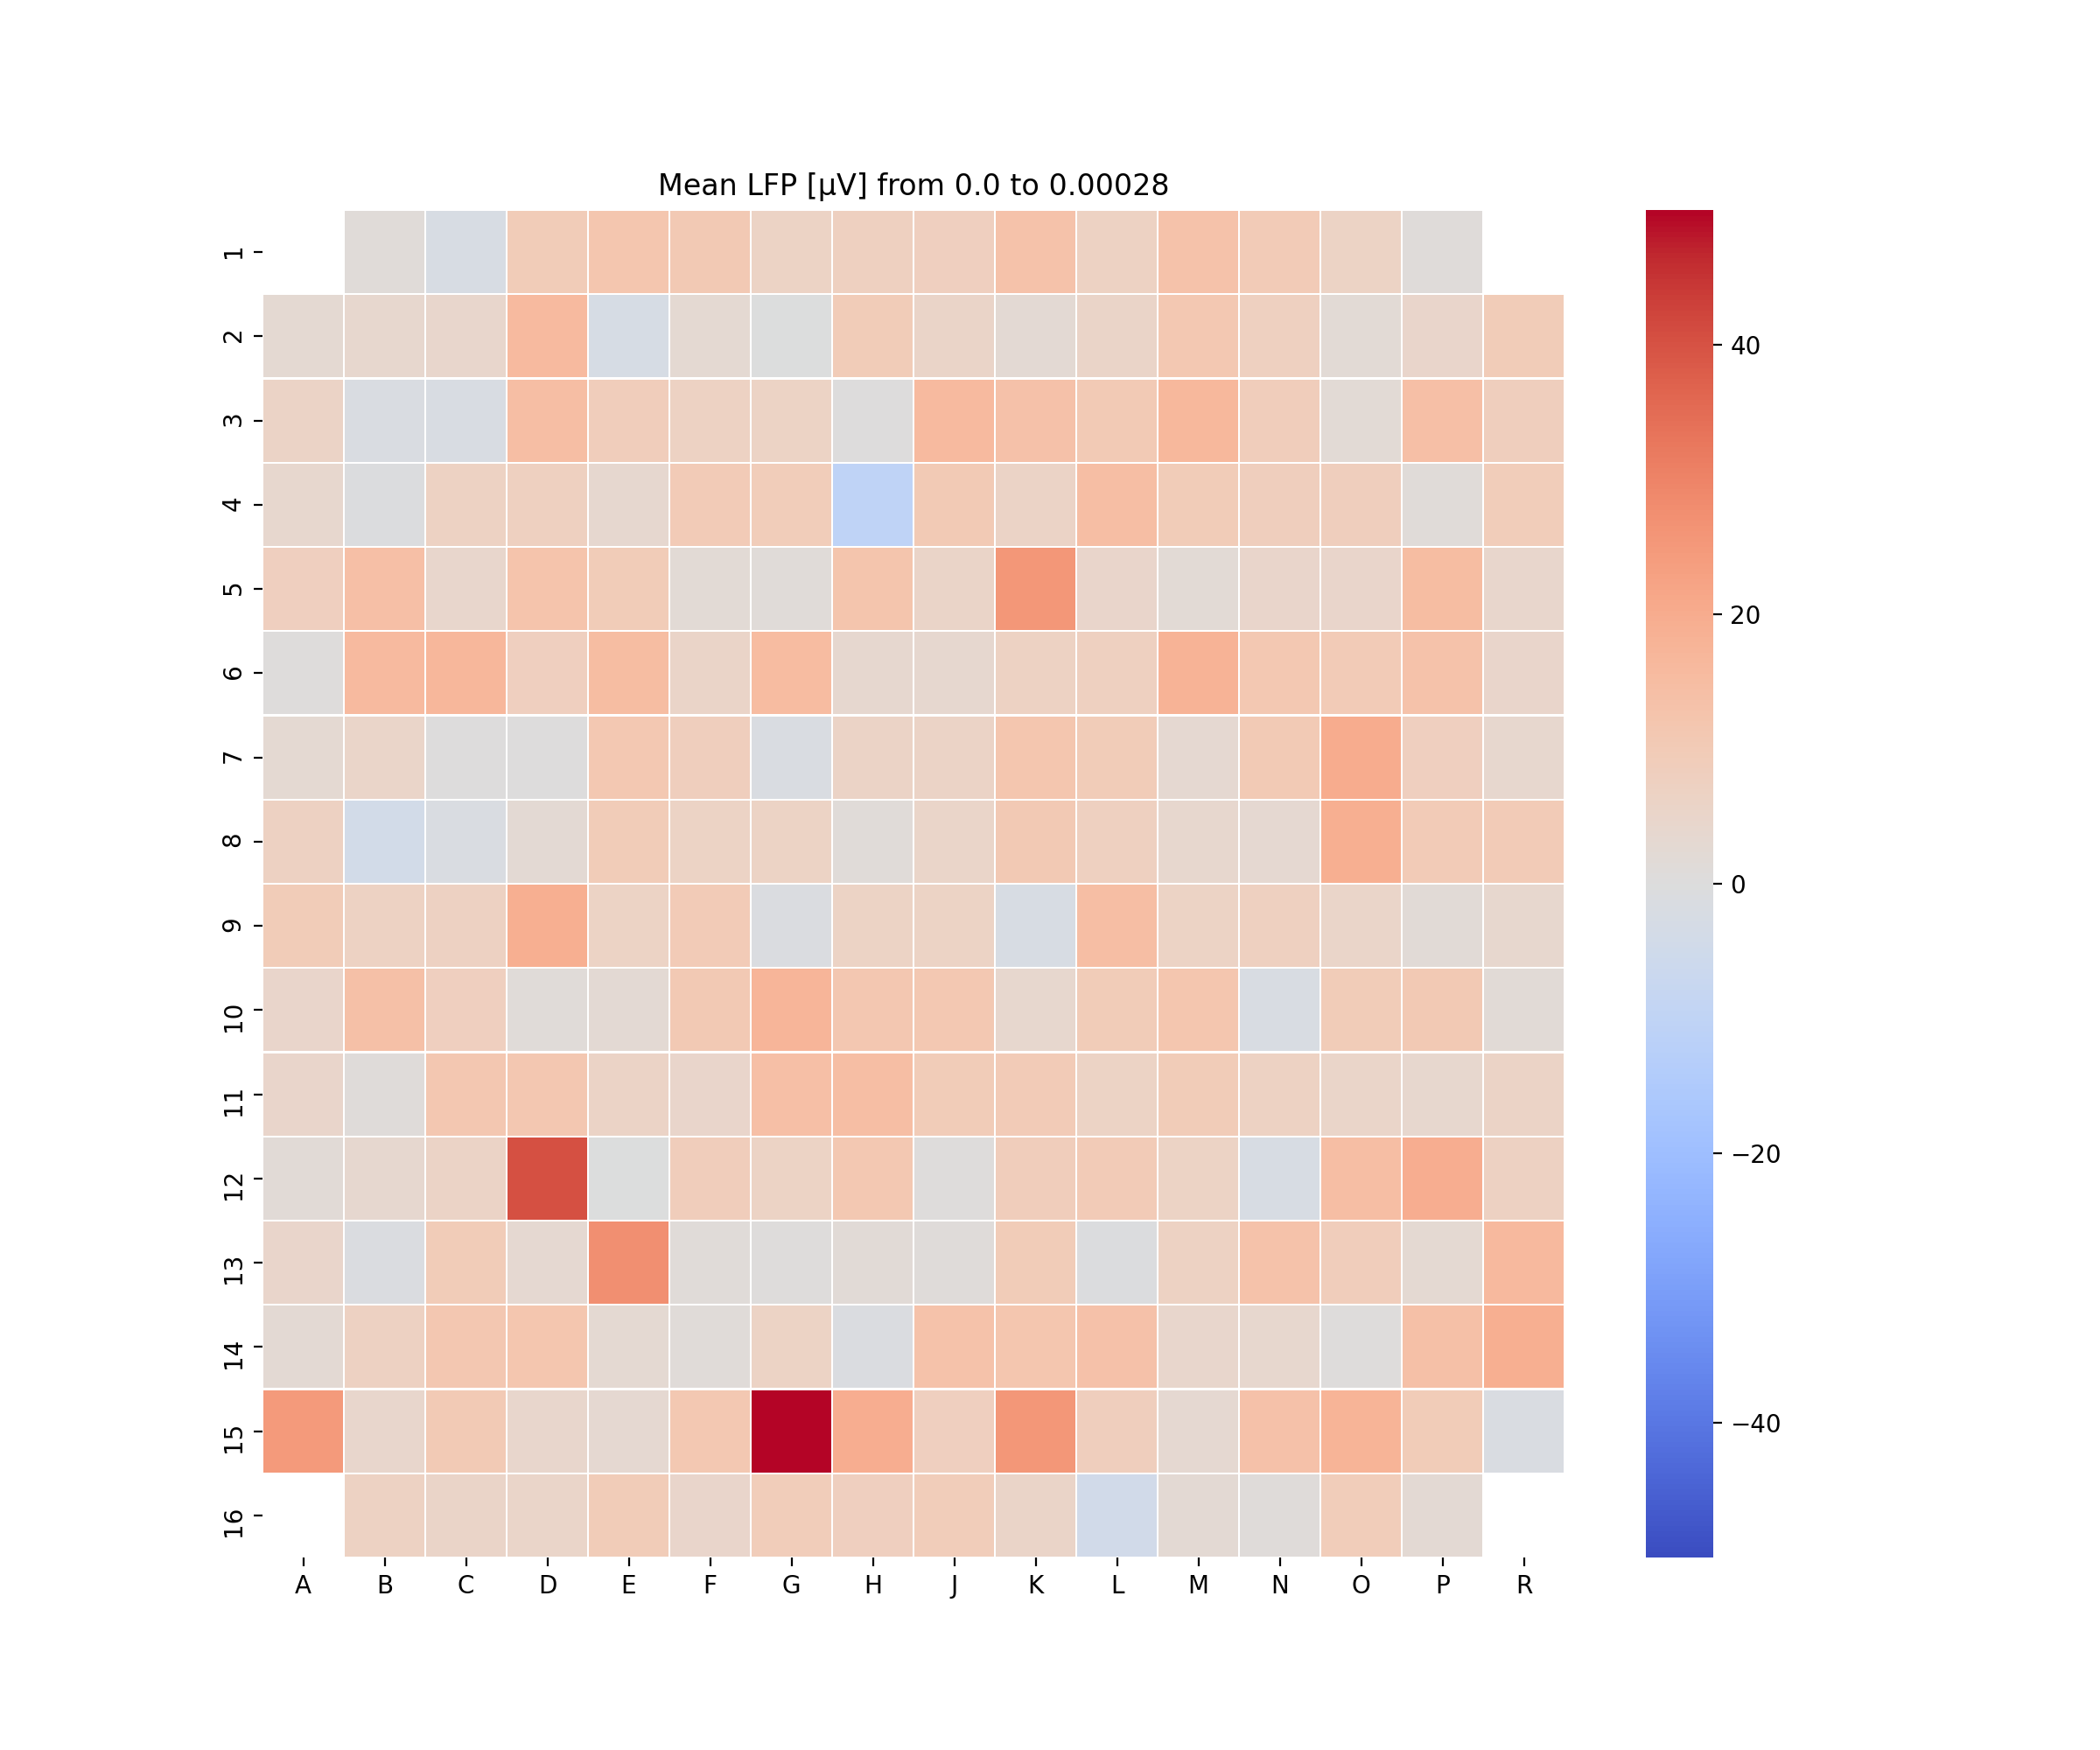

<IPython.core.display.Javascript object>


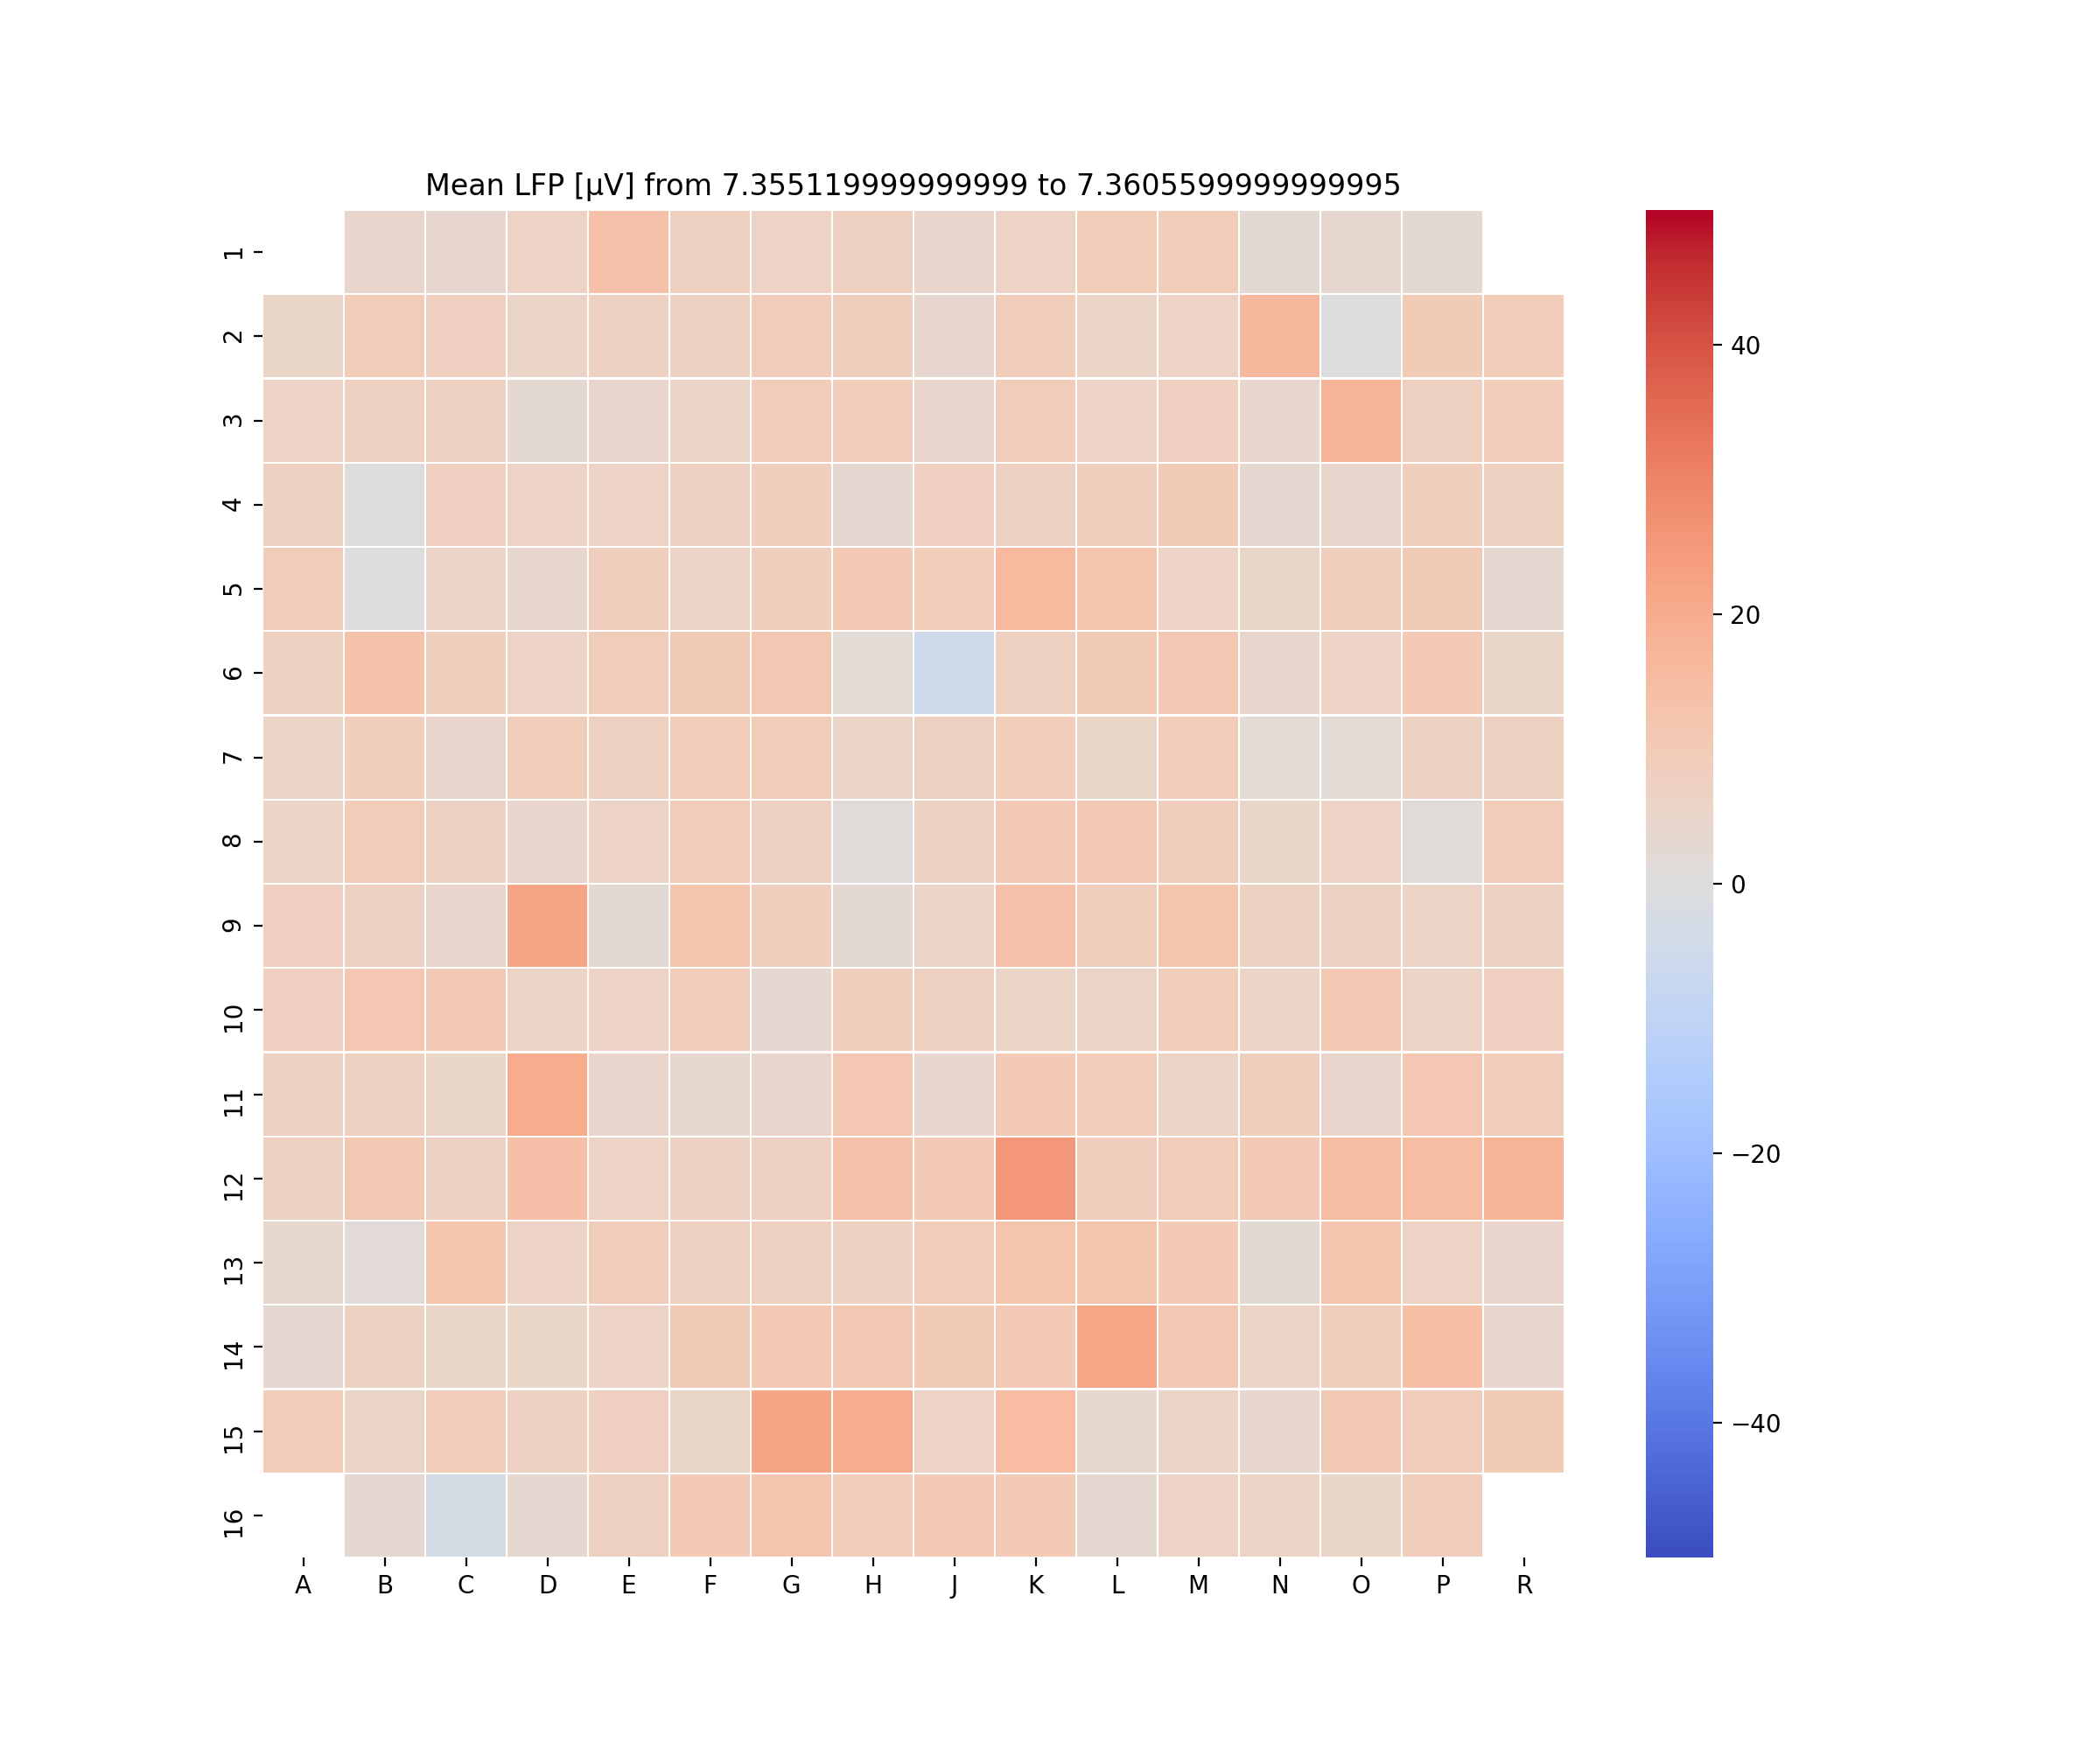

<IPython.core.display.Javascript object>


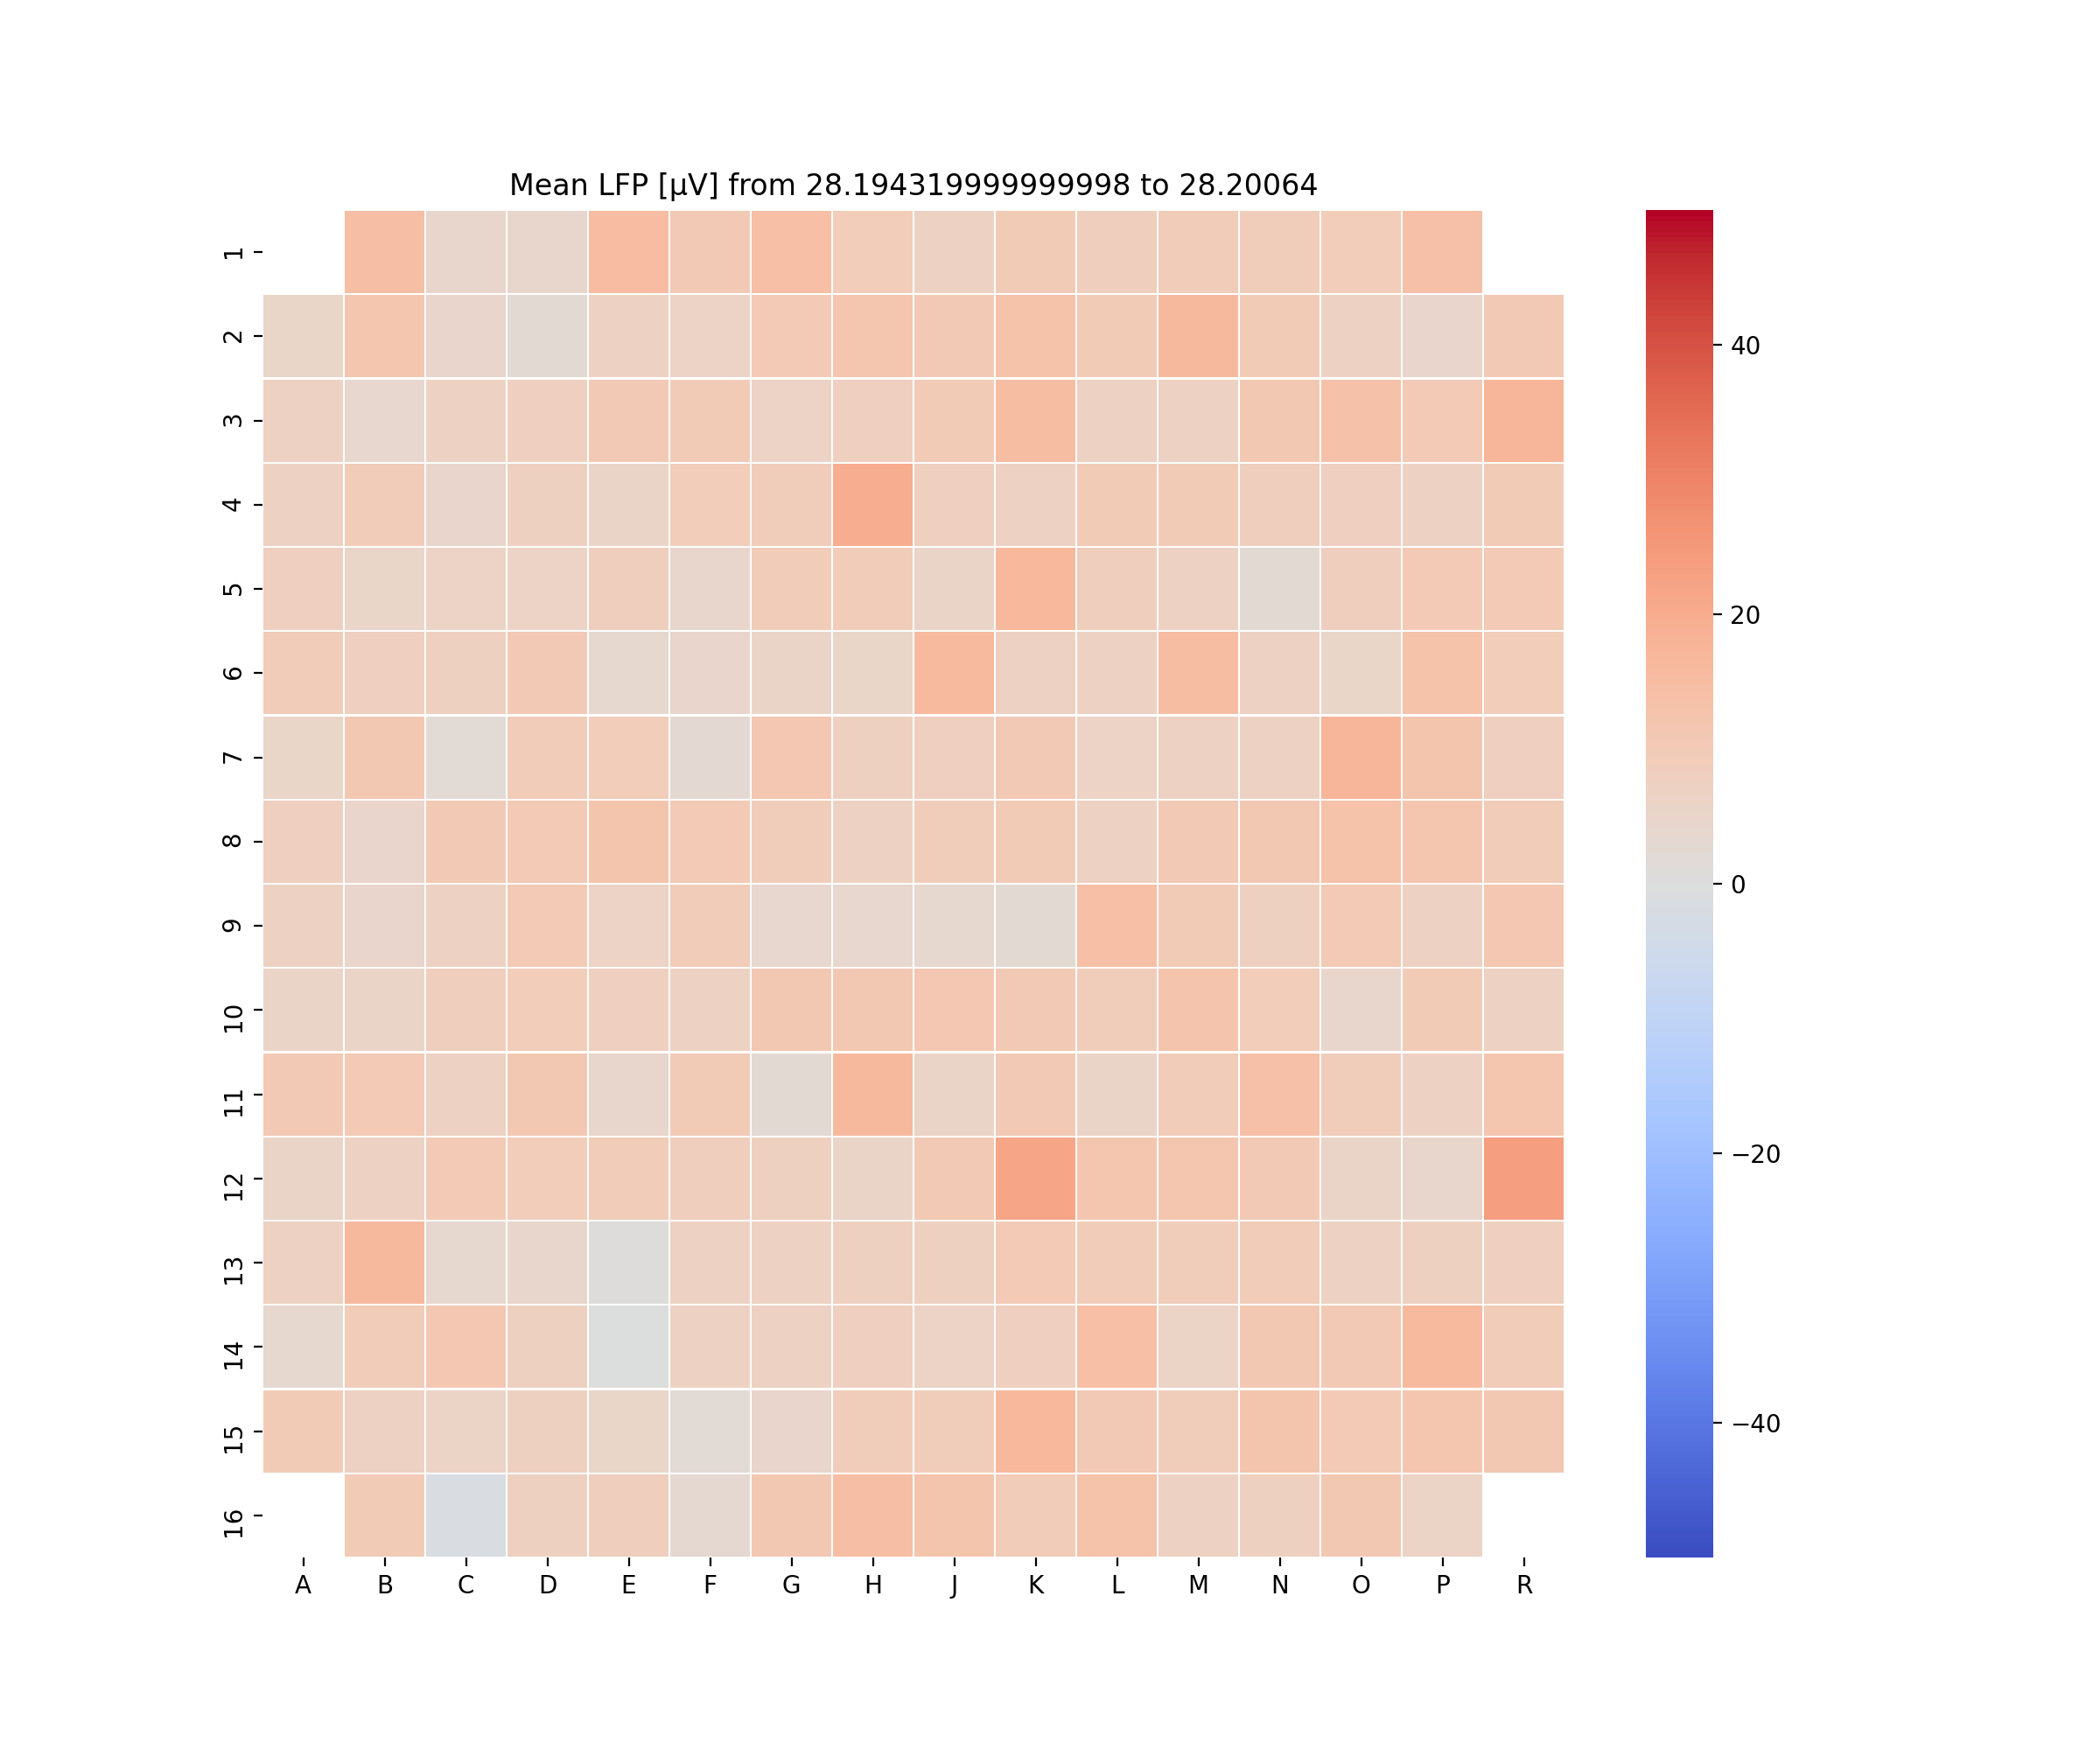

<IPython.core.display.Javascript object>


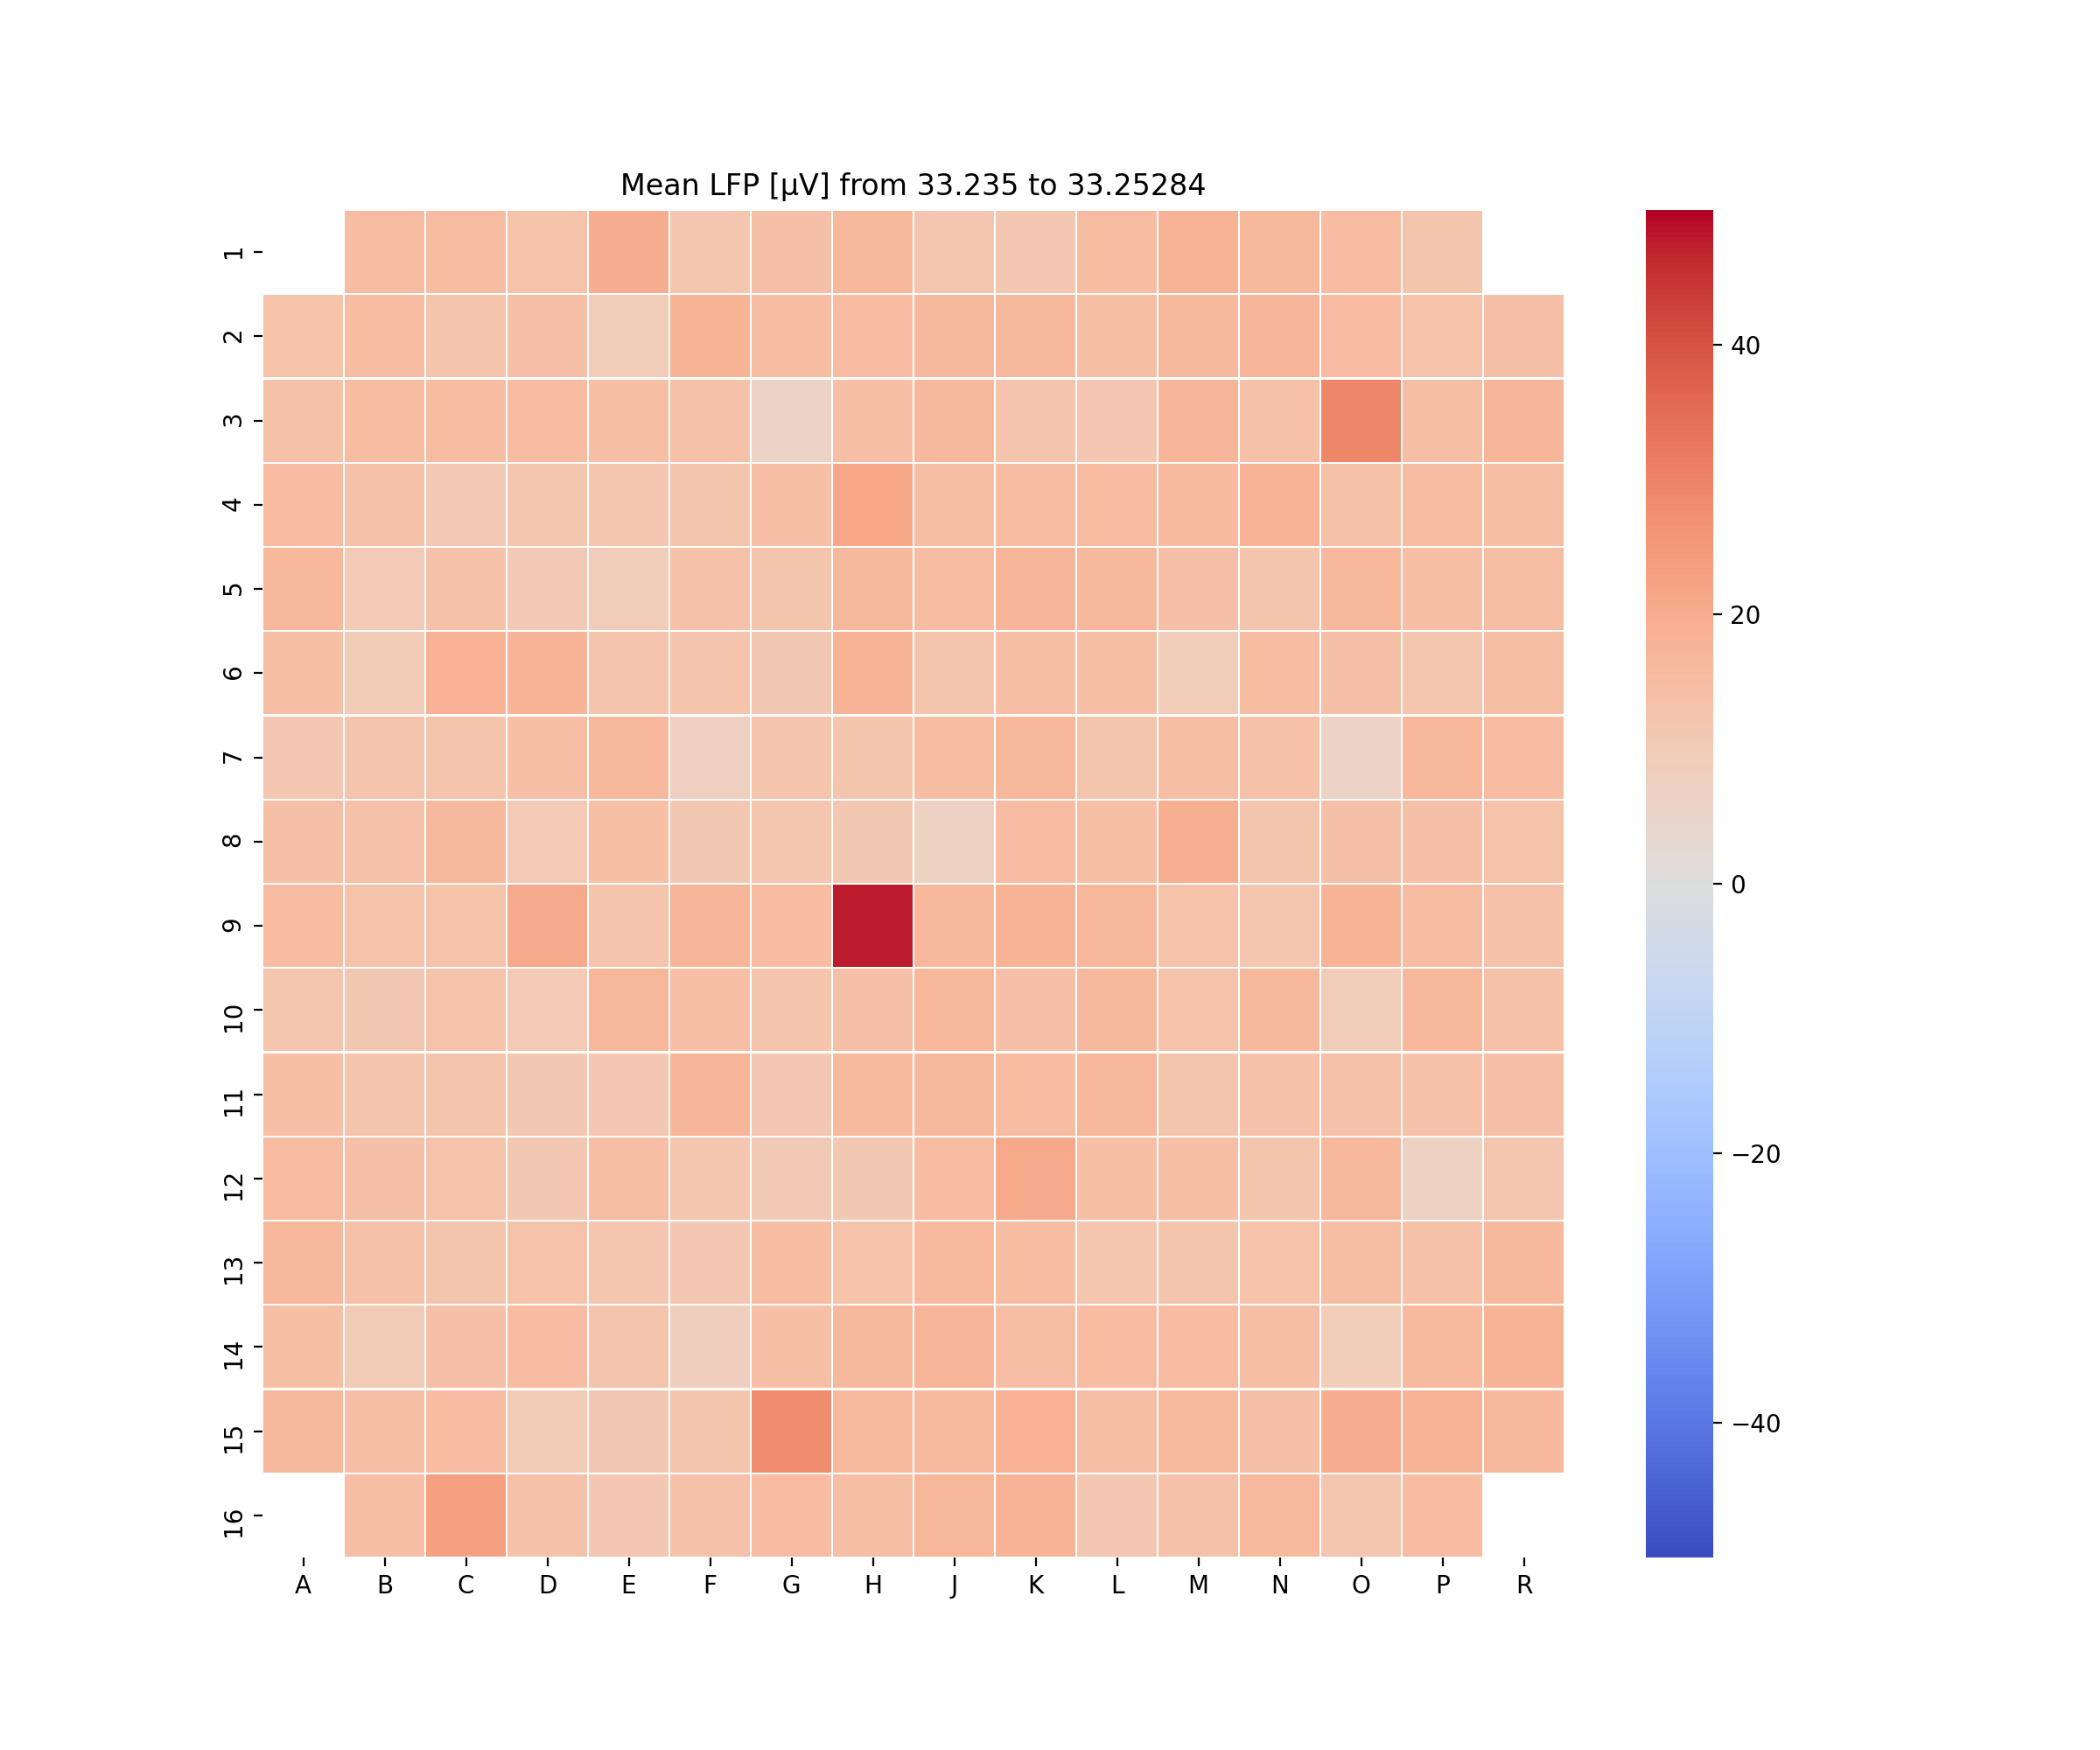

<IPython.core.display.Javascript object>


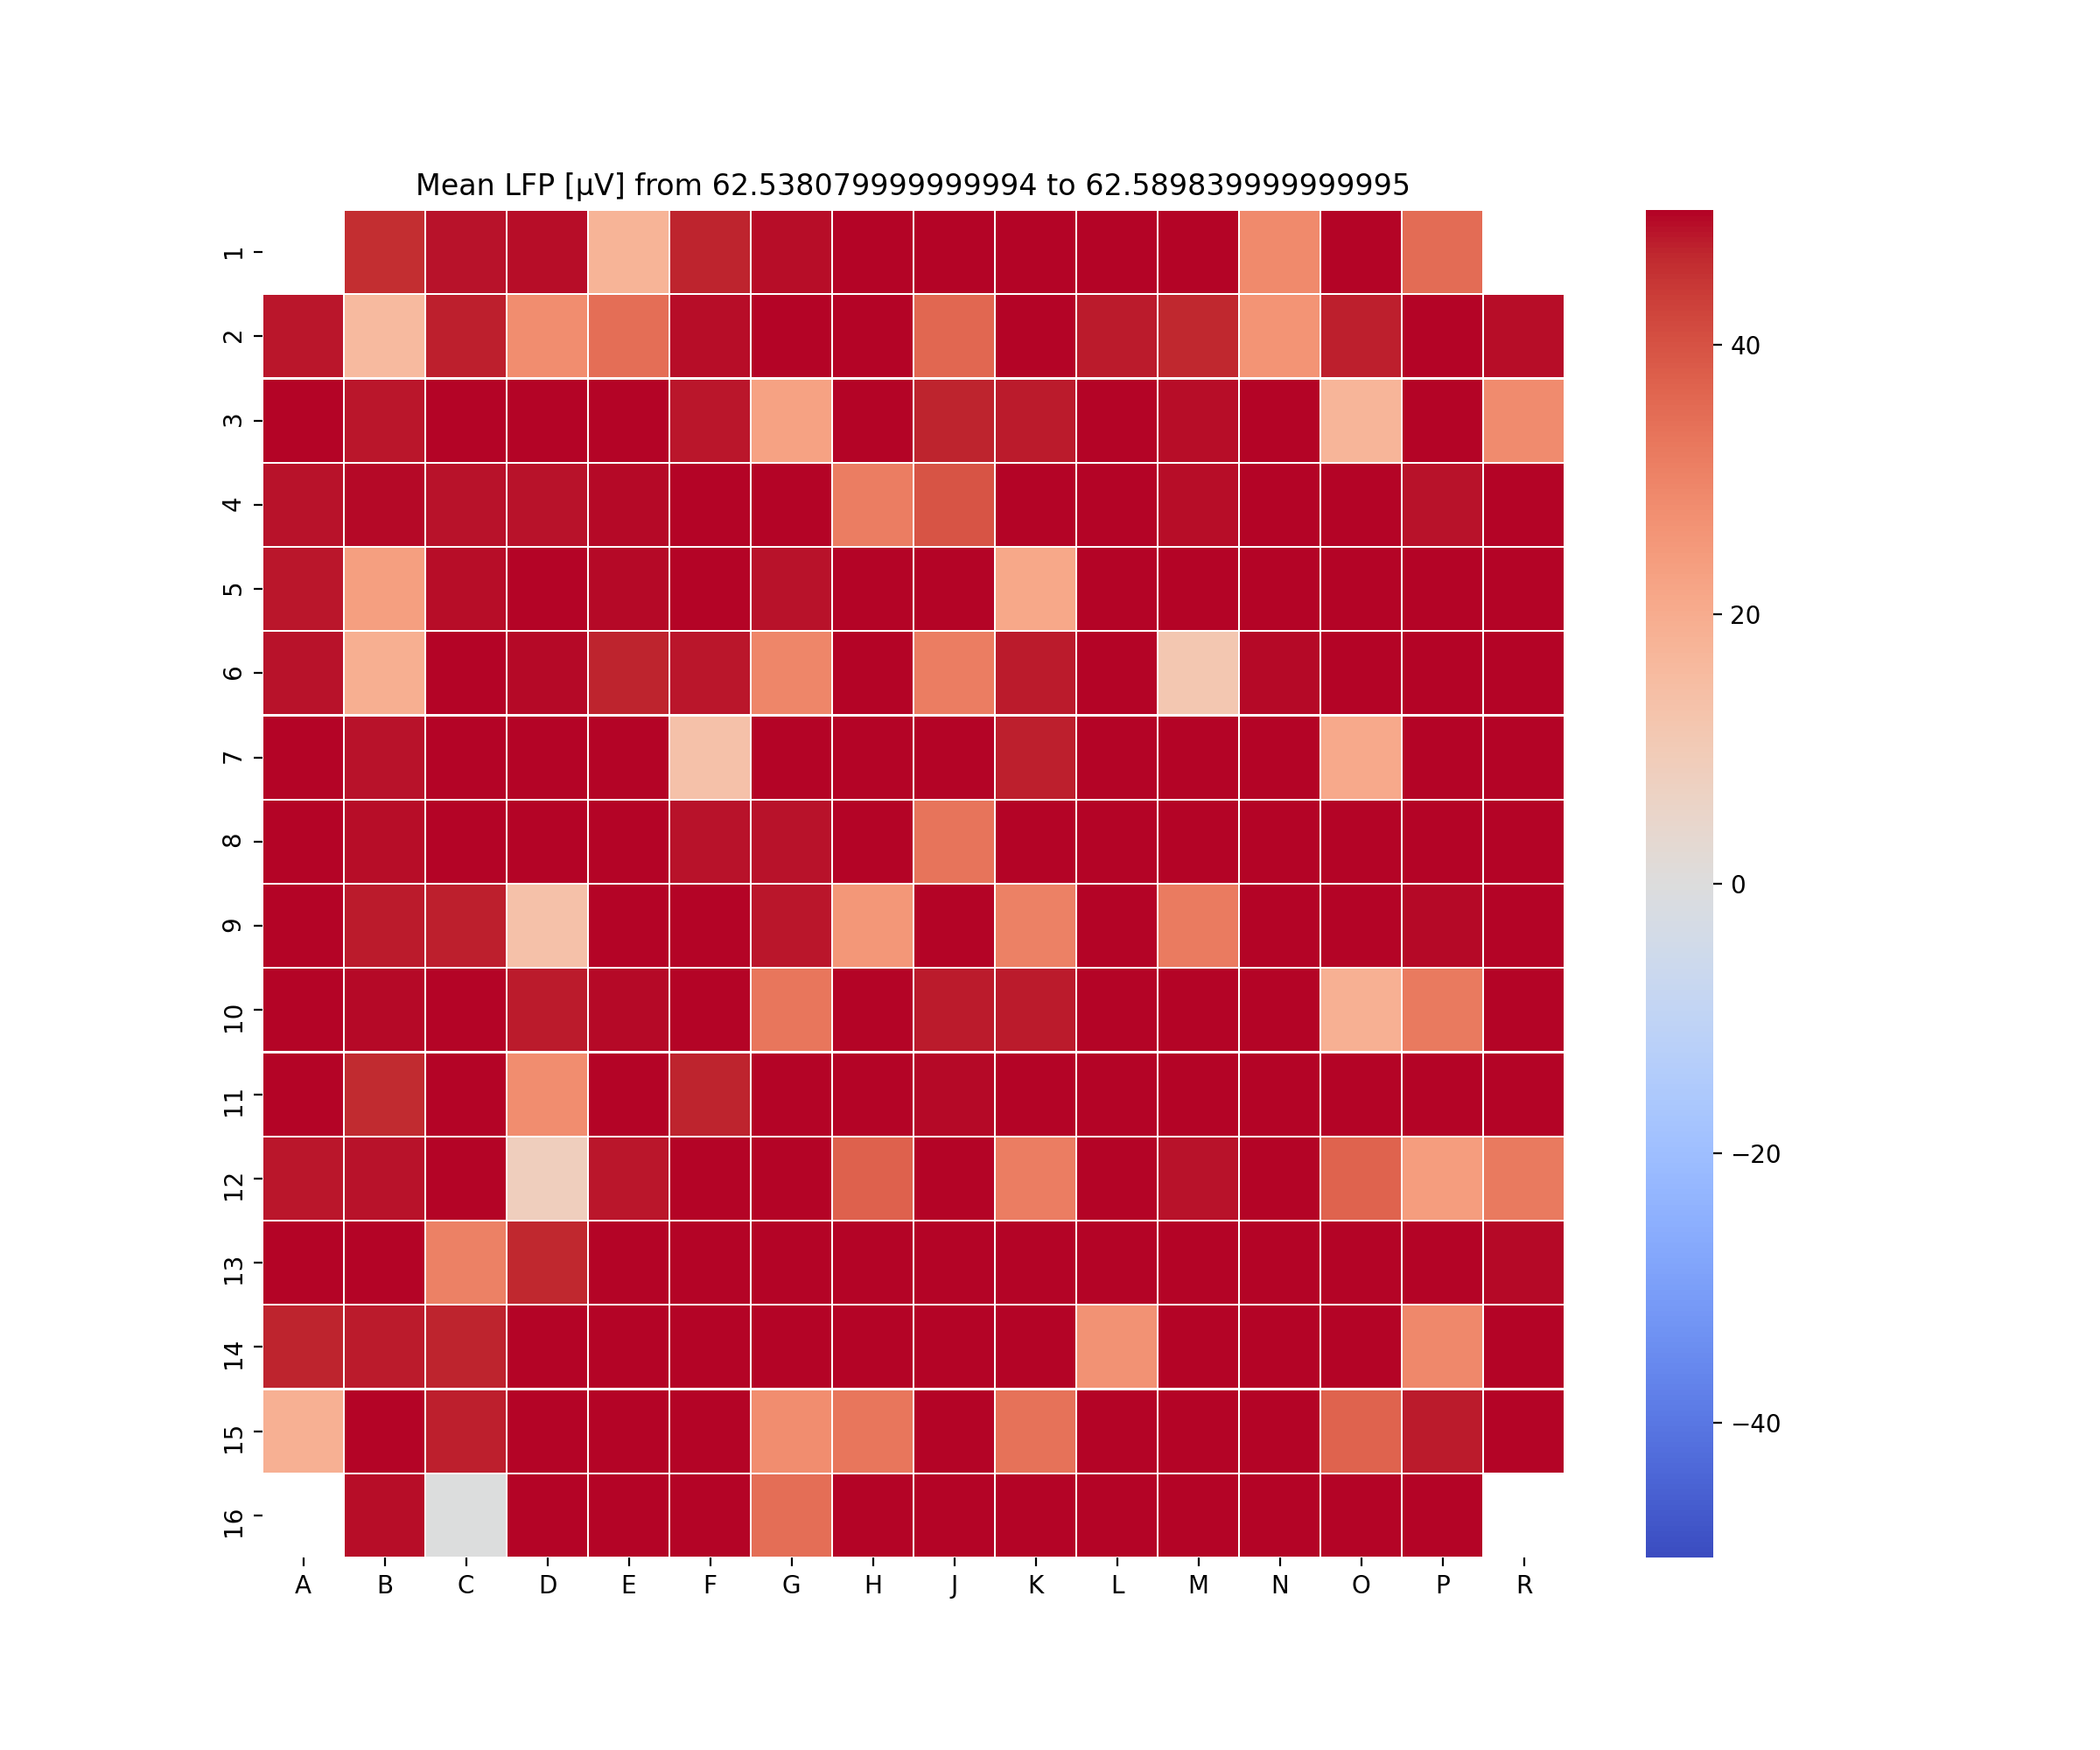

<IPython.core.display.Javascript object>


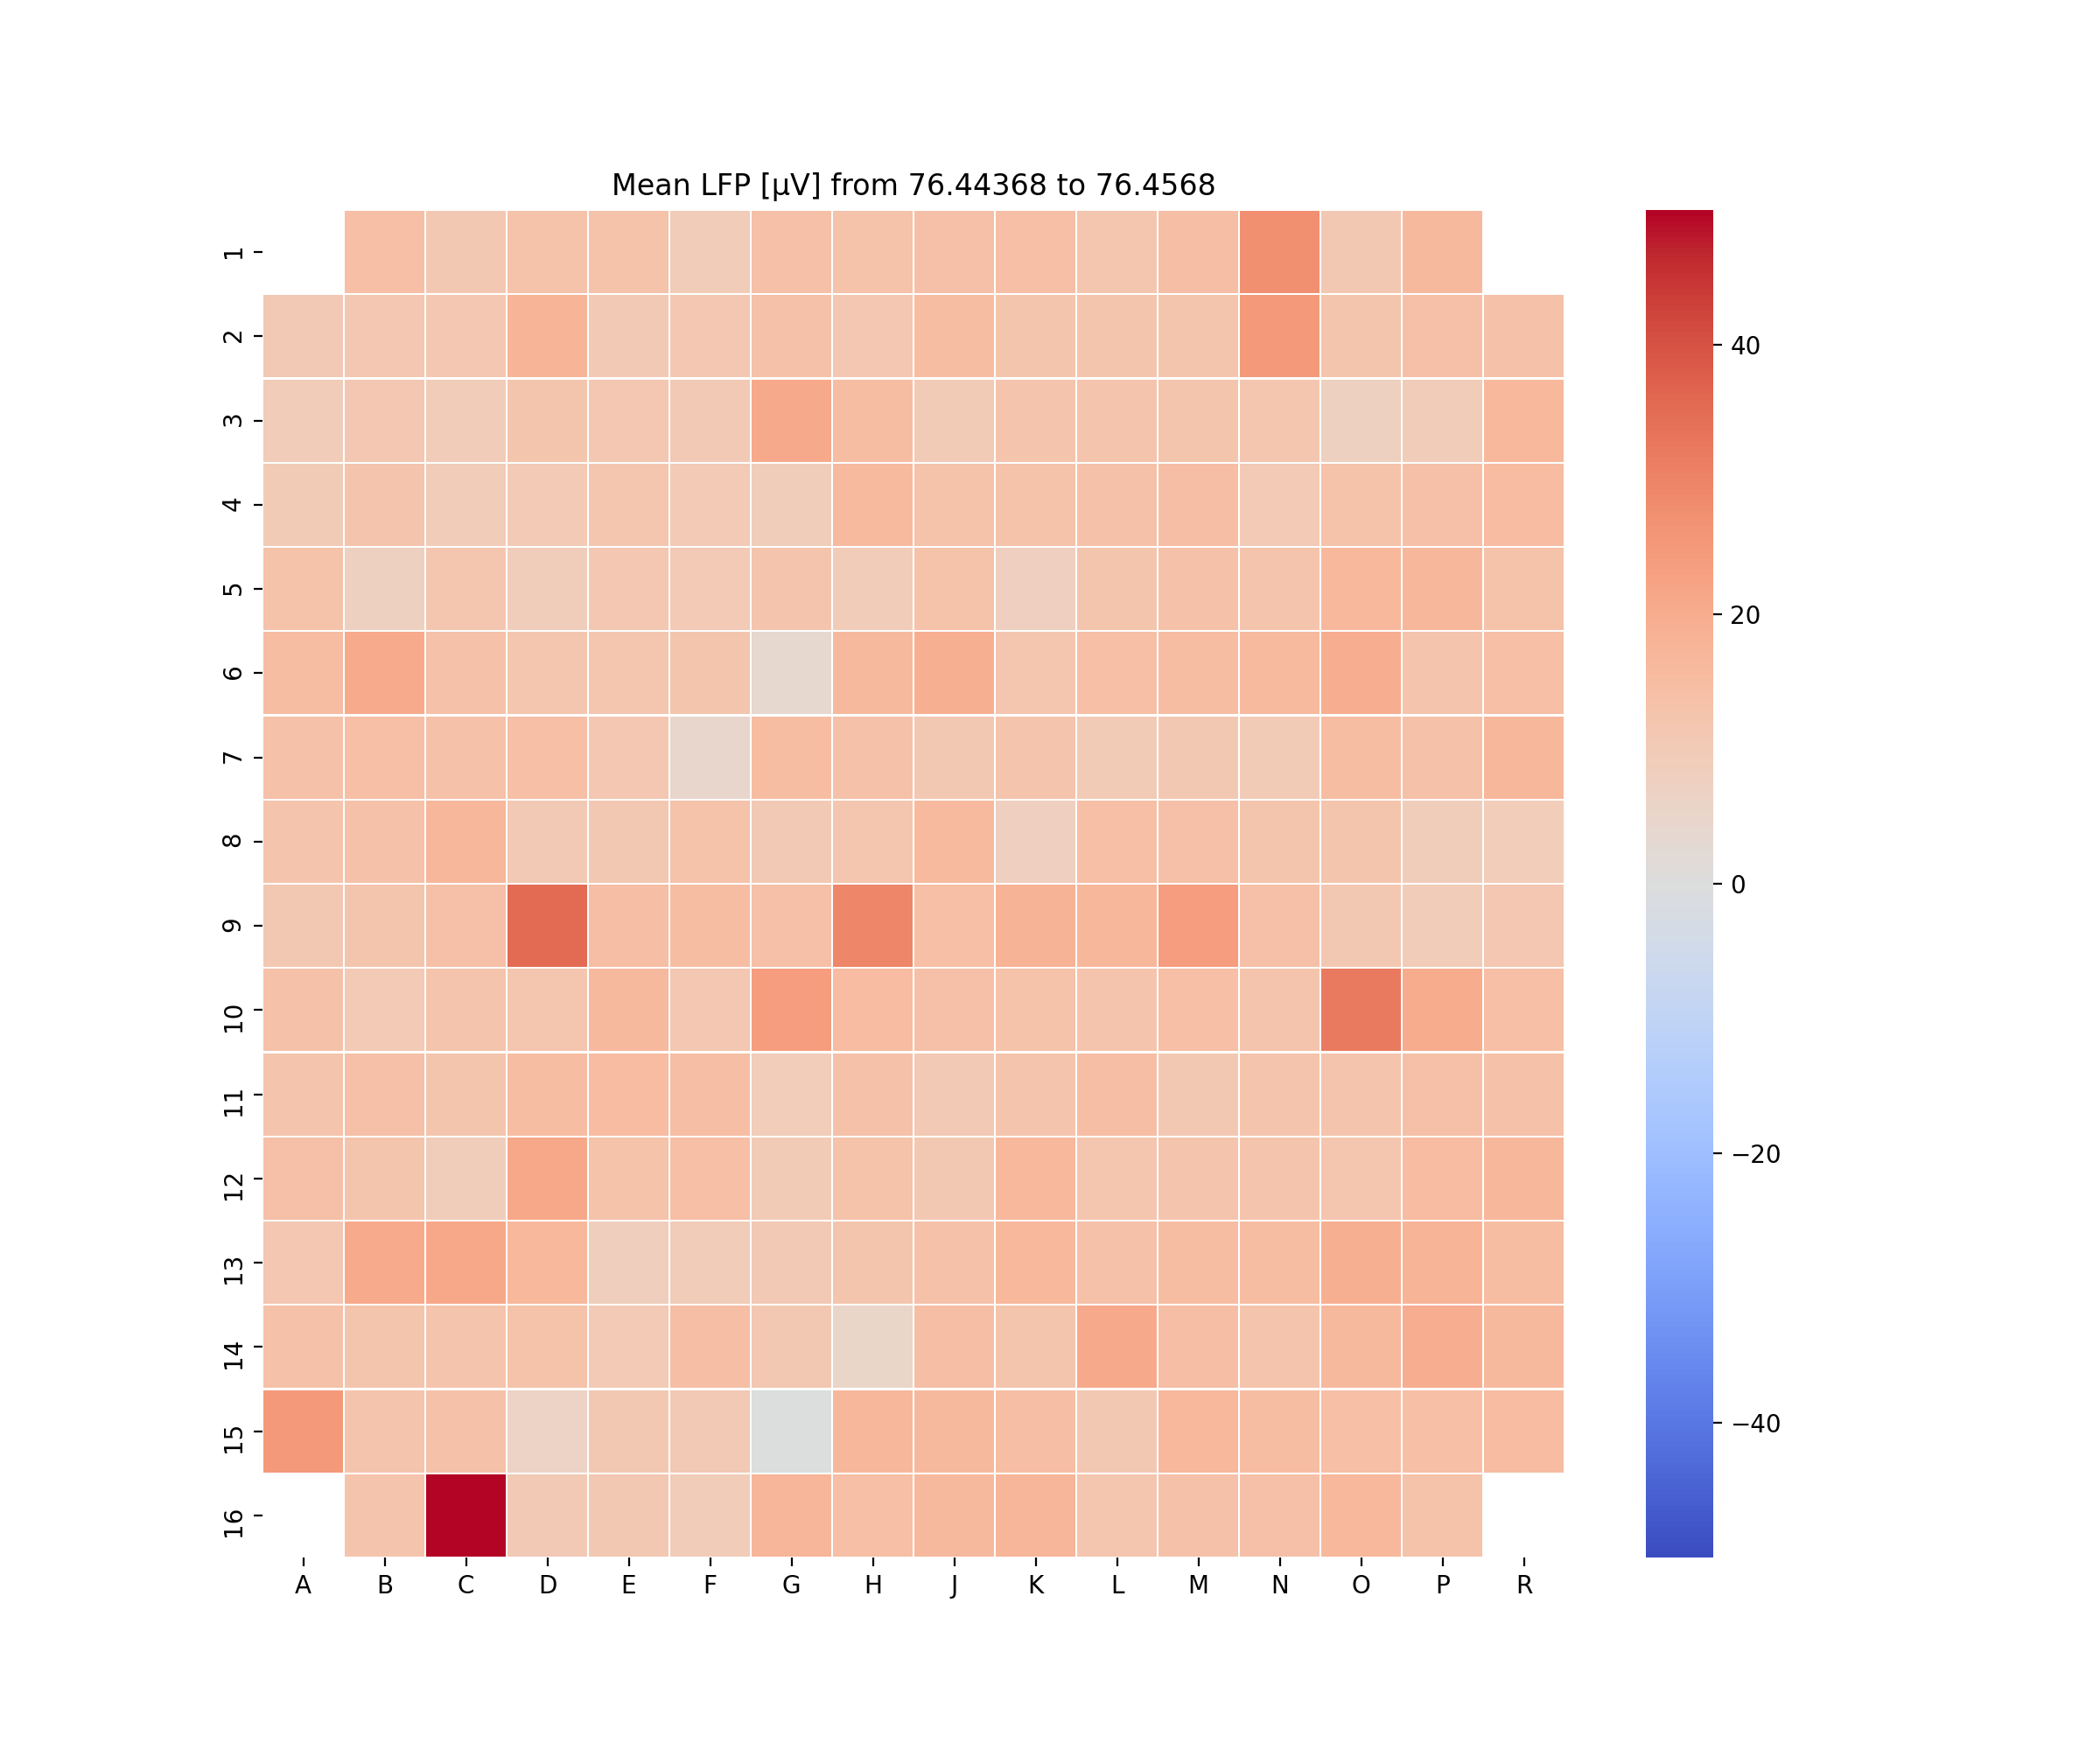

<IPython.core.display.Javascript object>


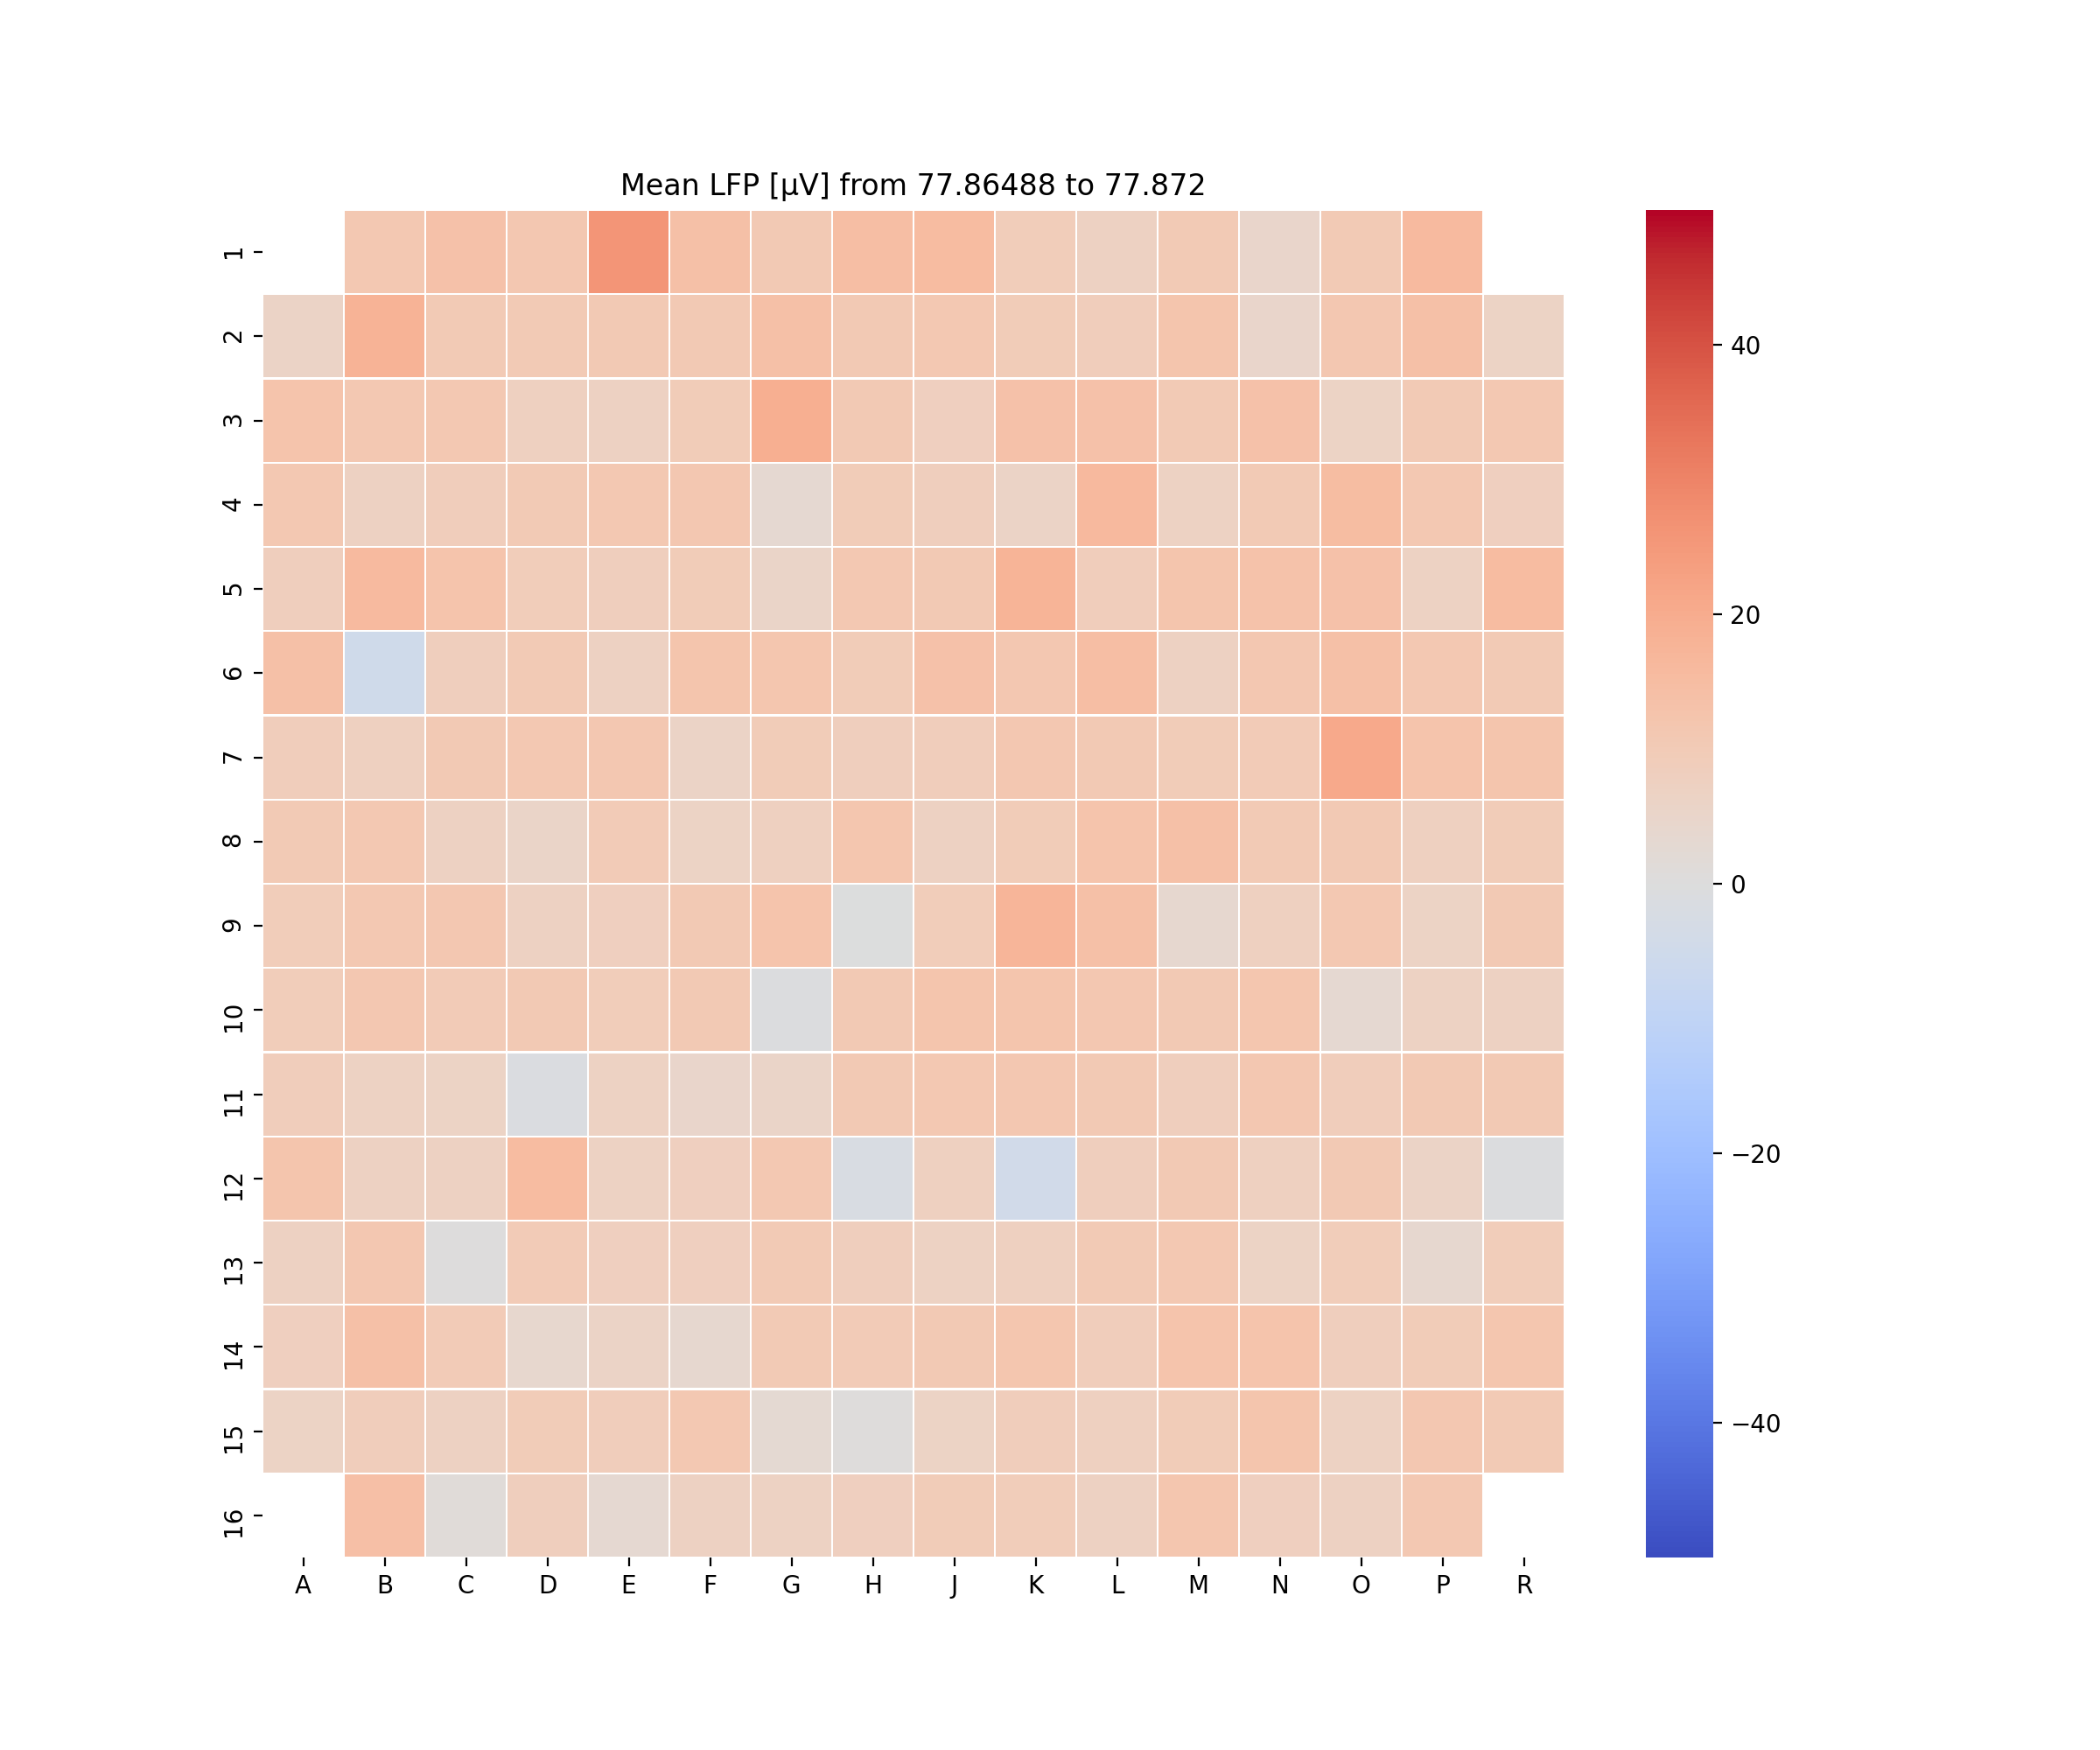

<IPython.core.display.Javascript object>


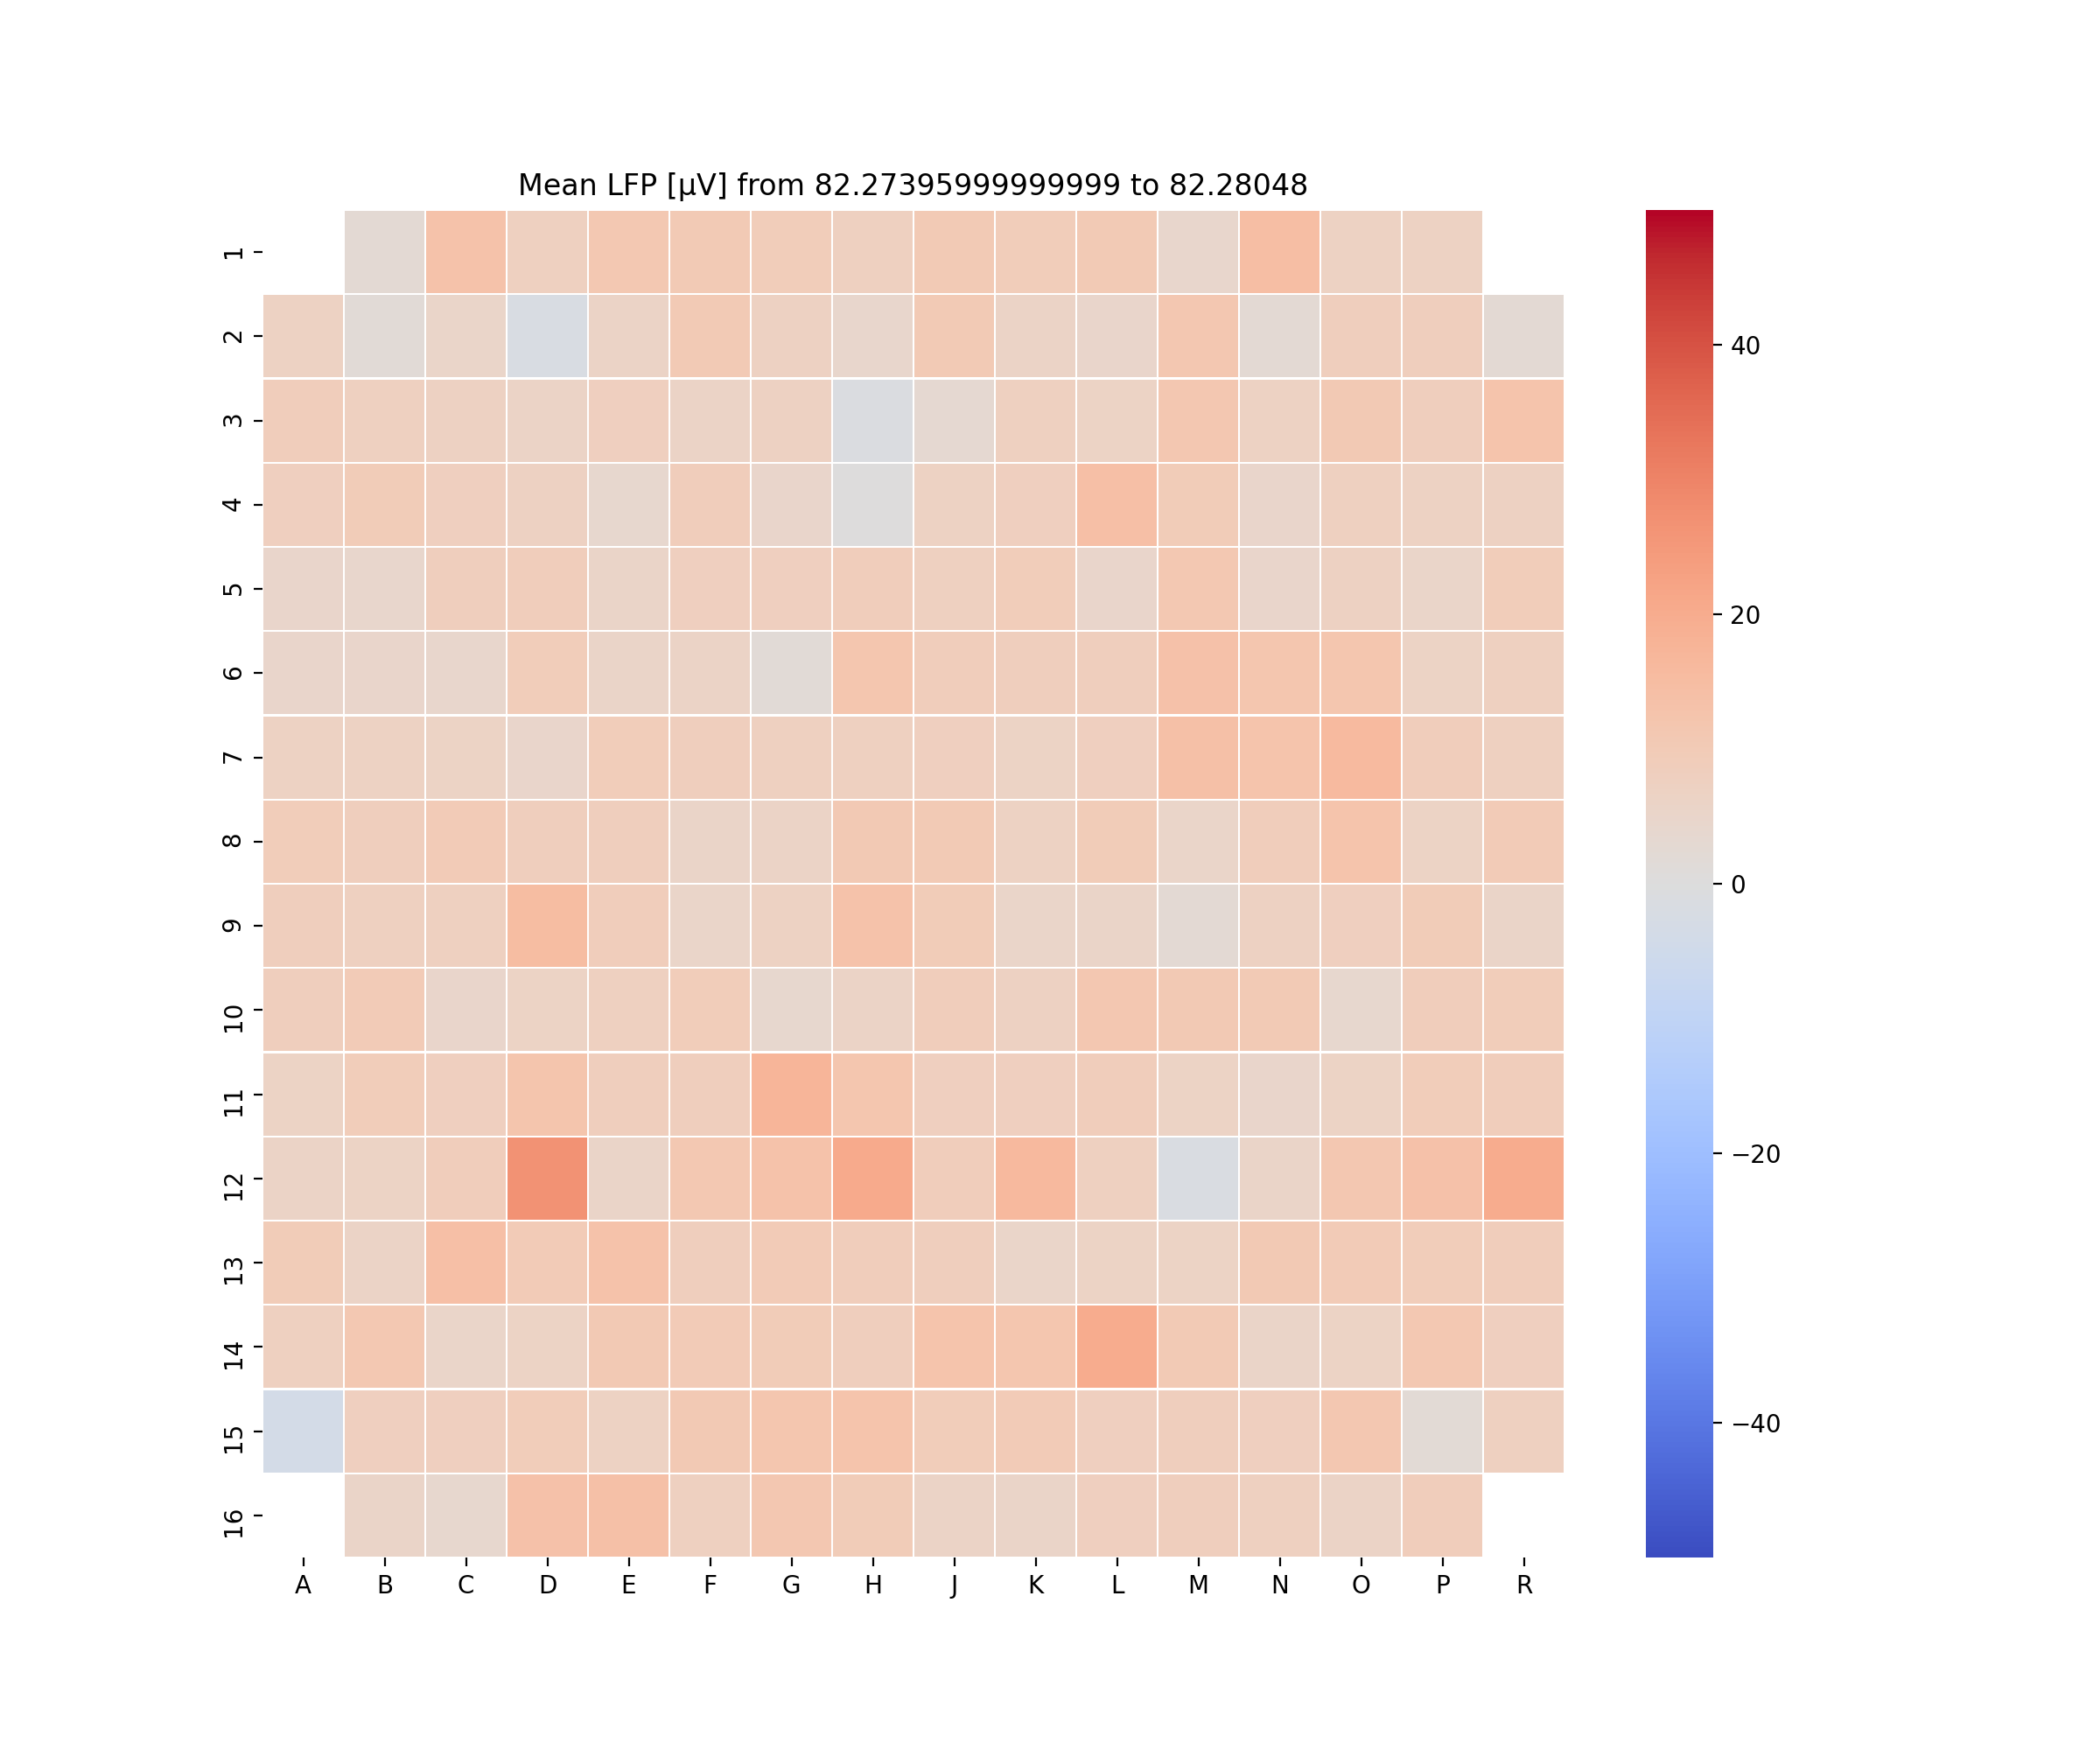

<IPython.core.display.Javascript object>


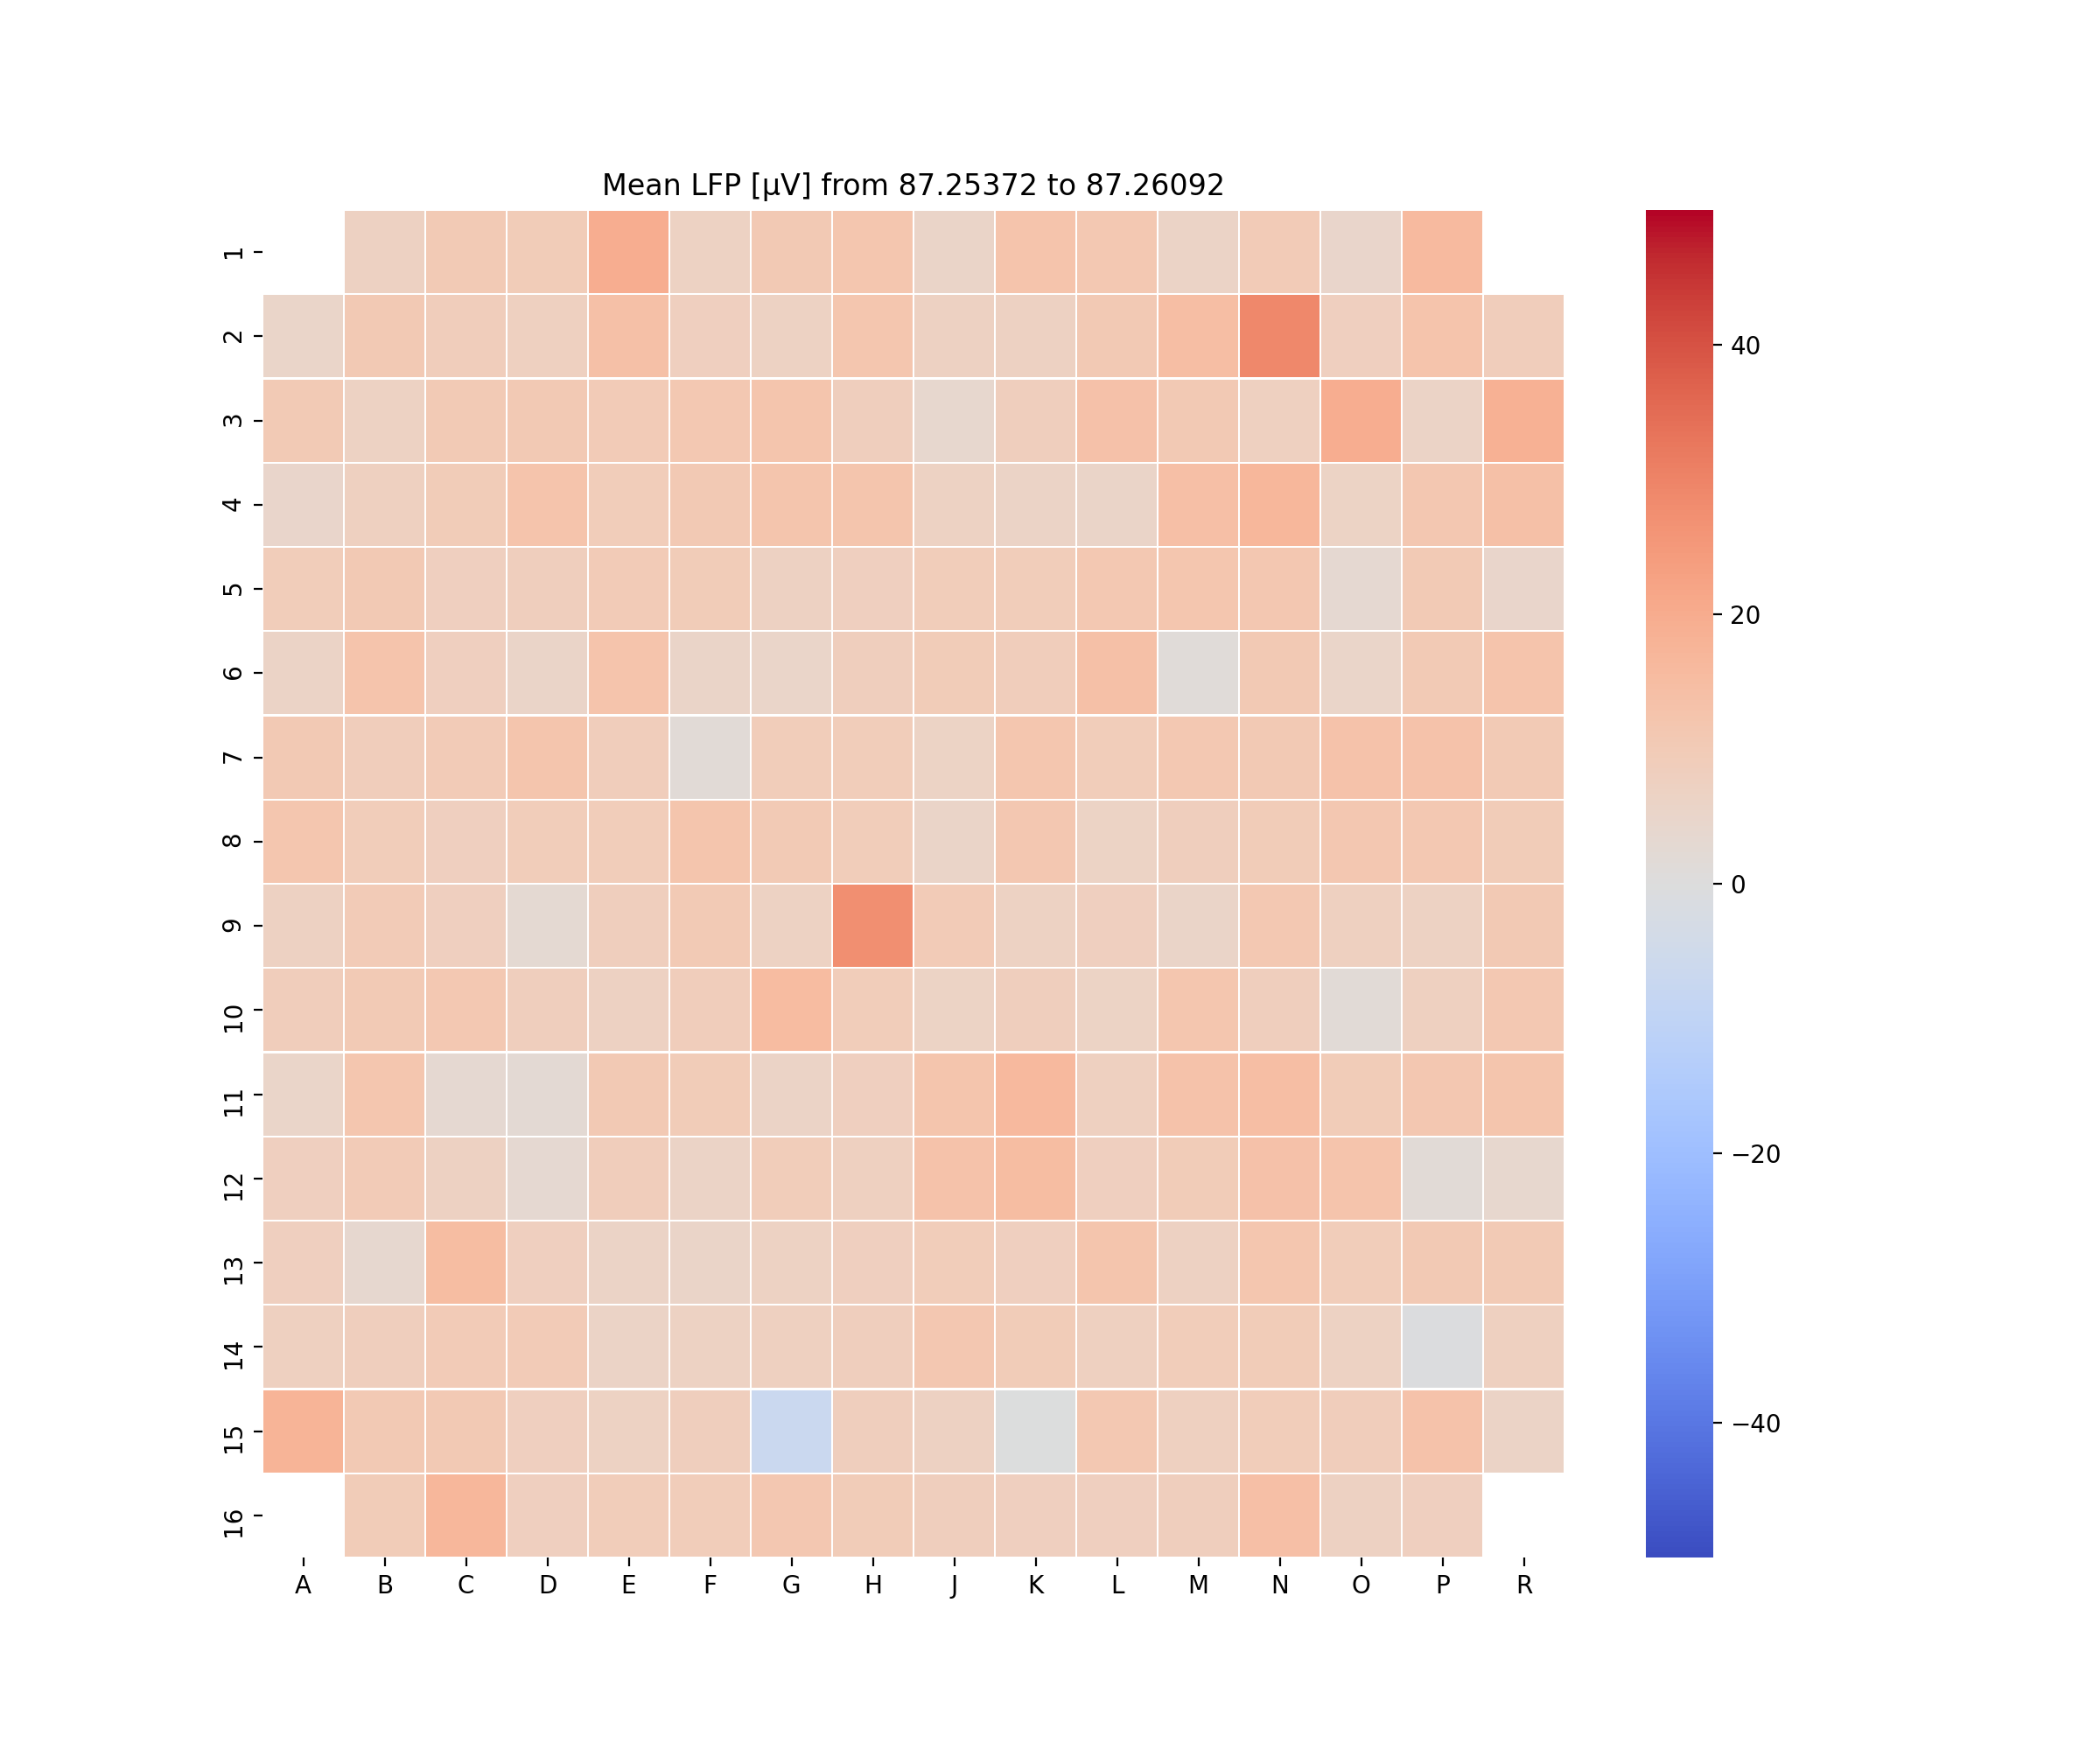

<IPython.core.display.Javascript object>


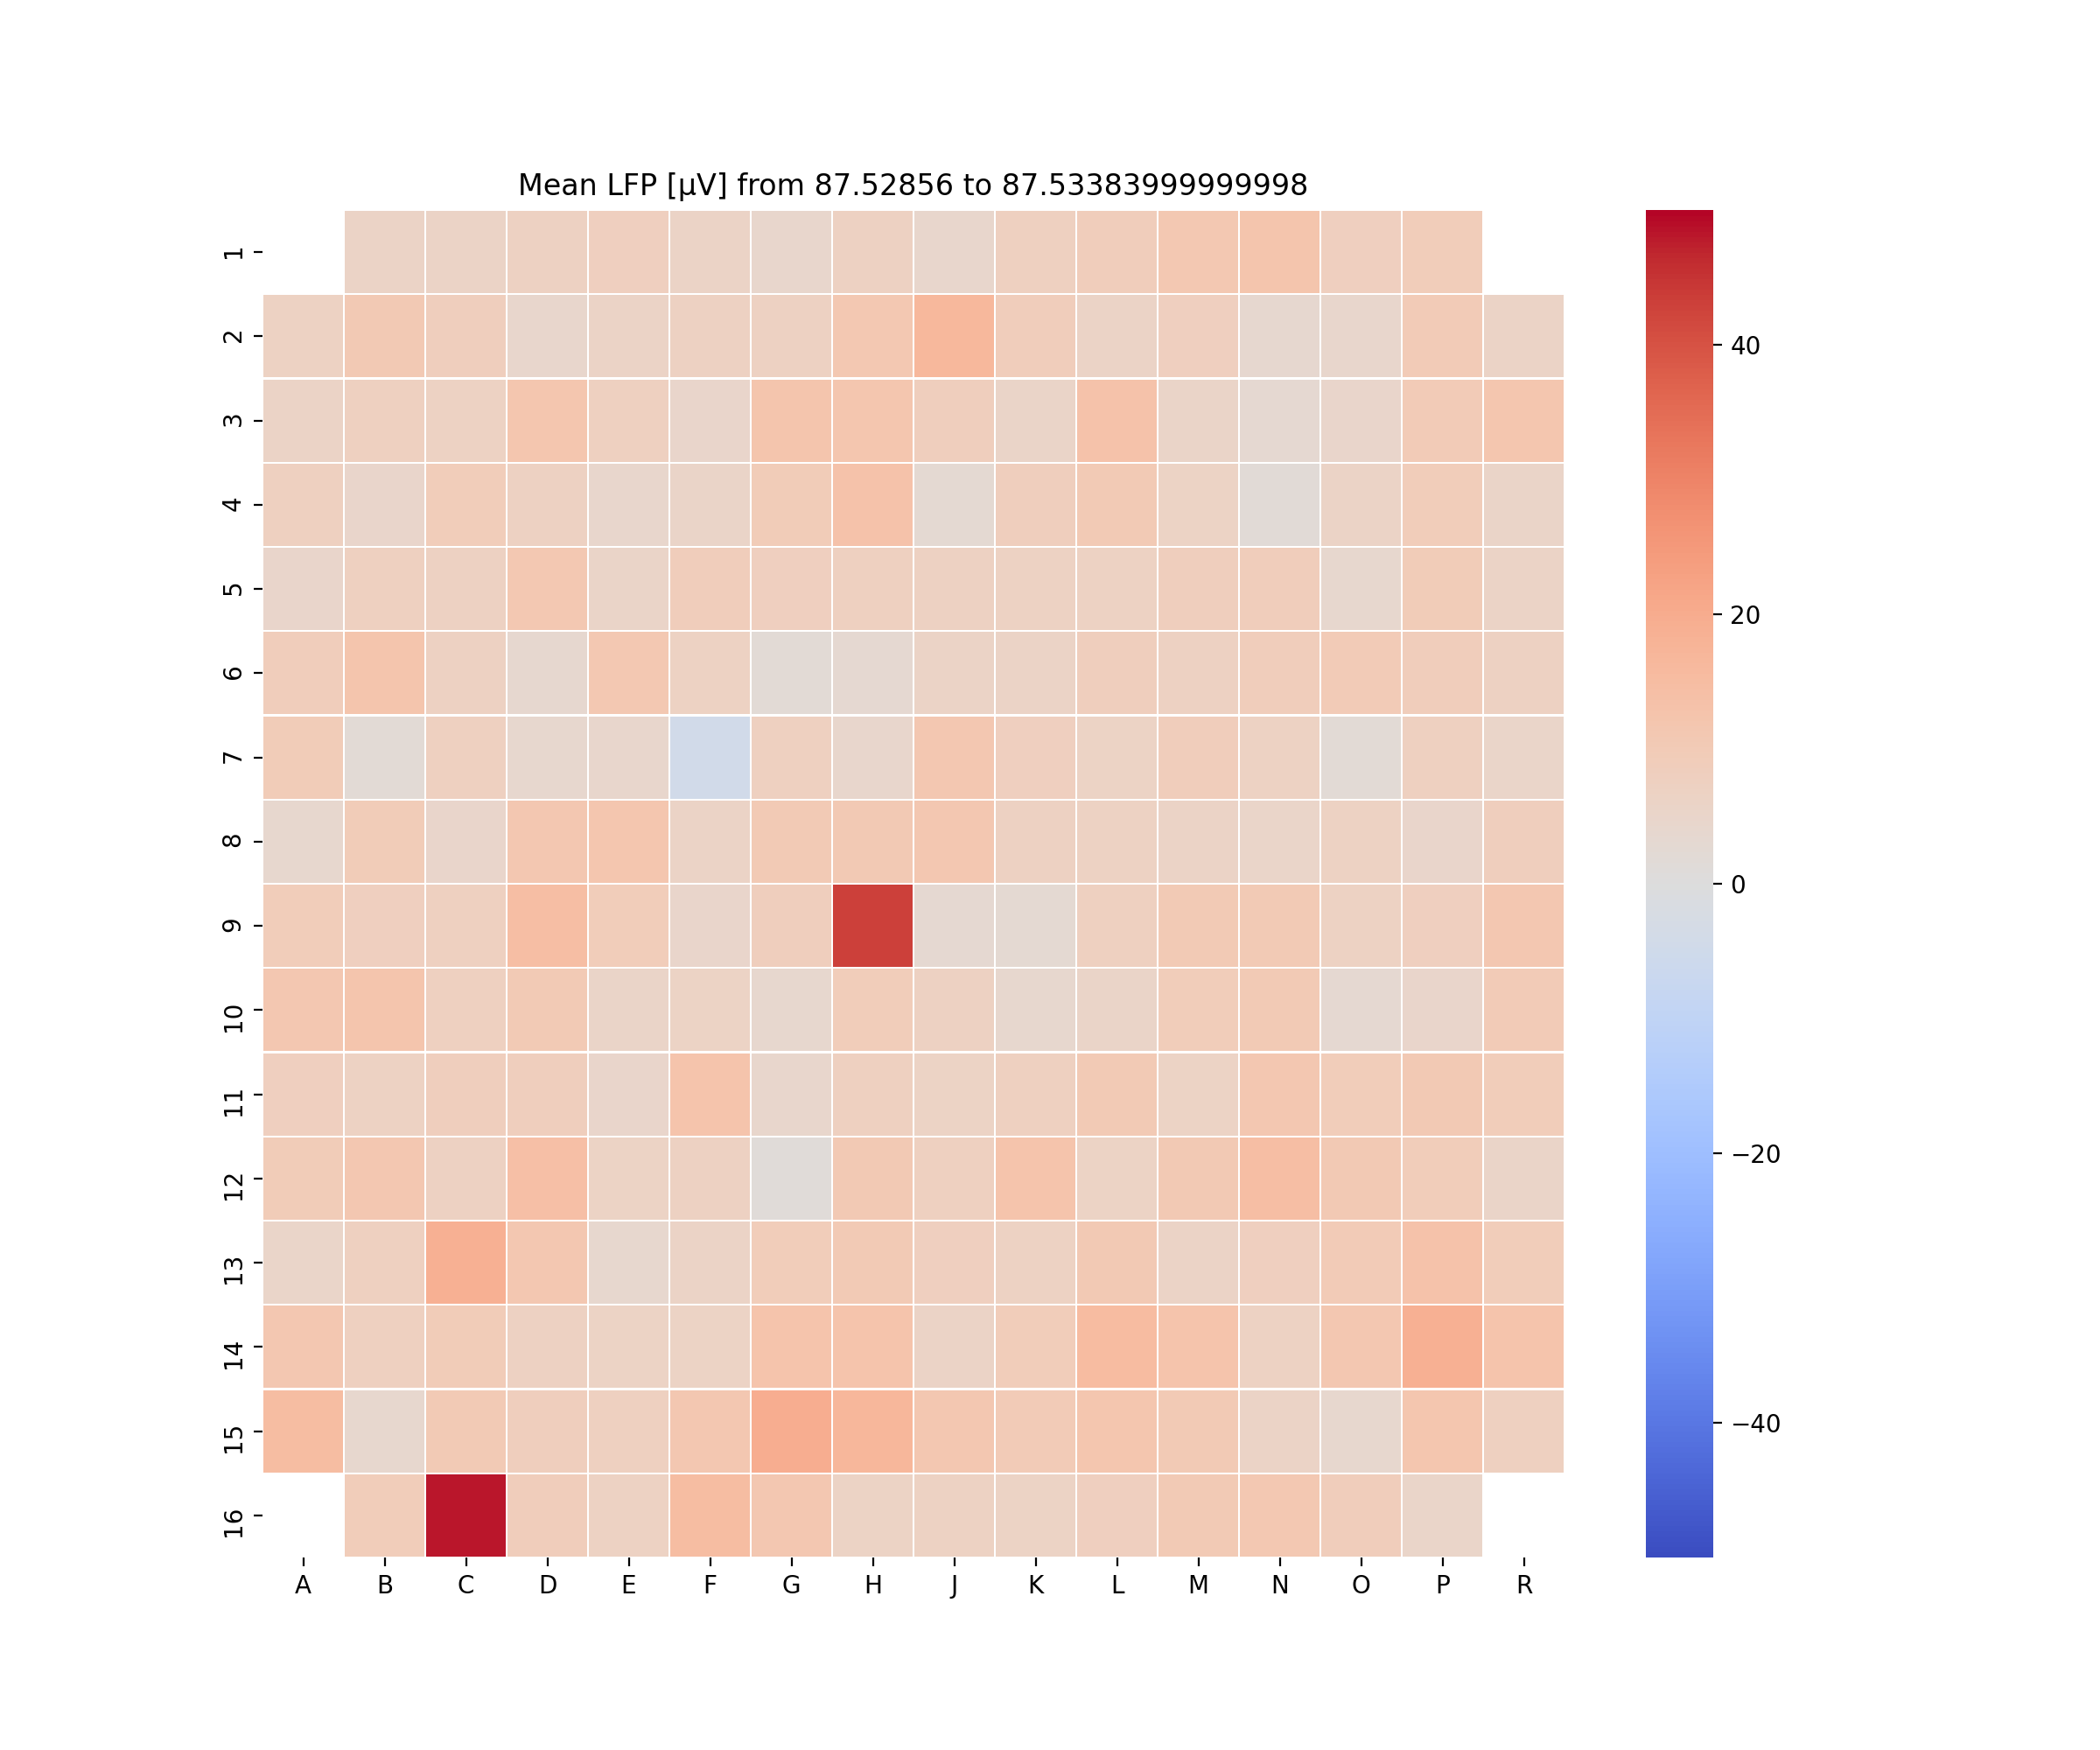

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


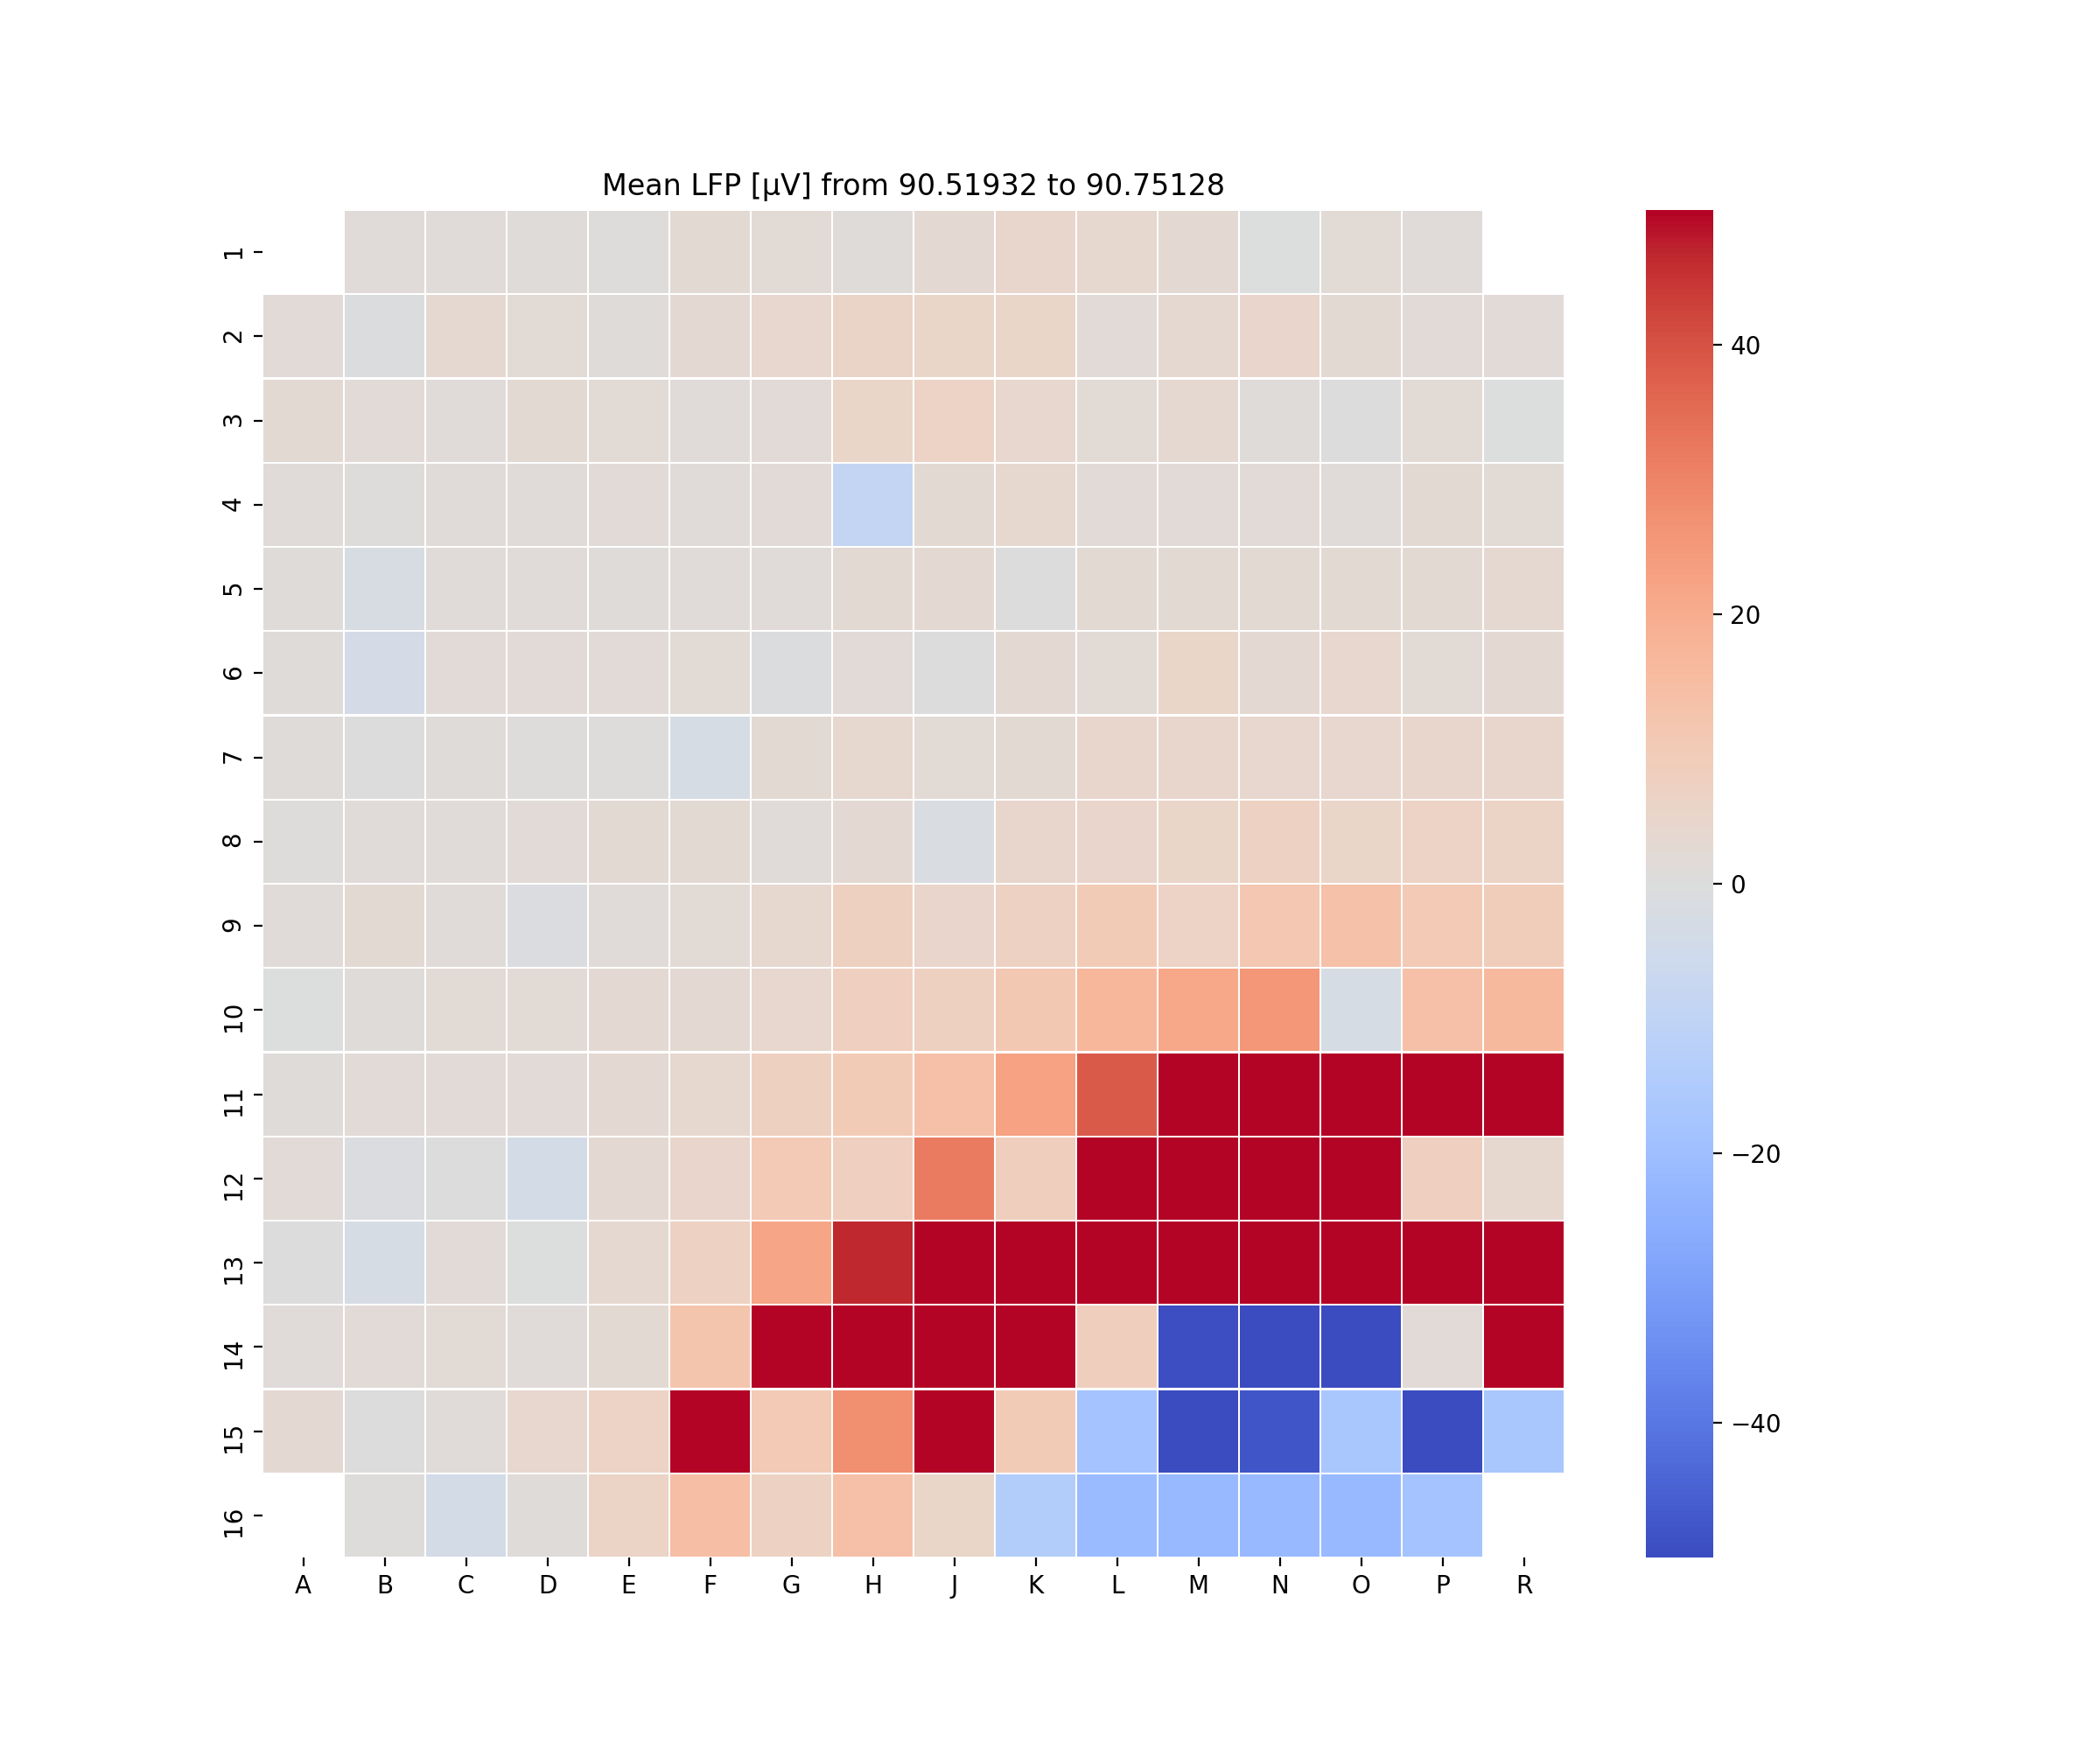

<IPython.core.display.Javascript object>


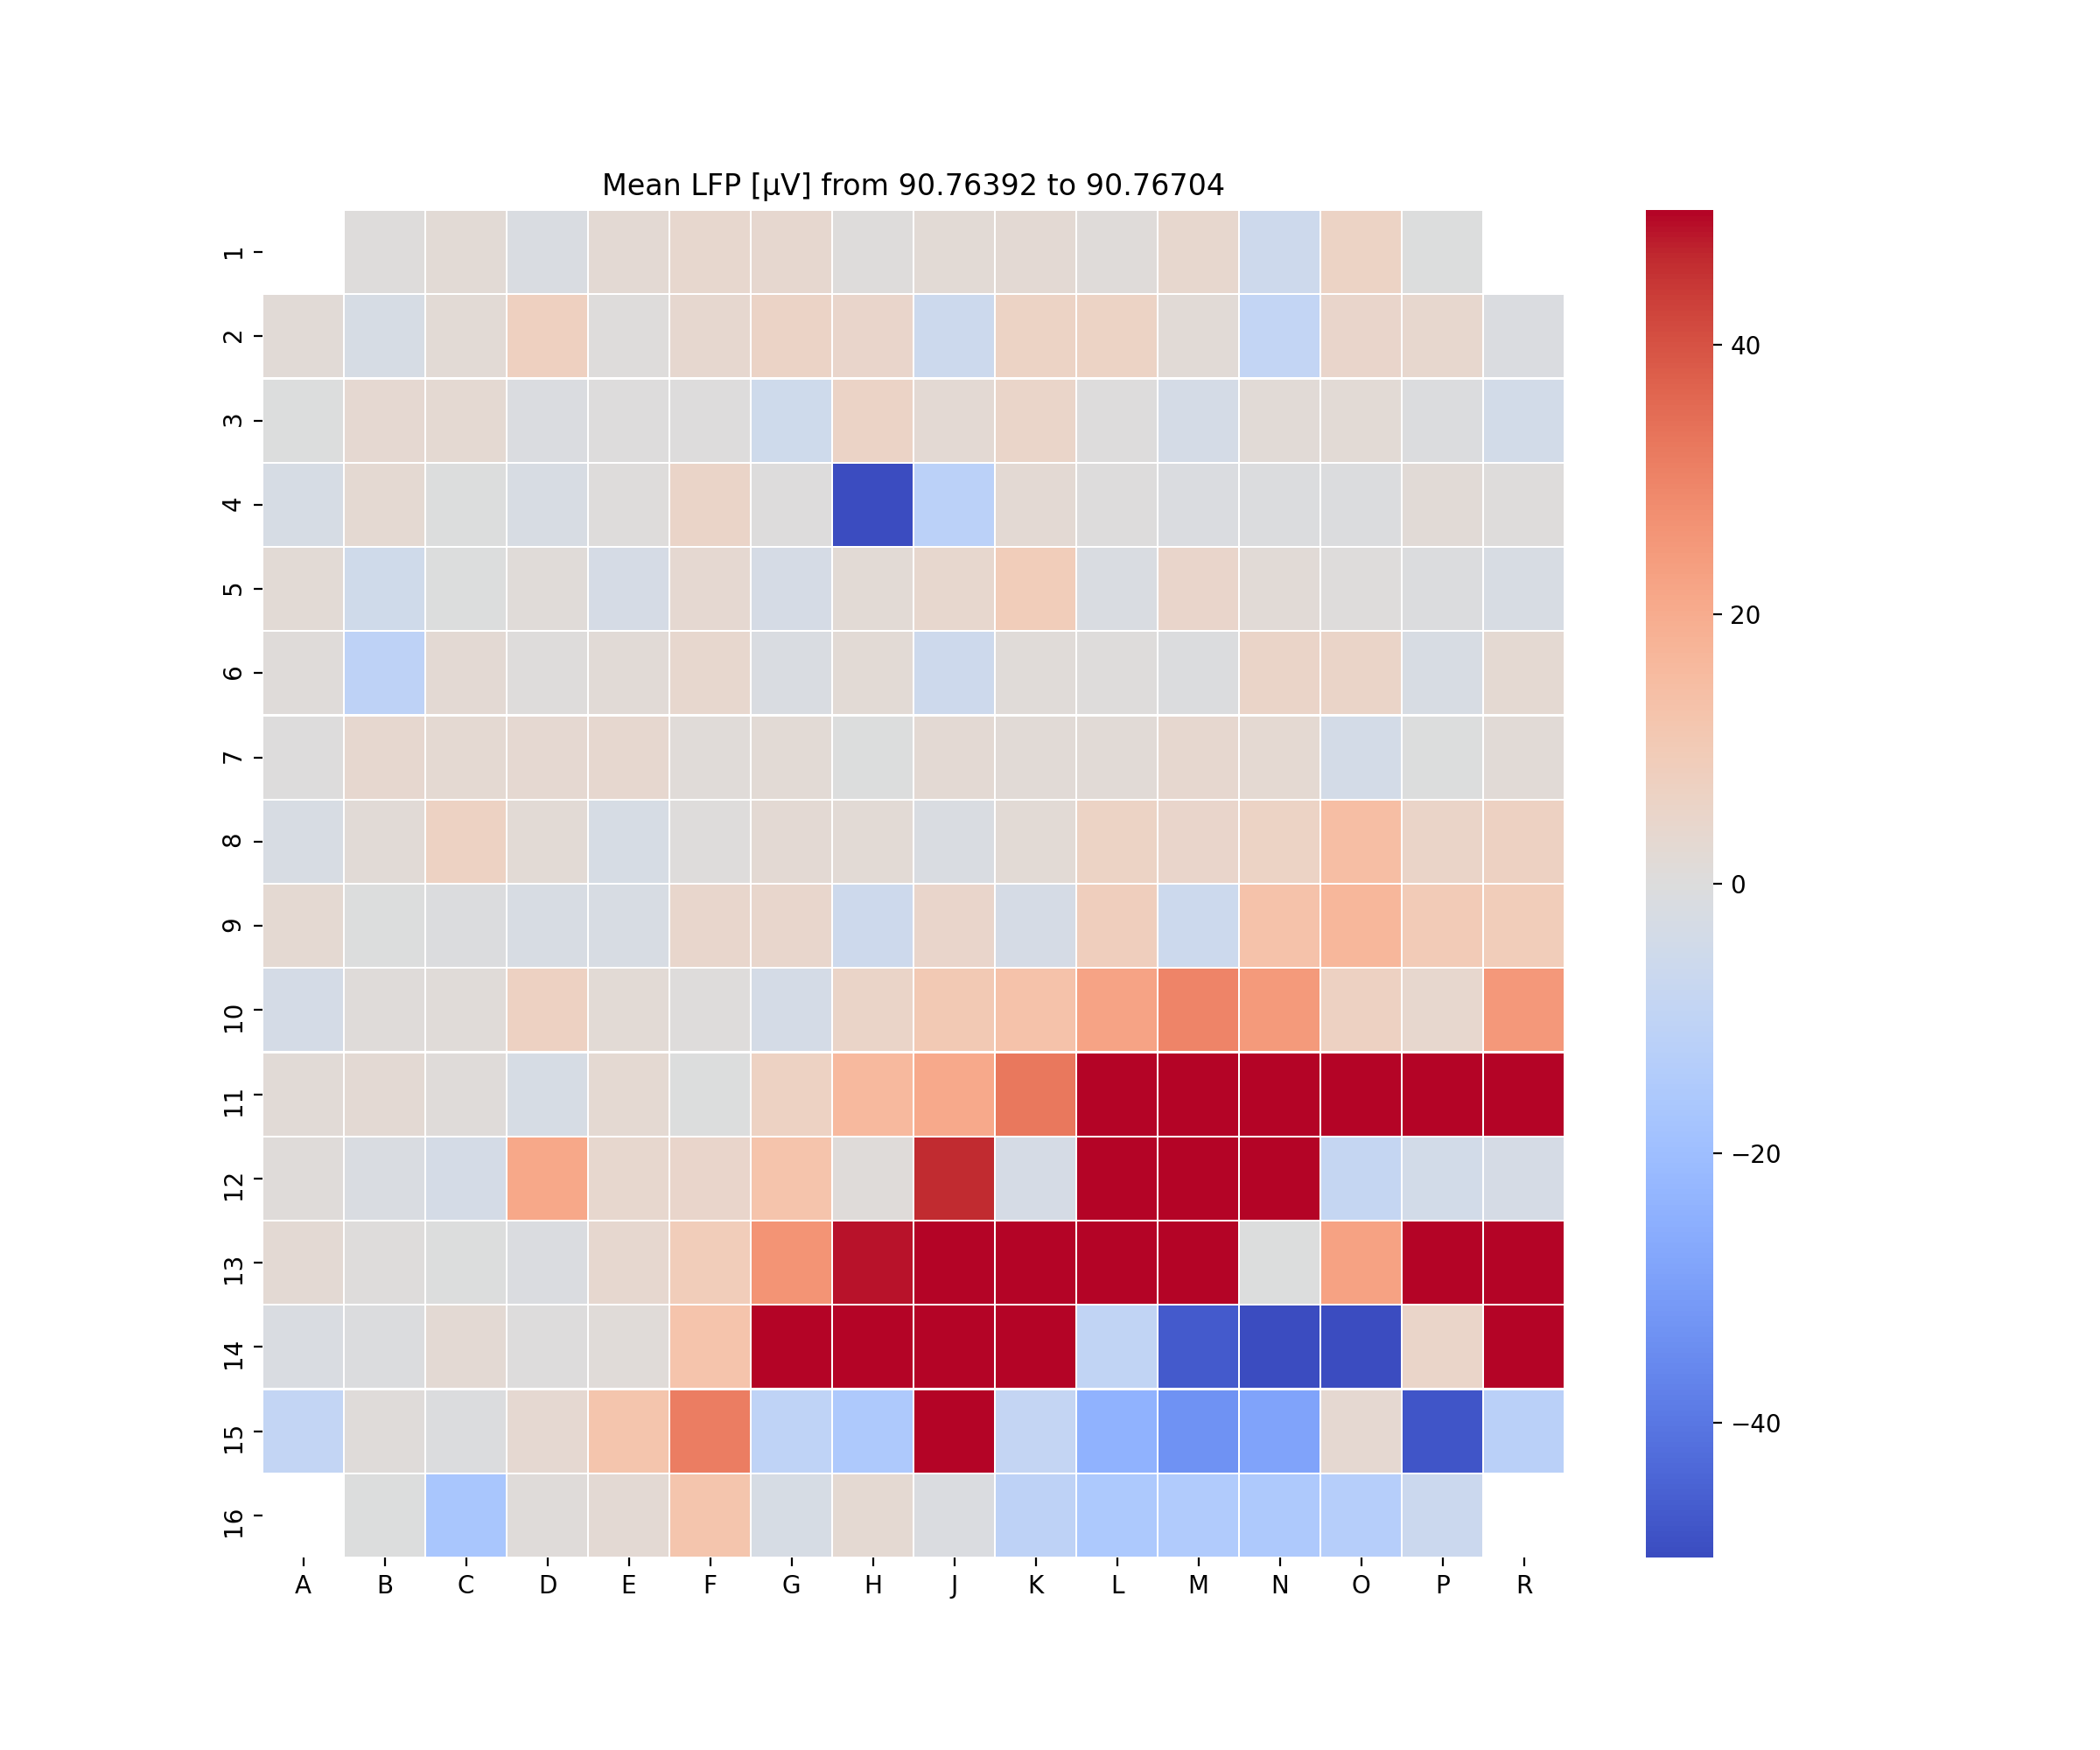

<IPython.core.display.Javascript object>


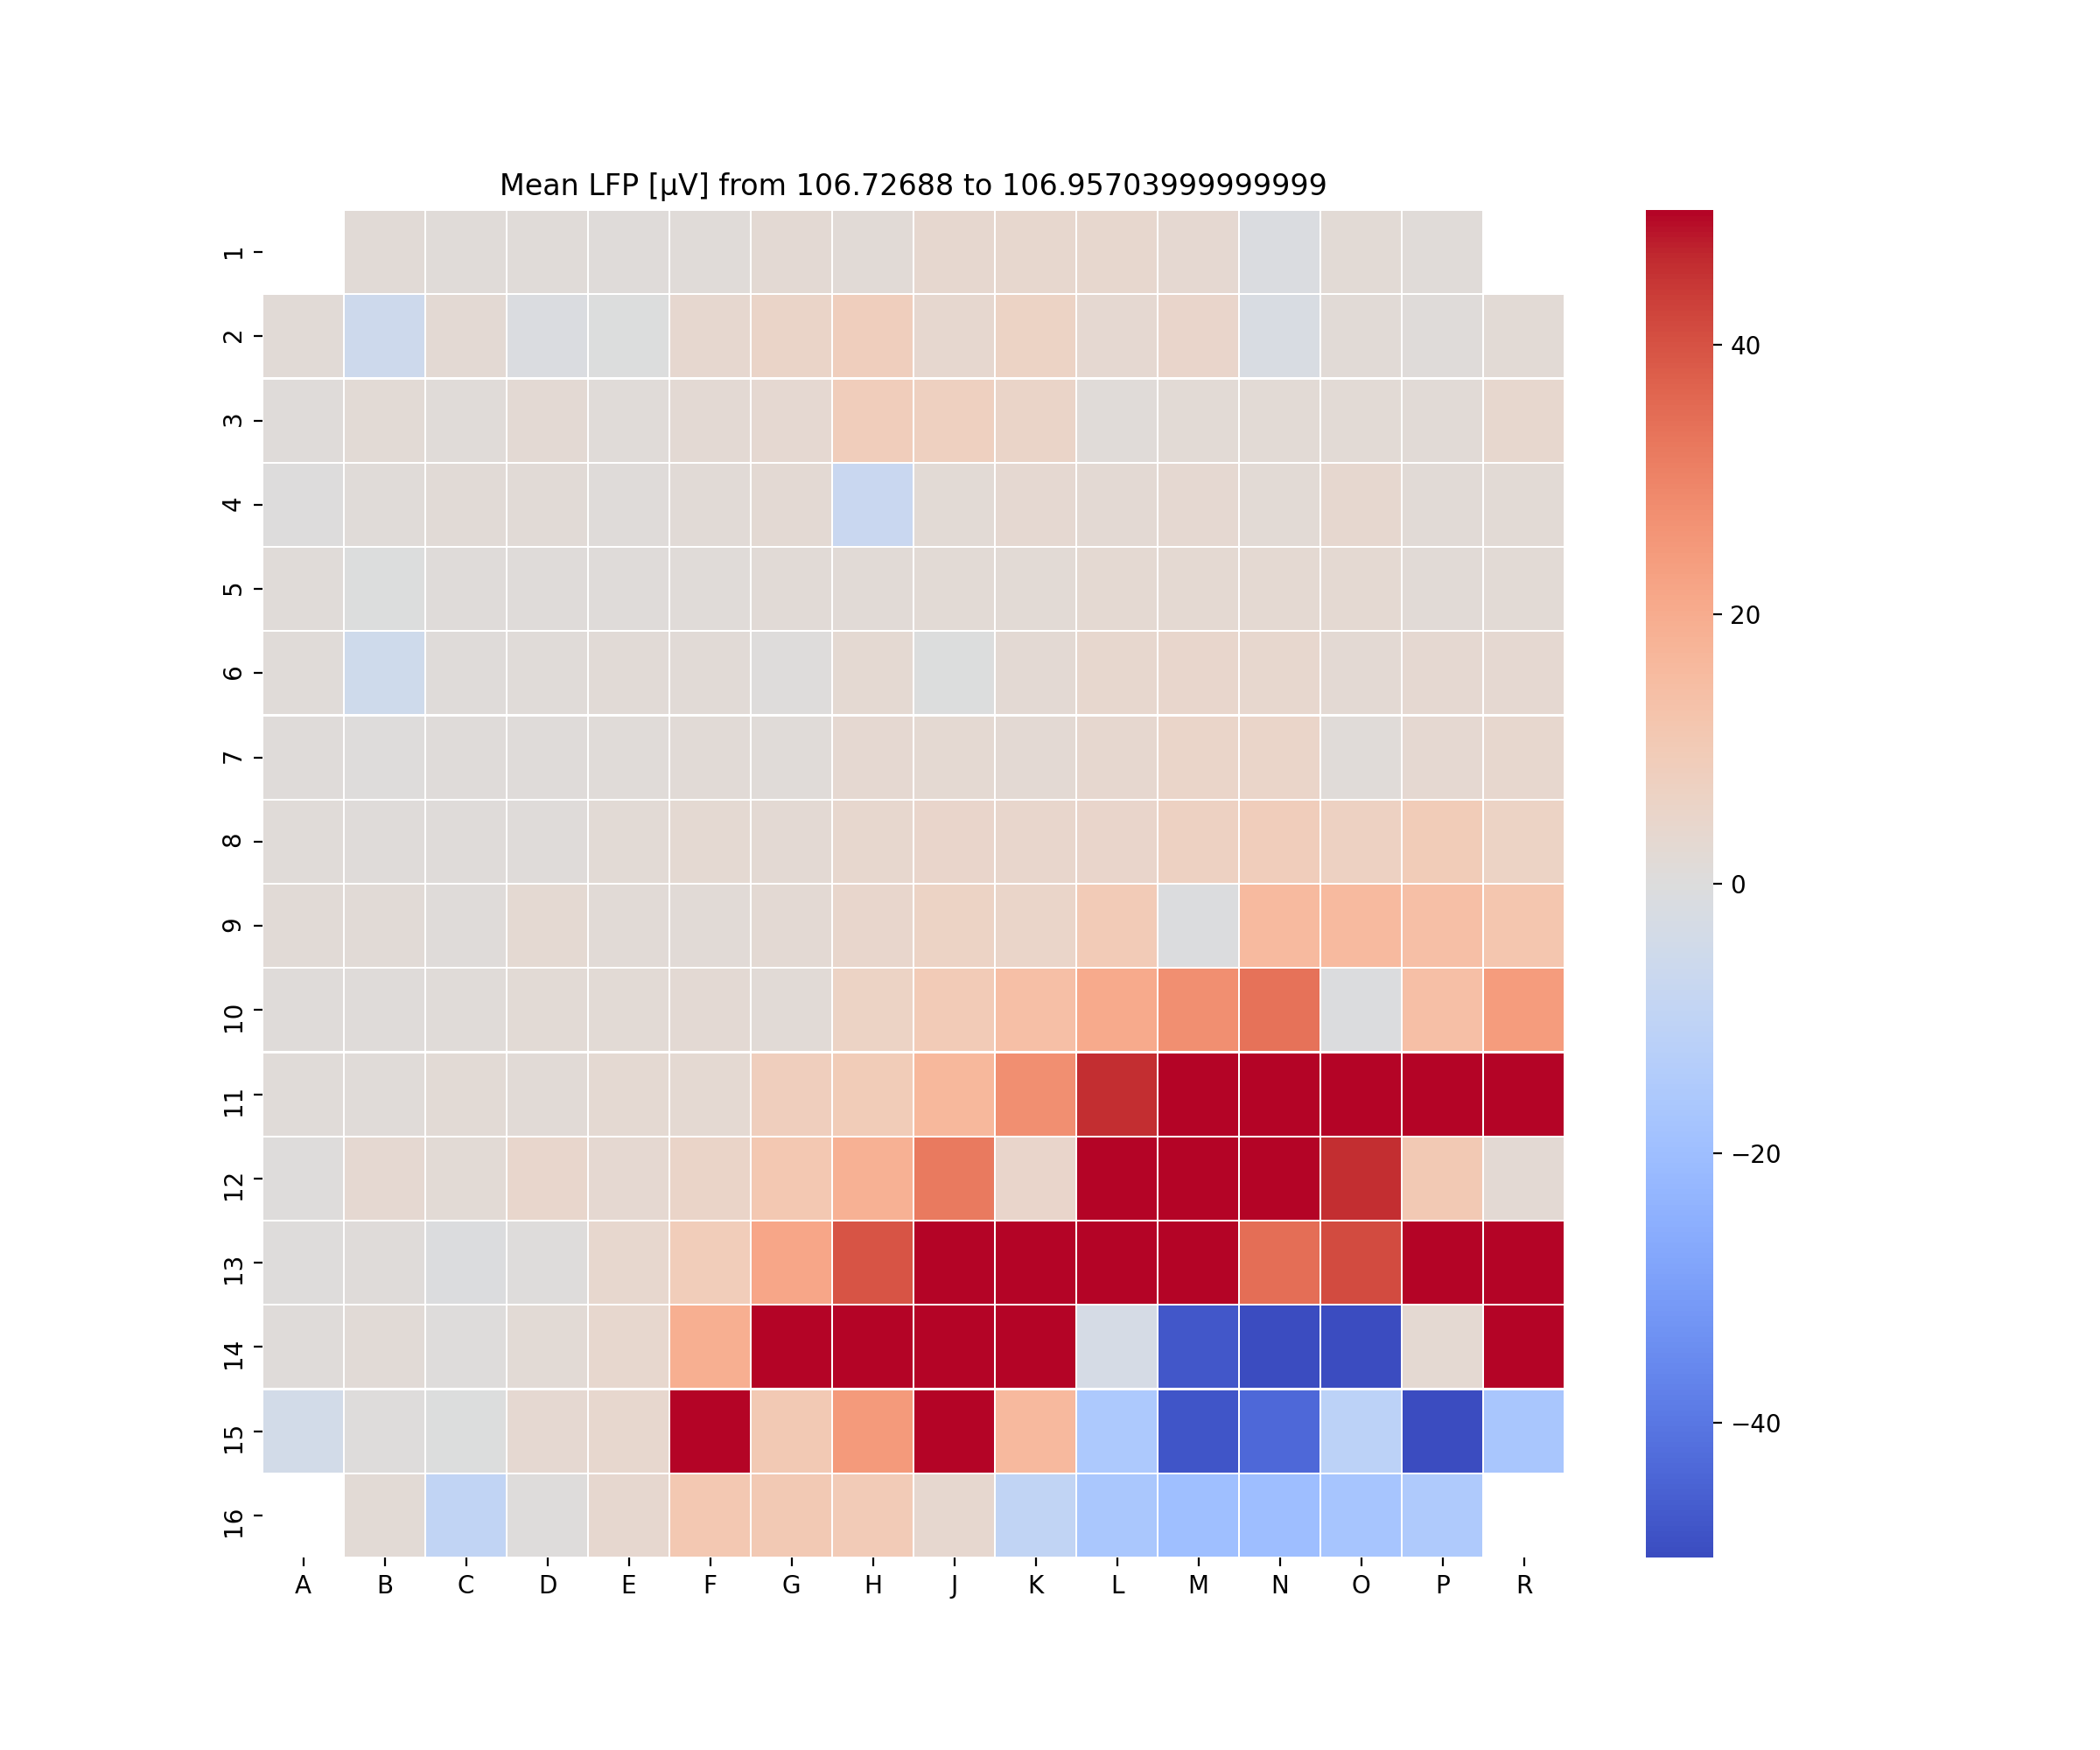

<IPython.core.display.Javascript object>


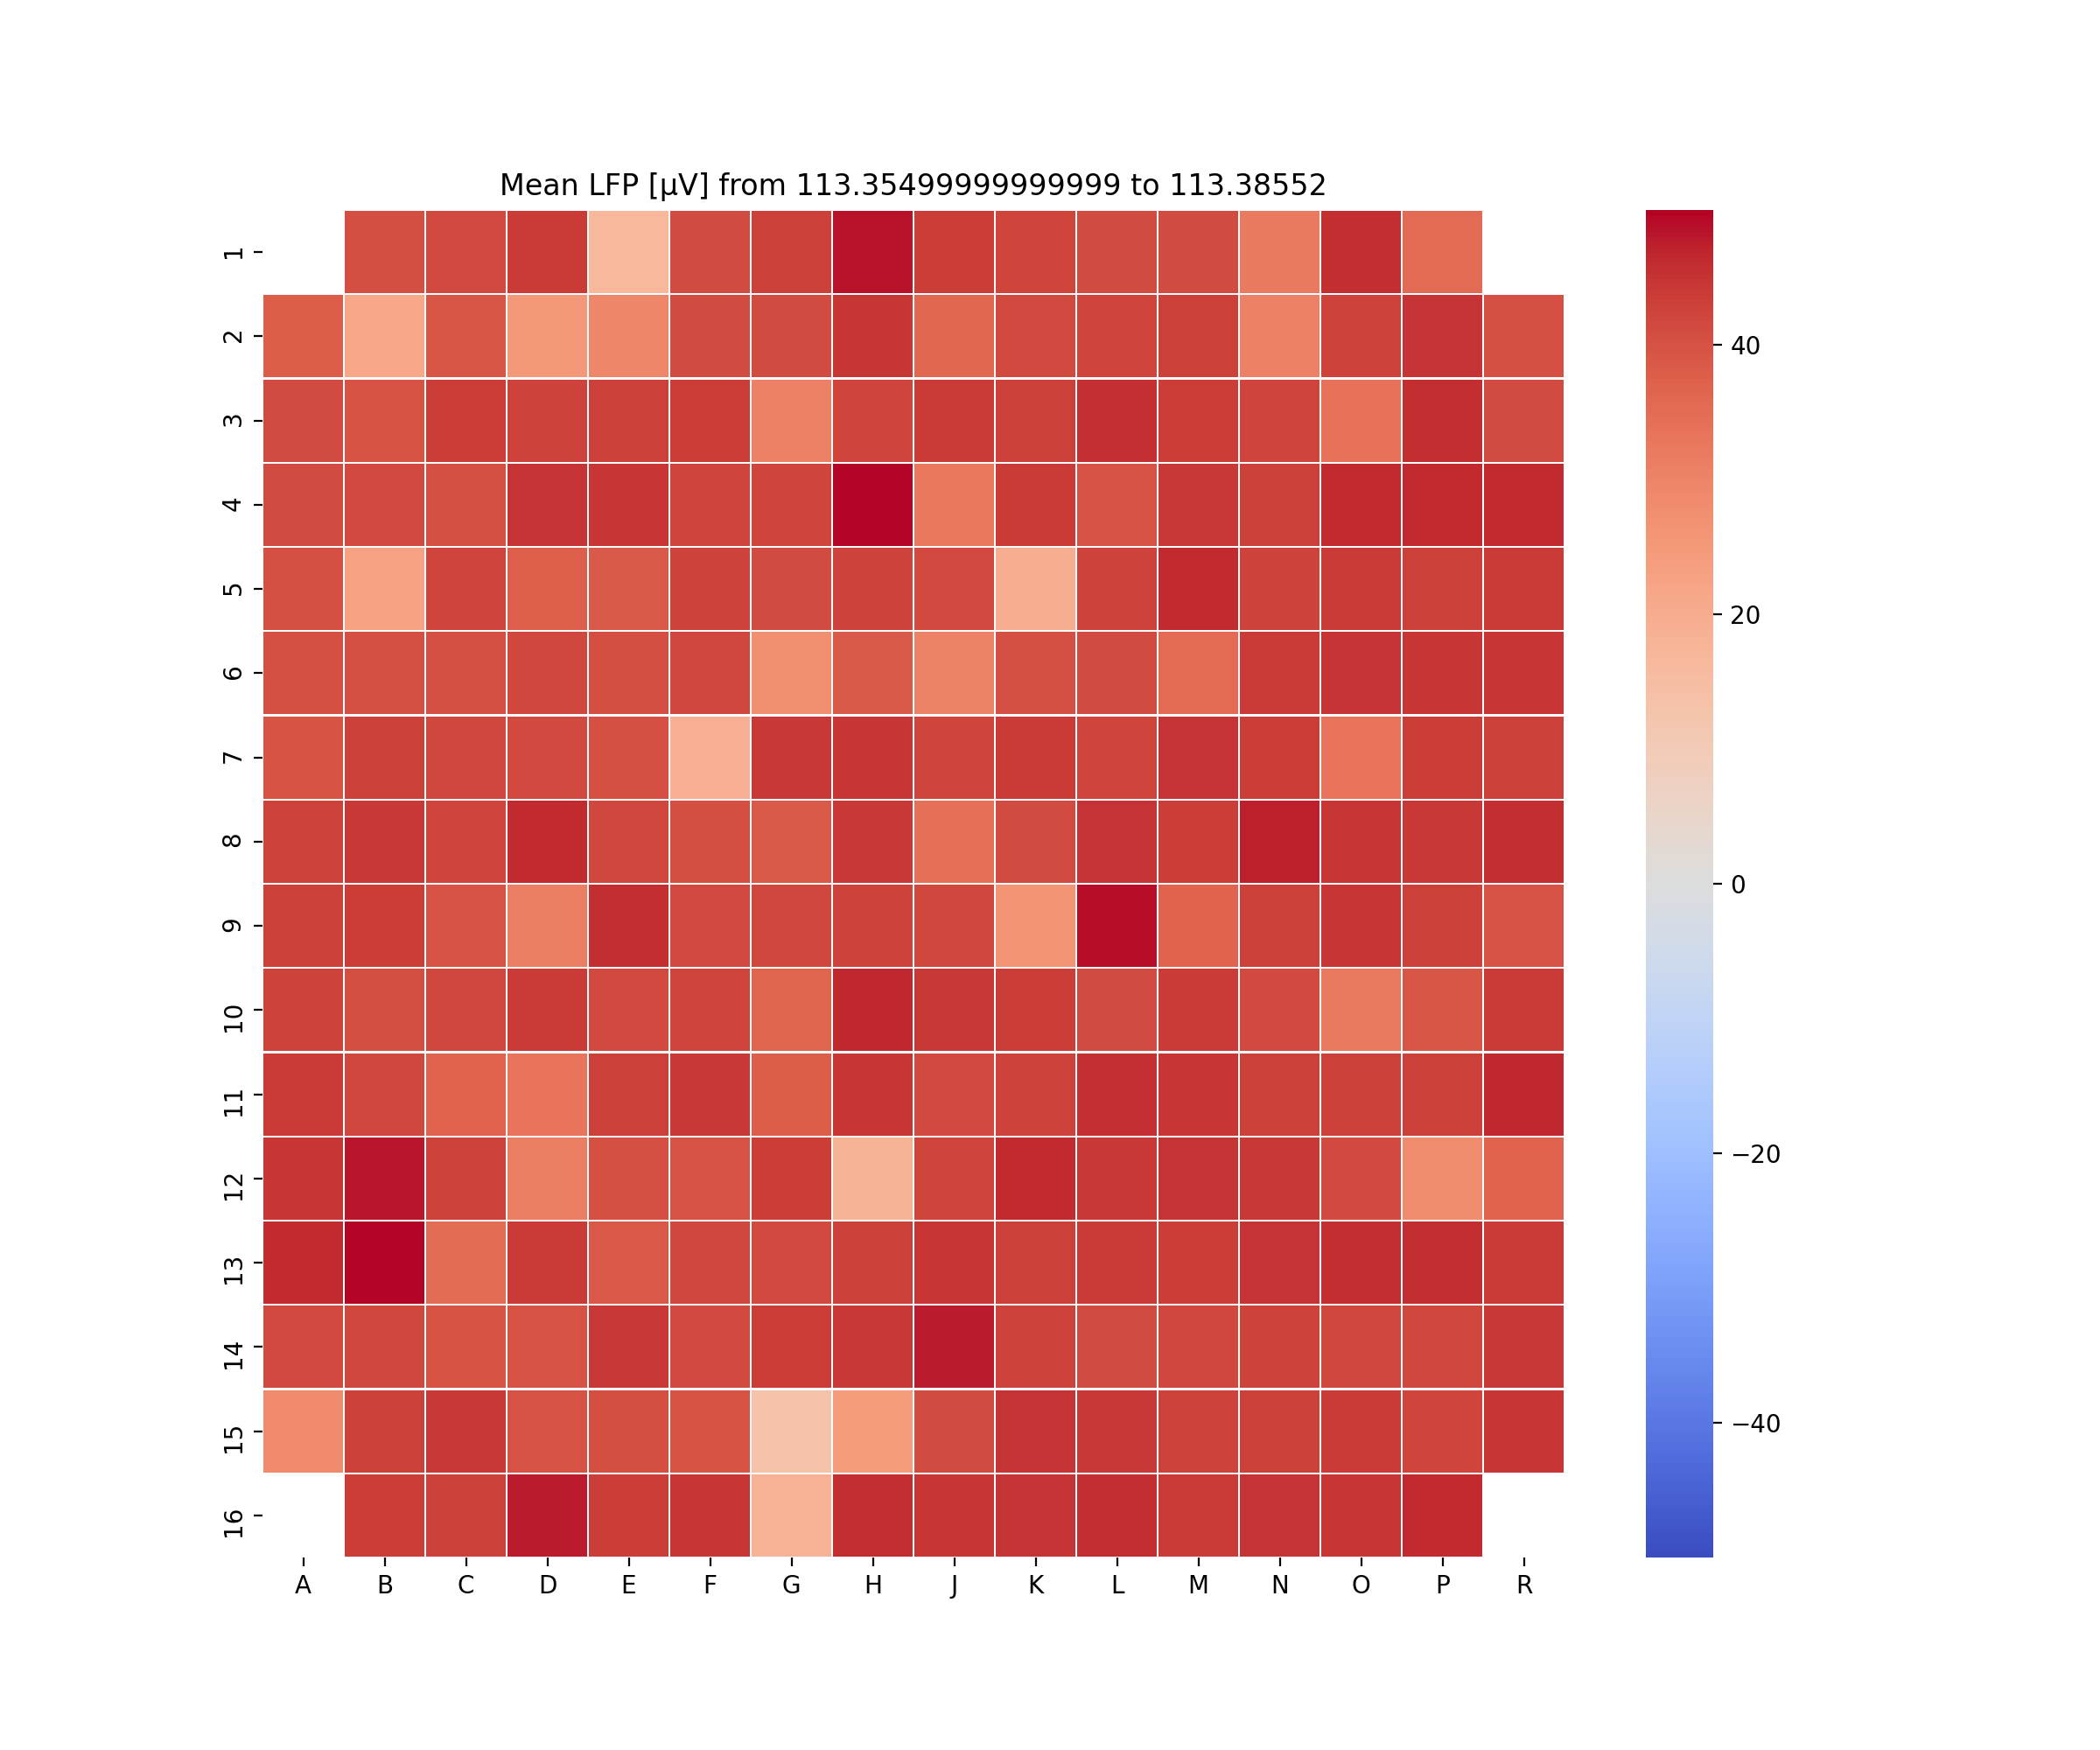

<IPython.core.display.Javascript object>


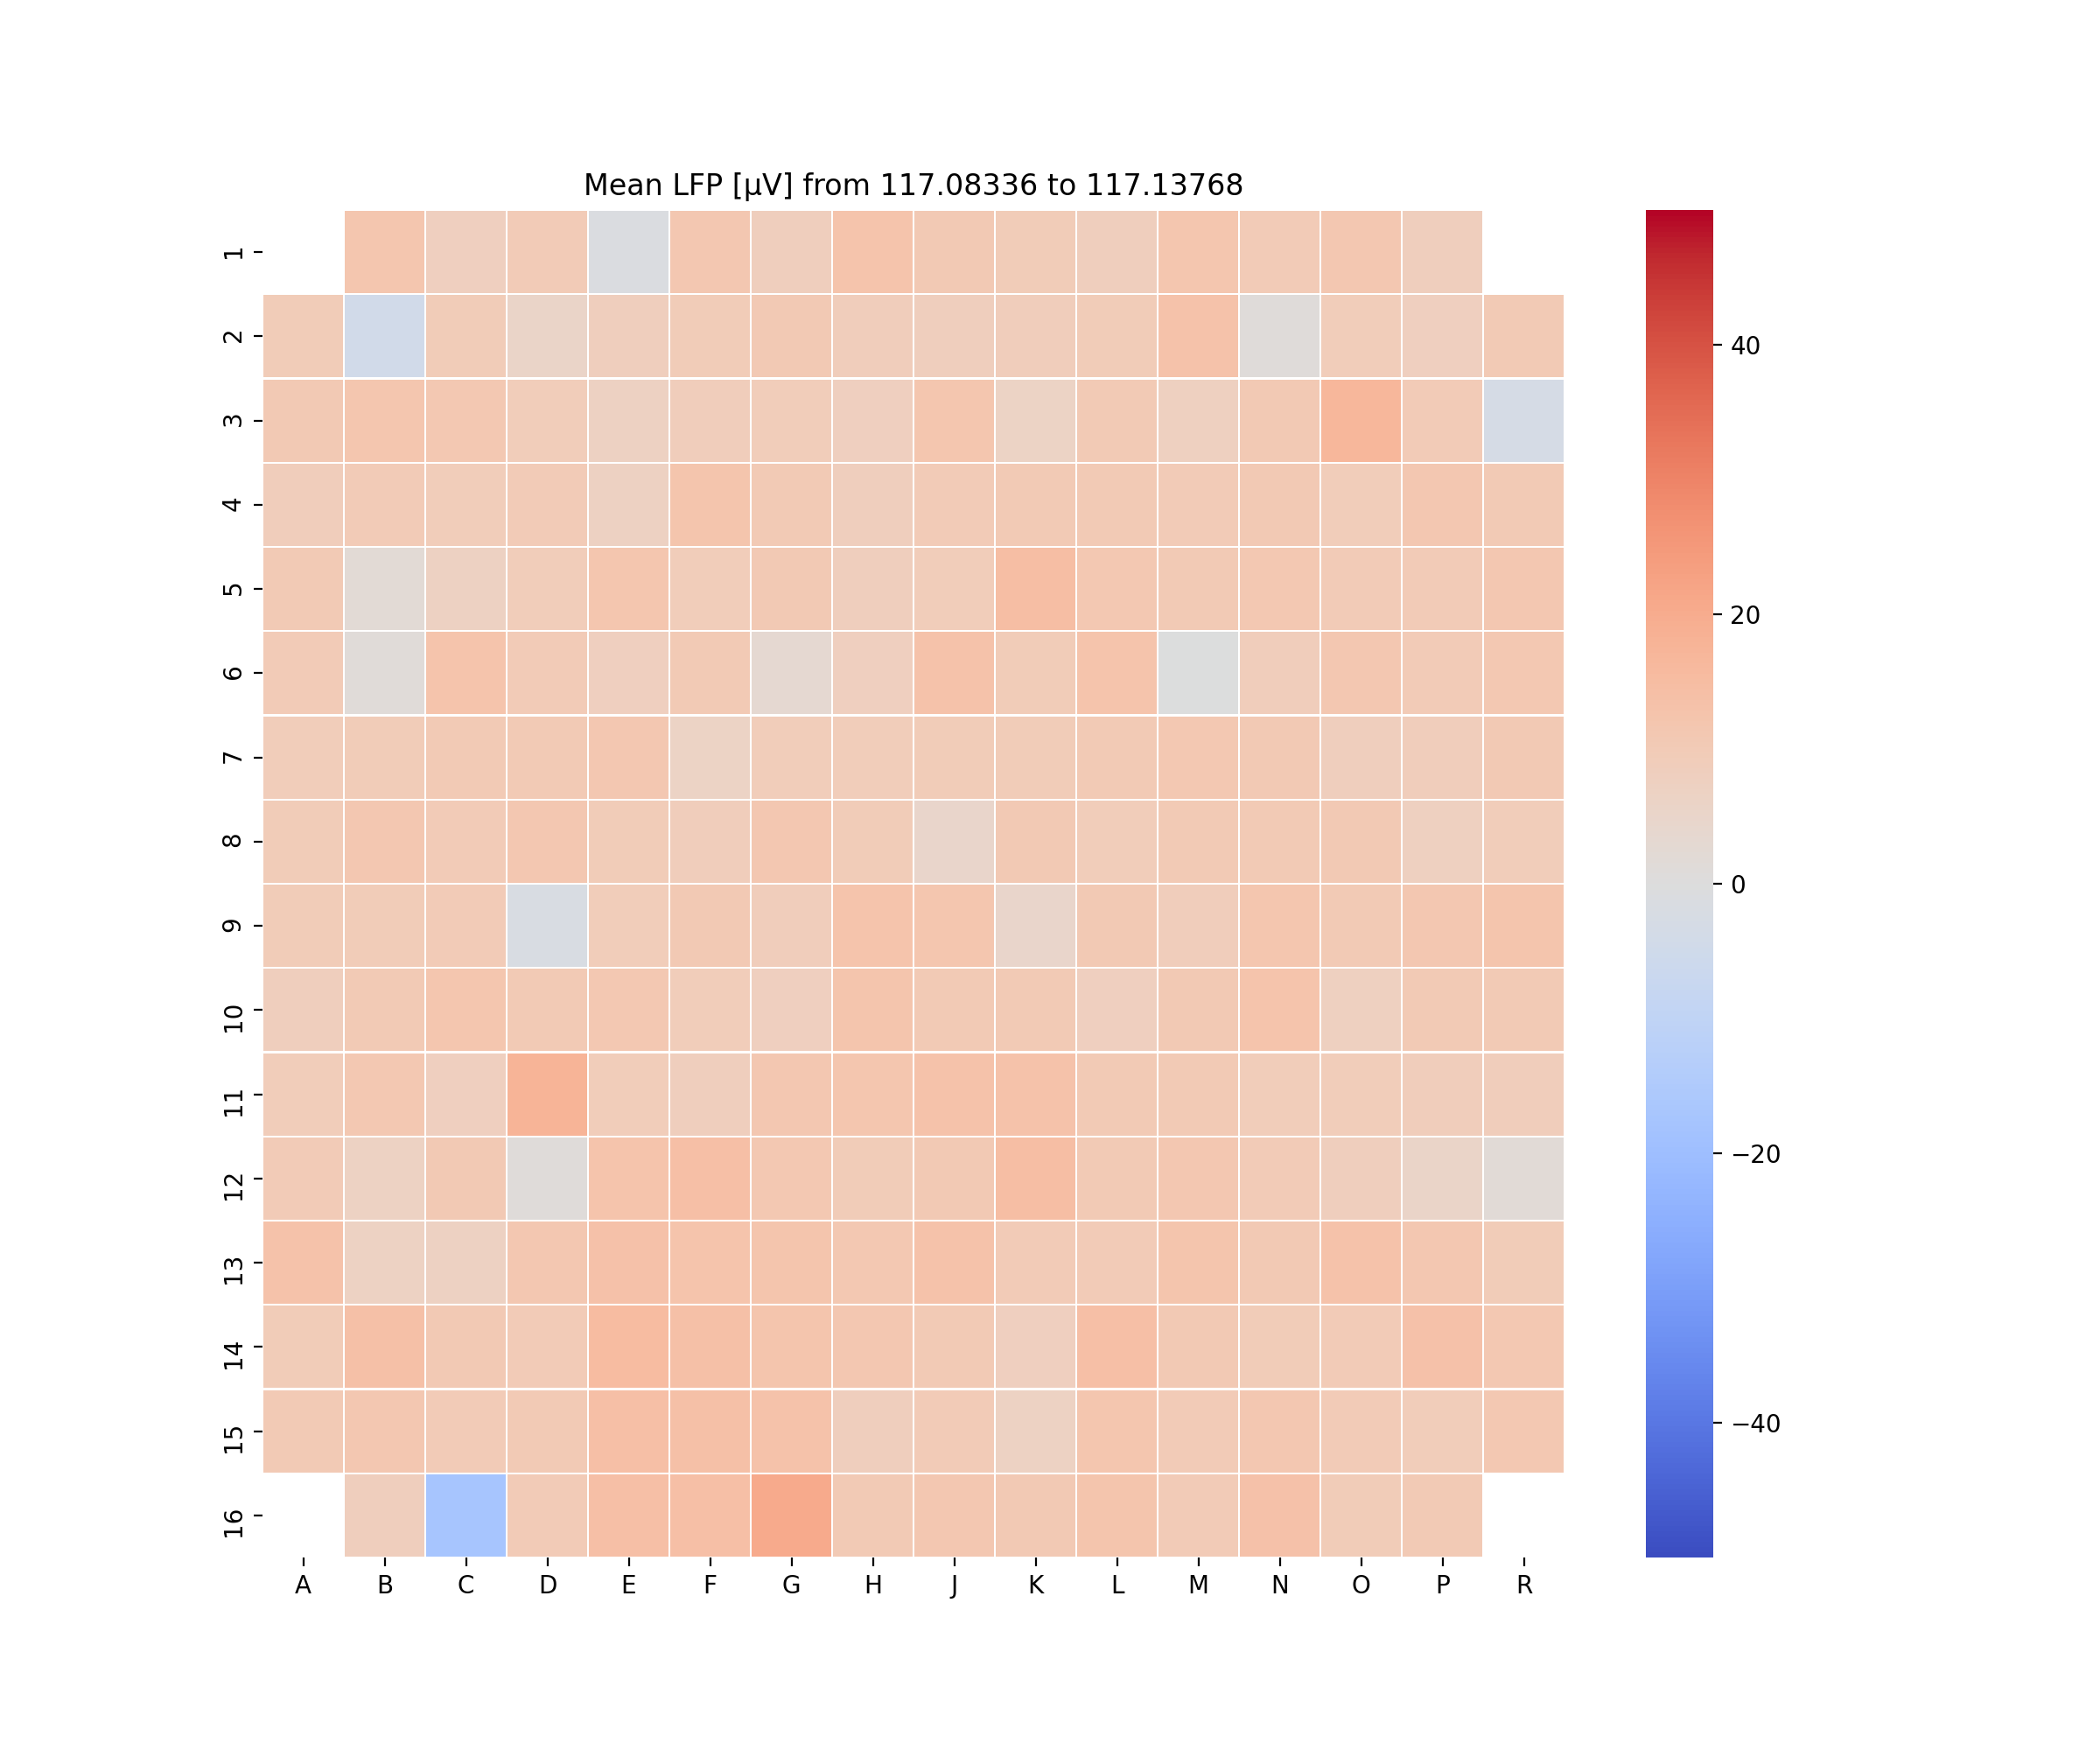

<IPython.core.display.Javascript object>


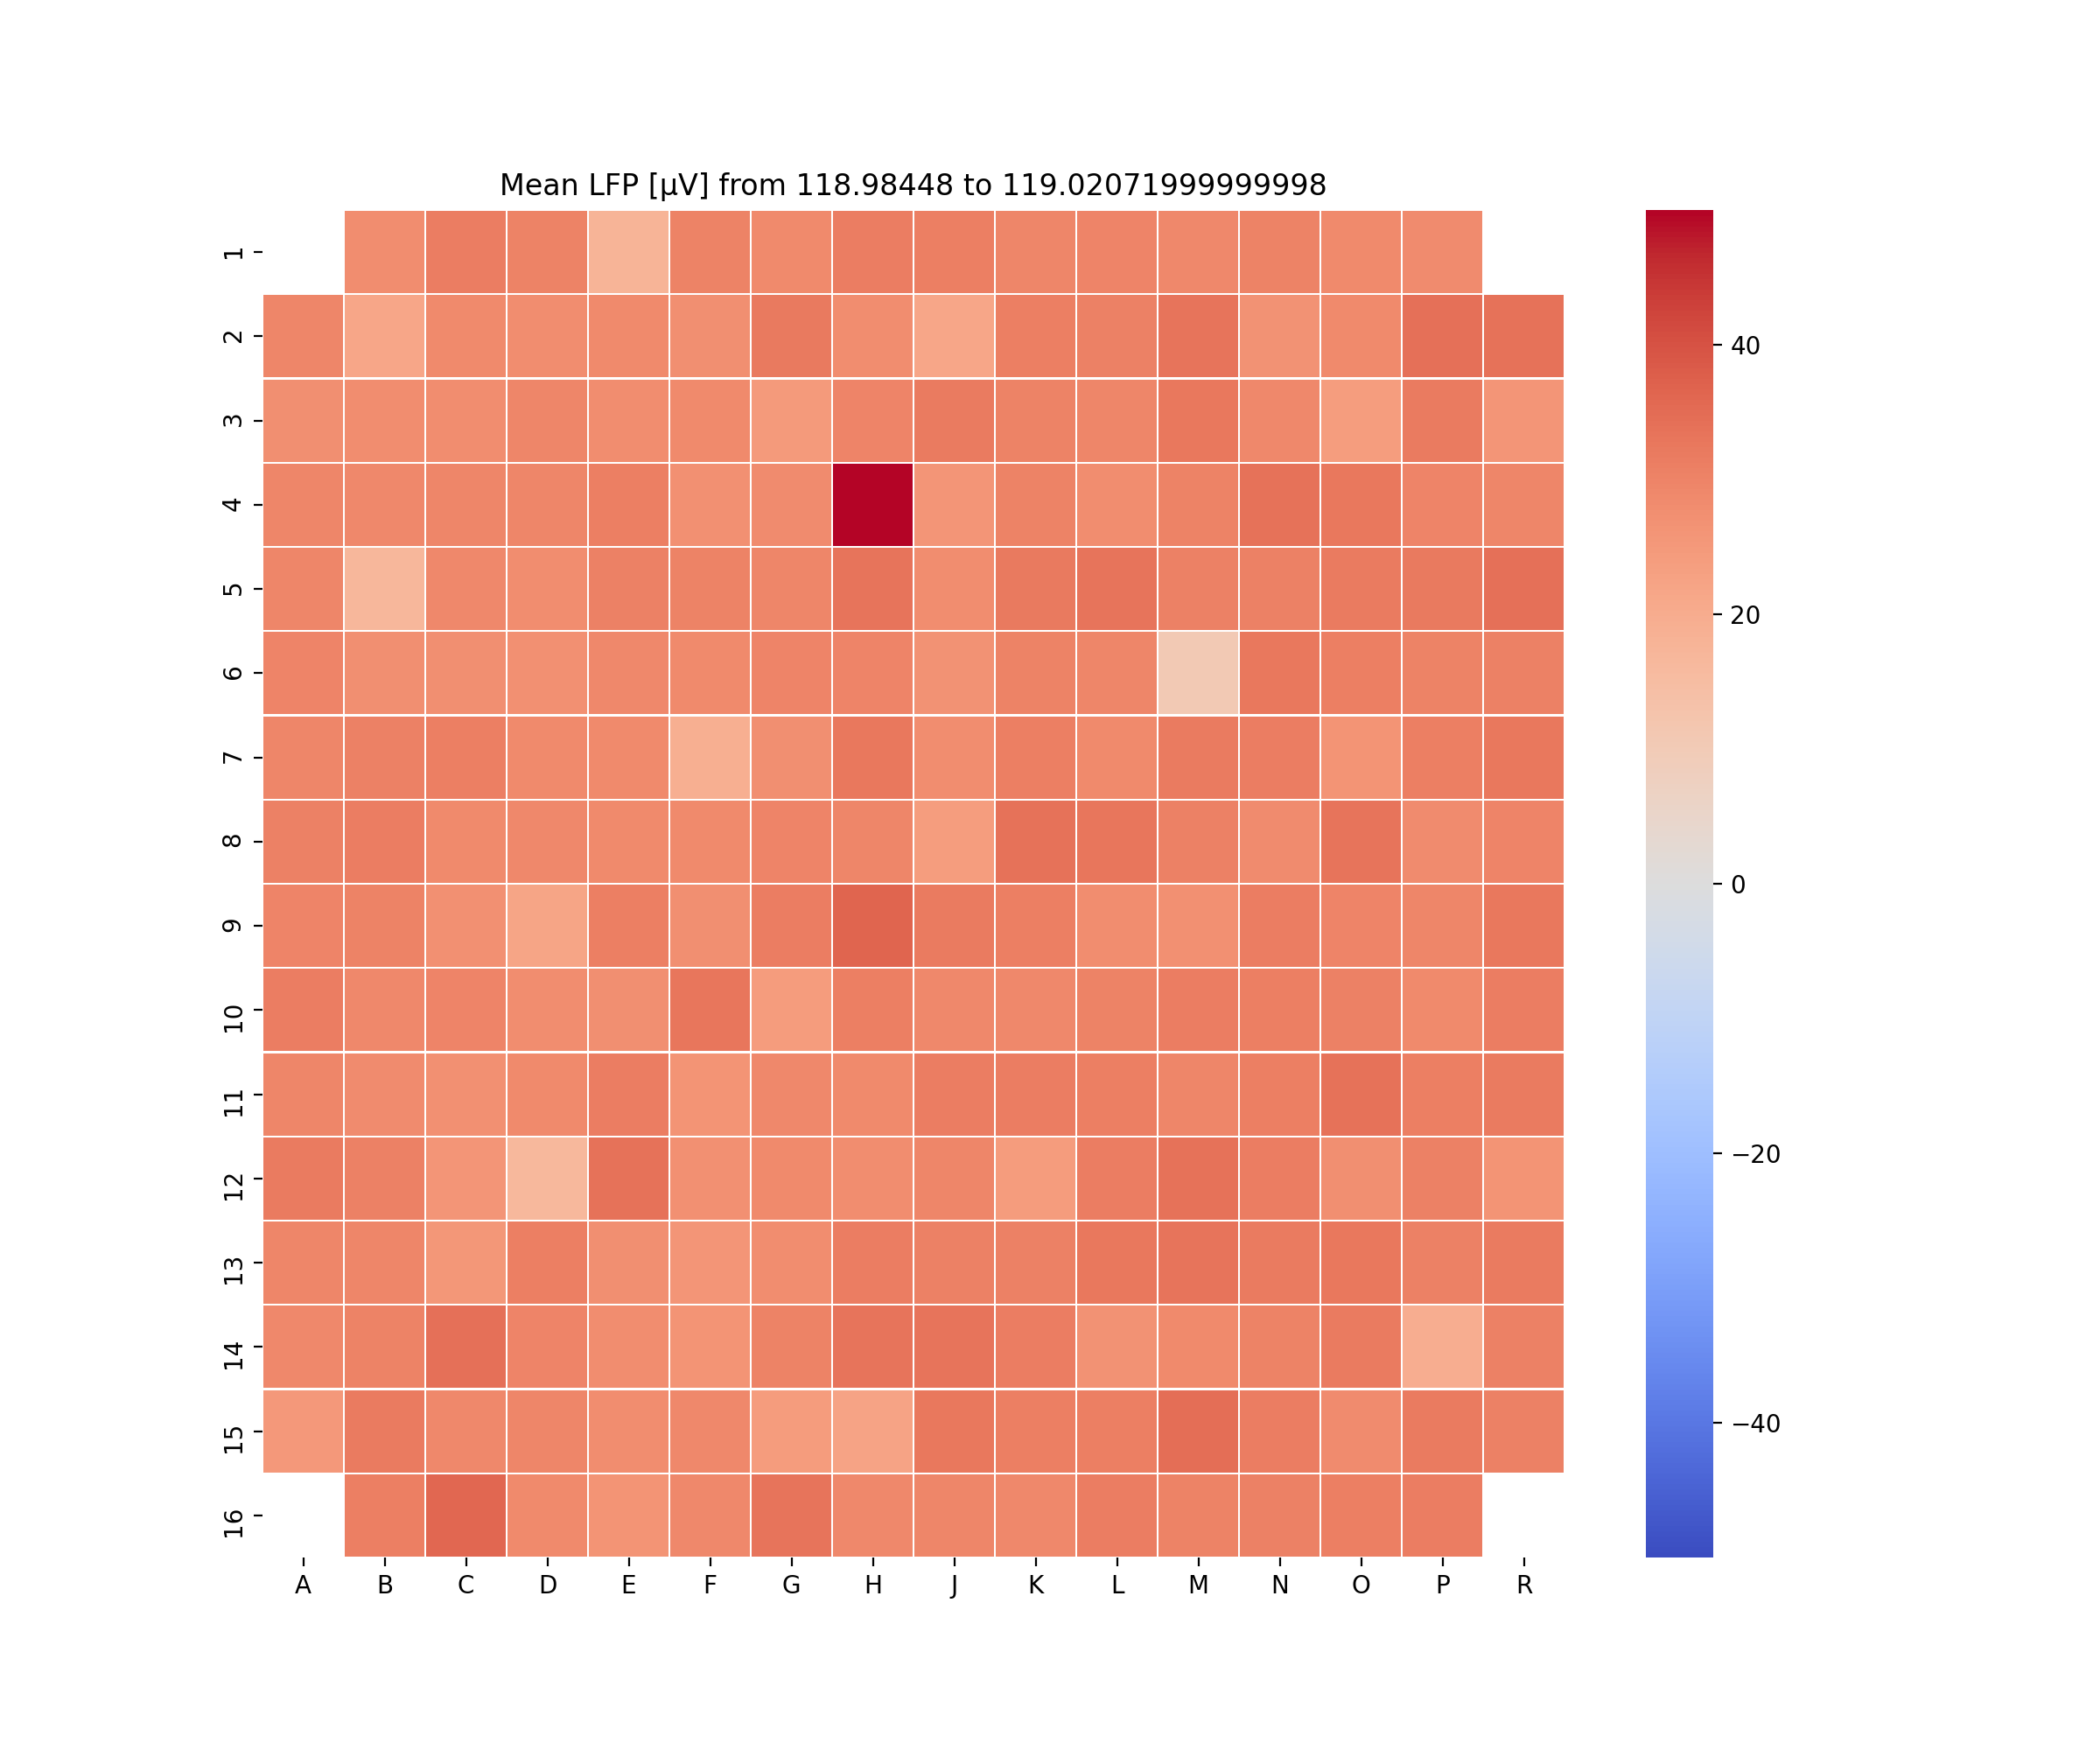

In [86]:
# plot all the different heatmaps for each lfp
for i in up_cross:
    
    start = i[0]
    stop = i[1]
    
    # get the mean for each channel of that lfp
    lmd = get_mean_lfp_dictionary(dictionary_lowpass_filtered=lowpass_dic, start = start,
                             stop = stop,
                                scale_factor_for_second=scale_factor_for_second, tick=tick)
    
    # create the empty mea array
    mea_array=np.empty((16,16,))
    mea_array[:]=np.nan
    columnlist =['A','B','C','D','E','F','G','H','J','K','L','M','N','O','P','R']
    df = pd.DataFrame(data=mea_array,columns=columnlist)
    df.index+=1
    
    # make the dictionary to a dataframe
    a = get_dict_values(df=df, dic=lmd)
    
    
    # plot the heatmap
    f, ax = plt.subplots(1, 1, figsize = (12,10))

    sns.heatmap(a, annot=False, linewidths=.5, ax=ax, cmap="coolwarm", vmax=50, vmin=-50)
    ax.set_title('Mean LFP [µV] from '+ str(start)+ ' to '+ str(stop))

    f.savefig(filename+'_LFP_heatmap_from_'+str(start)+'_to_'+str(stop)+'.pdf', dpi = 300)
    f.savefig(filename+'_LFP_heatmap_from_'+str(start)+'_to_'+str(stop)+'.pdf', dpi = 300)

In [215]:
start_lfp = 90
stop_lfp = 92

In [217]:
# we now want to make heatmaps to picture the activity to observe the spatial propagation

# let us make the heatmap window generic, so the burst is always subdivied into 10 subplots
observed_time = stop-start

heatmap_window = observed_time/10 # in seconds

# make start and endpoints for each of these time-windows:

time_windows = []

# start of the subdivision = rounded start of the burst of interest
i = np.round(start, 4)

# for every iteration, add the desired heatmap window
while i < stop:
    start = i
    stop = np.round(i+heatmap_window, 4)
    i = i + heatmap_window 
    if stop > stop_lfp:
        stop = stop_lfp
    time_windows.append((start, stop))

In [ ]:
fig = plt.figure(figsize=(20,8))

fig.tight_layout()
fig.suptitle('LFP Propagation from ' + 
             str(np.round(start_lfp, 4))+ ' to ' + 
             str(np.round(stop_lfp, 4)))
gs1 = gridspec.GridSpec(2, 5)

#countries = ["Country " + str(i) for i in range(1, 26)]
axs = []
time_intra_burst = 0

for i in range(1, len(time_windows)+1):
    

    plotframe = copy.deepcopy(df)
    
    # get the key for the fr_dic from the time windows:
    key = time_windows[i-1][0] # substract one because we start the for range at 1
    
    
    
    # fill the dataframe
    plotframe_filled = get_dict_values(plotframe, fr_dic)
    
    axs.append(fig.add_subplot(gs1[i-1]))
    # plot the heatmap
    #sns.heatmap(plotframe_filled, annot=False, linewidths=.5, ax=axstring, cmap="YlOrRd")


    axs[-1] = sns.heatmap(plotframe_filled, 
                          annot=False, vmin=0, vmax = 20, cmap='flare', 
                          cbar = False, linewidths=0.1)
    
    
    plt.setp(axs[-1], 
             title=str(int(time_intra_burst)) + ' ms')
    
    time_intra_burst += (heatmap_window*1000)

In [88]:
interesting_lfp = ['J2', 'J3', 'K2', 'K3', 'J13', 'J14', 'K13', 'K14', 'F15', 'E15']

bandpass_dic={}
lowpass_dic={}


for i in interesting_lfp:
    channellabel = i
    labellist = get_MEA_Channel_labels(np_analog_for_filter)
    signal_in_uV, time_in_sec, sampling_frequency, scale_factor_for_second = get_MEA_Signal(analog_stream_0, channel_idx)
    bandpassfilteredsignal = butter_bandpass_filter(
        signal_in_uV, lowcut, highcut, sampling_frequency
        )
    
    # get the lowpass signal
    # Filter requirements.
    T = timelengthrecording_s         # Sample Period
    fs = fs      # sample rate, Hz
    cutoff = 50      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2       # sin wave can be approx represented as quadratic
    n = int(T * fs) # total number of samples
    
    butter_lowpass_filtered_signal = butter_lowpass_filter(signal_in_uV, cutoff, fs, order)
    
    bandpass_dic[channellabel] = bandpassfilteredsignal
    lowpass_dic[channellabel] = butter_lowpass_filtered_signal

In [89]:
lowpass_dic

{'J2': array([11.37718047, 11.30829344, 11.23937924, ...,  2.20964416,
         2.20994097,  2.21018602]),
 'J3': array([11.37718047, 11.30829344, 11.23937924, ...,  2.20964416,
         2.20994097,  2.21018602]),
 'K2': array([11.37718047, 11.30829344, 11.23937924, ...,  2.20964416,
         2.20994097,  2.21018602]),
 'K3': array([11.37718047, 11.30829344, 11.23937924, ...,  2.20964416,
         2.20994097,  2.21018602]),
 'J13': array([11.37718047, 11.30829344, 11.23937924, ...,  2.20964416,
         2.20994097,  2.21018602]),
 'J14': array([11.37718047, 11.30829344, 11.23937924, ...,  2.20964416,
         2.20994097,  2.21018602]),
 'K13': array([11.37718047, 11.30829344, 11.23937924, ...,  2.20964416,
         2.20994097,  2.21018602]),
 'K14': array([11.37718047, 11.30829344, 11.23937924, ...,  2.20964416,
         2.20994097,  2.21018602]),
 'F15': array([11.37718047, 11.30829344, 11.23937924, ...,  2.20964416,
         2.20994097,  2.21018602]),
 'E15': array([11.37718047, 11.3

In [90]:
lowpass_dic['J2'][0]

11.377180469486737

In [91]:
# for every channel in our lowpass_dictionary, we want the std*3 for threshold

lowpass_threshold_dic = {}
up_crossing_dic = {}
down_crossing_dic = {}

for key in lowpass_dic:
    std = np.std(lowpass_dic[key])
    lowpass_threshold_dic[key] = std*3
    

# we want the up crossings of the lfp
# and the donwcrossings of the lfp

for key in lowpass_dic:
    
    threshold = lowpass_threshold_dic[key]
    low_signal = lowpass_dic[key]
    
    down_cross, up_cross = lfp_crossing_detection(
        low_signal, threshold)
    
    up_crossing_dic[key] = up_cross
    down_crossing_dic[key] = down_cross

In [96]:
lowpass_signal

11.377180469486737

<IPython.core.display.Javascript object>


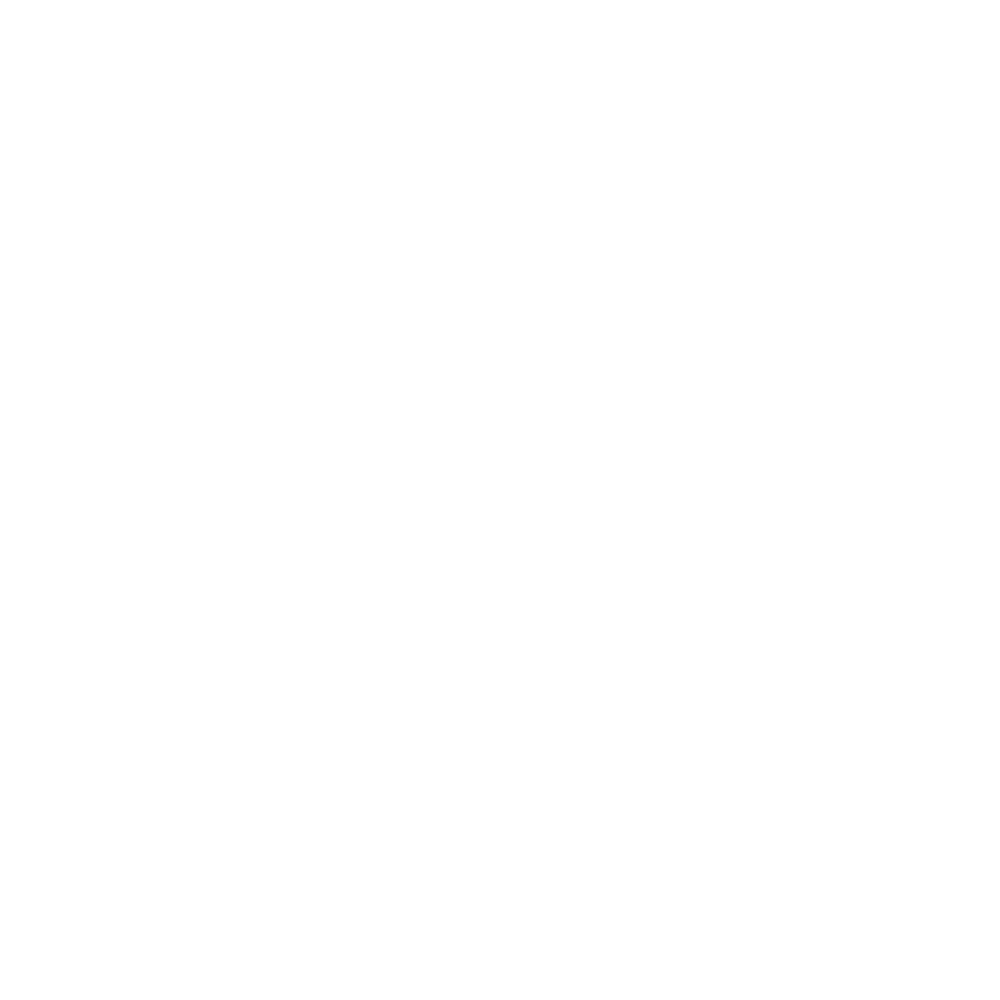

IndexError: index 90.2 is out of bounds for GridSpec with size 10

In [98]:
fig = plt.figure(figsize=(10,10))
limit0 = 89.3
limit1 = 91.2


windowsize = 0.2 #in seconds
win = limit0
windows = []
while win < limit1:
    if win + windowsize >= limit1:
        win = limit1
        windows.append(win)
    else:
        windows.append(win)
        win += windowsize

number_interesting_LFP = len(interesting_lfp)
#fig.tight_layout()
gs1 = gridspec.GridSpec(number_interesting_LFP, 1)
gs1.update(wspace=0.025, hspace=0.05) 
axs = []

for key in bandpass_dic:
    
    # get the key of the channel
    key = key
    
    #no get all signals to plot and the lfp_down and lfp_ups
    bandpass_signal = bandpass_dic[key]
    # in the lowpass_dic there are still additional returns from the old butter filter function
    lowpass_signal = lowpass_dic[key]
    lfp_ups = up_crossing_dic[key]
    lfp_downs = down_crossing_dic[key]
    
    
    axs.append(fig.add_subplot(gs1[i-1]))
    
    
    axs[-1] = plt.plot(time_in_sec, bandpass_signal, c="#048ABF", linewidth = 0.5)
    axs[-1] = plt.plot(time_in_sec, lowpass_signal, c='#F20505', linewidth=1)
    
    # spikes may be added additionally
    #axs[-1] = plt.plot(spikes*tick*scale_factor_for_second, 
     #                  [100]*(spikes*tick*scale_factor_for_second).shape[0], 
      #                 'ro', ms=2, c="#D9580D")

    
    for i in lfp_downs:
        ax = plt.axvspan(i[0], i[1], color='#5D7CA6', alpha=0.2)
    for i in lfp_ups:
        ax = plt.axvspan(i[0], i[1], color='#BF214B', alpha=0.2)
    for i in windows:
        ax = plt.axvline(i)
    
    # plt xlim for zooming in the time
    plt.xlim(limit0, limit1)    
    plt.yticks(fontsize='xx-small')
    plt.ylabel(key)
    #plt.ylim(-100, 100)
    

fig.suptitle(filebase + ' lfp + banbpass from '+str(limit0)+' to '+str(limit1))
fig.savefig(
    filebase + '_lfp_and_bandpasssignal_cutout_from_' + str(limit0) +'_to_'+str(limit1)+'.png',
    bbox_inches='tight', dpi=300)

In [195]:
spikes

array([1563659, 1563813, 1571219, 1911199, 2181412, 2258293, 2258629,
       2258788, 2259267, 2259367, 2259493, 2259610, 2259762, 2260014,
       2260263, 2262410, 2263298, 2263944, 2264733, 2265672, 2266803,
       2271248, 2271407, 2664734, 2665071, 2665283, 2665420, 2665626,
       2665726, 2665889, 2666044, 2666186, 2666606, 2667118, 2667254,
       2667524, 2668113, 2669111, 2669587, 2670870, 2672165, 2673329,
       2834014, 2834241, 2834367, 2974797], dtype=int64)

In [104]:
lowpass_signal

(array([5.68900865, 5.66306546, 5.63711961, ..., 1.78719673, 1.78716393,
        1.78713201]),
 array([3.91302054e-05, 7.82604108e-05, 3.91302054e-05]),
 array([ 1.        , -1.98222893,  0.98238545]))

In [87]:
bandpass_dic

{'G13': array([0.15240587, 0.98626915, 2.85086618, ..., 4.41586878, 6.29010552,
        8.28649551]),
 'G12': array([ 0.64948349,  3.45910291,  7.87847738, ..., -1.65921053,
        -2.68900204, -1.96463   ]),
 'F16': array([0.20867881, 1.11628415, 2.44812598, ..., 2.22131436, 2.74884864,
        4.74255338]),
 'F15': array([ 0.81126818,  4.26813203,  9.56608197, ..., -6.68994557,
        -4.40205936, -1.73453422]),
 'F14': array([ 0.29777763,  1.54977308,  3.31574514, ..., -1.0963439 ,
        -1.03260022, -1.08972174]),
 'F13': array([0.1617847 , 0.98722675, 2.6202342 , ..., 1.36133291, 0.58687532,
        0.21216949]),
 'F12': array([ 0.88395406,  4.62491457, 10.20126516, ..., -2.62601538,
        -2.77000523, -3.05608211]),
 'E16': array([ 0.75968466,  3.86895467,  8.11199533, ..., -1.66490566,
        -3.49241667, -4.3414667 ]),
 'E15': array([ 0.1219247 ,  0.8377852 ,  2.53280444, ..., -0.23542396,
         1.13167213,  1.79729714]),
 'E14': array([ 0.08909882,  0.64216774,  2.26

In [ ]:
fig = plt.figure(figsize=(20,8))

fig.tight_layout()
fig.suptitle('Burst Propagation from ' + 
             str(np.round(b_of_interest_start, 4))+ ' to ' + 
             str(np.round(b_of_interest_end, 4)))
gs1 = gridspec.GridSpec(2, 5)

#countries = ["Country " + str(i) for i in range(1, 26)]
axs = []
time_intra_burst = 0

for i in range(1, len(time_windows)+1):
    

    plotframe = copy.deepcopy(df)
    
    # get the key for the fr_dic from the time windows:
    key = time_windows[i-1][0] # substract one because we start the for range at 1
    
    #extract the corresponding fr_dic
    fr_dic = subdivided_boi_fr[key]
    
    # fill the dataframe
    plotframe_filled = get_dict_values(plotframe, fr_dic)
    
    axs.append(fig.add_subplot(gs1[i-1]))
    # plot the heatmap
    #sns.heatmap(plotframe_filled, annot=False, linewidths=.5, ax=axstring, cmap="YlOrRd")


    axs[-1] = sns.heatmap(plotframe_filled, 
                          annot=False, vmin=0, vmax = 20, cmap='flare', 
                          cbar = False, linewidths=0.1)
    
    
    plt.setp(axs[-1], 
             title=str(int(time_intra_burst)) + ' ms')
    
    time_intra_burst += (heatmap_window*1000)

fig.savefig('divided_burst_spatial_10082021_b25.png', dpi=300, bbox_inches = 'tight')

In [129]:
filename

'2021-05-17_cortex_div11_aCSF_ID046_30µMNE_spont_2'

In [42]:
np.linspace(0, 2 * np.pi, num=100)

array([0.        , 0.06346652, 0.12693304, 0.19039955, 0.25386607,
       0.31733259, 0.38079911, 0.44426563, 0.50773215, 0.57119866,
       0.63466518, 0.6981317 , 0.76159822, 0.82506474, 0.88853126,
       0.95199777, 1.01546429, 1.07893081, 1.14239733, 1.20586385,
       1.26933037, 1.33279688, 1.3962634 , 1.45972992, 1.52319644,
       1.58666296, 1.65012947, 1.71359599, 1.77706251, 1.84052903,
       1.90399555, 1.96746207, 2.03092858, 2.0943951 , 2.15786162,
       2.22132814, 2.28479466, 2.34826118, 2.41172769, 2.47519421,
       2.53866073, 2.60212725, 2.66559377, 2.72906028, 2.7925268 ,
       2.85599332, 2.91945984, 2.98292636, 3.04639288, 3.10985939,
       3.17332591, 3.23679243, 3.30025895, 3.36372547, 3.42719199,
       3.4906585 , 3.55412502, 3.61759154, 3.68105806, 3.74452458,
       3.8079911 , 3.87145761, 3.93492413, 3.99839065, 4.06185717,
       4.12532369, 4.1887902 , 4.25225672, 4.31572324, 4.37918976,
       4.44265628, 4.5061228 , 4.56958931, 4.63305583, 4.69652

In [43]:
np.cos(np.linspace(0, 2 * np.pi, num = 100))

array([ 1.        ,  0.99798668,  0.99195481,  0.9819287 ,  0.9679487 ,
        0.95007112,  0.92836793,  0.90292654,  0.87384938,  0.84125353,
        0.80527026,  0.76604444,  0.72373404,  0.67850941,  0.63055267,
        0.58005691,  0.52722547,  0.47227107,  0.41541501,  0.35688622,
        0.29692038,  0.23575894,  0.17364818,  0.1108382 ,  0.04758192,
       -0.01586596, -0.07924996, -0.14231484, -0.20480667, -0.26647381,
       -0.32706796, -0.38634513, -0.44406661, -0.5       , -0.55392006,
       -0.60560969, -0.65486073, -0.70147489, -0.74526445, -0.78605309,
       -0.82367658, -0.85798341, -0.88883545, -0.91610846, -0.93969262,
       -0.95949297, -0.97542979, -0.98743889, -0.99547192, -0.99949654,
       -0.99949654, -0.99547192, -0.98743889, -0.97542979, -0.95949297,
       -0.93969262, -0.91610846, -0.88883545, -0.85798341, -0.82367658,
       -0.78605309, -0.74526445, -0.70147489, -0.65486073, -0.60560969,
       -0.55392006, -0.5       , -0.44406661, -0.38634513, -0.32

In [47]:
sig_neo = AnalogSignal(bandpassfilteredsignal, sampling_rate=25000*pq.Hz, units='mV')

In [48]:
sig_neo

AnalogSignal with 1 channels of length 3010000; units mV; datatype float64 
sampling rate: 25000.0 Hz
time: 0.0 s to 120.4 s

In [52]:
freq, psd = welch_psd(sig_neo)

In [53]:
freq, psd

(array([0.00000000e+00, 3.73754650e-02, 7.47509299e-02, ...,
        1.24999252e+04, 1.24999626e+04, 1.25000000e+04]) * Hz,
 array([[3.37487892e-08, 1.68743888e-08, 5.46382557e-22, ...,
         3.81985992e-32, 3.97097524e-32, 1.95987874e-32]]) * mV**2/Hz)

In [54]:
freq.shape

(334445,)

In [55]:
psd.shape

(1, 334445)

<IPython.core.display.Javascript object>


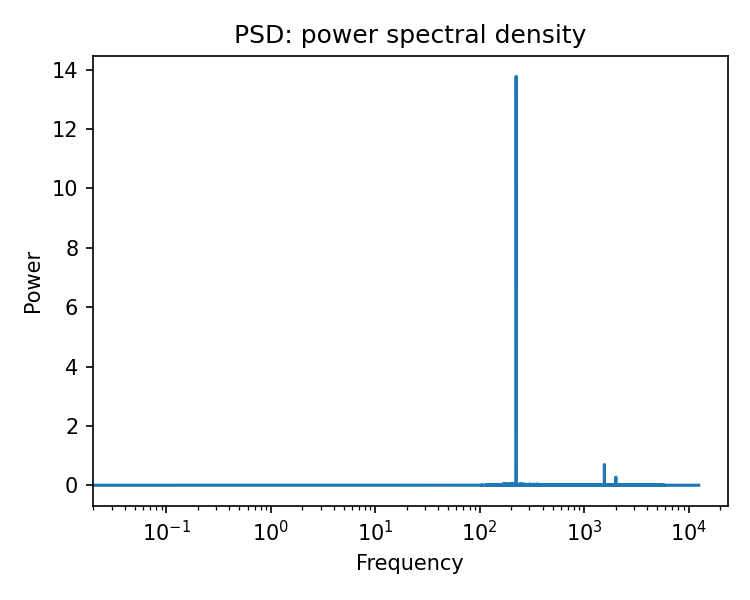

In [61]:


plt.figure(figsize=(5, 4))
plt.semilogx(freq, psd[0])
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

In [47]:
working_directory = '/Users/naila/Documents/DATA/PREPROCESSED/Jonas Ort/ID046/output/2021-05-17_cortex_div11_aCSF_ID046_30µMNE_spont_2'

In [48]:
os.chdir(working_directory)

In [49]:
filename=working_directory.split('/')[-1]
import pickle

In [50]:
MAIN_RECORDING_DICTIONARY = pickle.load(open('MAIN_RECORDING_Dictionary_'+filename+'.pkl', "rb"))

In [51]:
spikedic_MAD = MAIN_RECORDING_DICTIONARY['spikedic_MAD']
tick = MAIN_RECORDING_DICTIONARY['Infos_Recording']['tick']
timelengthrecording_s = MAIN_RECORDING_DICTIONARY['Infos_Recording']['timelengthrecording_s']
info_dics_subrecordings = MAIN_RECORDING_DICTIONARY['Infos_Recording']['info_dics_subrecordings']
first_recording_timepoint = info_dics_subrecordings['0_to_120']['first_recording_timepoint']
scale_factor_for_second = MAIN_RECORDING_DICTIONARY['Infos_Recording']['scale_factor_for_second']
relevant_factor = timelengthrecording_s*0.05
fr_dic = MAIN_RECORDING_DICTIONARY['fr_dic']


In [86]:
spikedic_MAD

{'G13': [149295,
  150175,
  150381,
  567210,
  567620,
  568228,
  861553,
  861598,
  861712,
  884076,
  884490,
  884686,
  1337405,
  1337605,
  1338128,
  2310573,
  2310648,
  2311186,
  2505788,
  2681140,
  2733571,
  3354357,
  3355060,
  3361968,
  3361988,
  3362113,
  3671521,
  4050810,
  4050888,
  4051482,
  4051573,
  4053751,
  4303062,
  4304036,
  4416199,
  4416603,
  4416689,
  5079427,
  5369098,
  5369191,
  5826003,
  5826007,
  5826025,
  5826310,
  5826565],
 'G12': [149428,
  861554,
  861596,
  861715,
  3354236,
  3354550,
  3361963,
  3361987,
  3362116,
  5826493],
 'F16': [861554, 3361970, 3361986, 3362097],
 'F15': [149079,
  149385,
  149466,
  149490,
  149568,
  149644,
  149727,
  149819,
  149970,
  150173,
  150296,
  150511,
  150580,
  150933,
  151159,
  151428,
  151665,
  152645,
  153485,
  154504,
  155412,
  155524,
  156557,
  156725,
  158495,
  558839,
  567219,
  567321,
  567399,
  567468,
  567507,
  567615,
  567690,
  567816,
  5

In [89]:
spikes = spikedic_MAD['J2']

In [91]:
len(spikes)

533

In [92]:
cutouts = extract_waveforms(bandpassfilteredsignal, 25000, spikes, 
        0.001, 0.003
        )

In [56]:
im = np.arange((-pre*1000), 0.003*1000, 1e3/fs)
im

array([-1.0000000e+00, -9.6000000e-01, -9.2000000e-01, -8.8000000e-01,
       -8.4000000e-01, -8.0000000e-01, -7.6000000e-01, -7.2000000e-01,
       -6.8000000e-01, -6.4000000e-01, -6.0000000e-01, -5.6000000e-01,
       -5.2000000e-01, -4.8000000e-01, -4.4000000e-01, -4.0000000e-01,
       -3.6000000e-01, -3.2000000e-01, -2.8000000e-01, -2.4000000e-01,
       -2.0000000e-01, -1.6000000e-01, -1.2000000e-01, -8.0000000e-02,
       -4.0000000e-02,  8.8817842e-16,  4.0000000e-02,  8.0000000e-02,
        1.2000000e-01,  1.6000000e-01,  2.0000000e-01,  2.4000000e-01,
        2.8000000e-01,  3.2000000e-01,  3.6000000e-01,  4.0000000e-01,
        4.4000000e-01,  4.8000000e-01,  5.2000000e-01,  5.6000000e-01,
        6.0000000e-01,  6.4000000e-01,  6.8000000e-01,  7.2000000e-01,
        7.6000000e-01,  8.0000000e-01,  8.4000000e-01,  8.8000000e-01,
        9.2000000e-01,  9.6000000e-01,  1.0000000e+00,  1.0400000e+00,
        1.0800000e+00,  1.1200000e+00,  1.1600000e+00,  1.2000000e+00,
      

In [93]:
cutouts.shape

(533, 100)

In [94]:
post = 0.003

<IPython.core.display.Javascript object>


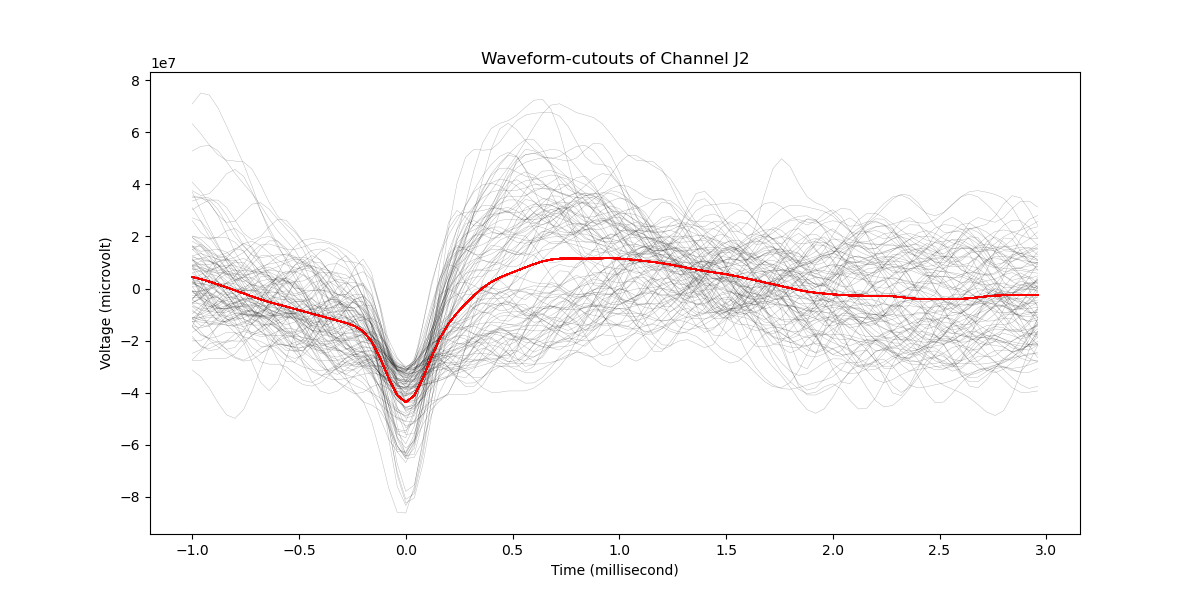

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [101]:
#figure 2: waveforms 
fig2, ax2 = plt.subplots(1, 1, figsize=(12,6))
#ax2 is a plot of the waveform cutouts
n = 100
n = min(n, cutouts.shape[0])
time_in_us = np.arange(-pre*1000, post*1000, 1e3/fs)
cutout_mean = np.mean(cutouts, axis=0)
for i in range(n):
    ax2 = plt.plot(time_in_us, cutouts[i,]*1e6, color='black', linewidth=0.3, alpha=0.3)
    ax2 = plt.plot(time_in_us, cutout_mean*1e6, color="red", linewidth=1, alpha=0.3)
    ax2 = plt.xlabel('Time (%s)' % ureg.ms)
    ax2 = plt.ylabel('Voltage (%s)' % ureg.uV)
    ax2 = plt.title('Waveform-cutouts of Channel %s' %channellabel)

fig2.savefig(filename+'_waveforms_'+channellabel+'MAD_THRESHOLD_03.eps', dpi=300, bbox_inches = 'tight')


In [99]:
os.chdir('/Users/naila/Documents/plots_feldmeyerpaper/new_041122')